In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['nb_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'nb_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testconv", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
reload (rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [27]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3003nb_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (197333, 2) (47959, 2)
train/valid # (197333, 2) (47959, 2)


rand split across time
train has 197333 records out of 372221 records
valid has 47959 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1541
0
26 18 (1, 18)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1541 [..............................] - ETA: 47:24 - loss: 36.8556 - total_loss: 36.8556 - reg_loss: 7.9951

   5/1541 [..............................] - ETA: 9:44 - loss: 9.1202 - total_loss: 9.1202 - reg_loss: 4.0479   

   9/1541 [..............................] - ETA: 5:33 - loss: 6.1134 - total_loss: 6.1134 - reg_loss: 9.1151

  13/1541 [..............................] - ETA: 3:56 - loss: 4.9451 - total_loss: 4.9451 - reg_loss: 10.8810

  17/1541 [..............................] - ETA: 3:04 - loss: 4.2809 - total_loss: 4.2809 - reg_loss: 9.1838 

  22/1541 [..............................] - ETA: 2:26 - loss: 3.7847 - total_loss: 3.7847 - reg_loss: 7.2985

  26/1541 [..............................] - ETA: 2:06 - loss: 3.5215 - total_loss: 3.5215 - reg_loss: 6.3242

  30/1541 [..............................] - ETA: 1:51 - loss: 3.3271 - total_loss: 3.3271 - reg_loss: 5.6194

  35/1541 [..............................] - ETA: 1:38 - loss: 3.1432 - total_loss: 3.1432 - reg_loss: 4.9238

  40/1541 [..............................] - ETA: 1:27 - loss: 3.0055 - total_loss: 3.0055 - reg_loss: 4.3852

  44/1541 [..............................] - ETA: 1:21 - loss: 2.9195 - total_loss: 2.9195 - reg_loss: 4.0386

  48/1541 [..............................] - ETA: 1:16 - loss: 2.8472 - total_loss: 2.8472 - reg_loss: 3.7558

  53/1541 [>.............................] - ETA: 1:10 - loss: 2.7708 - total_loss: 2.7708 - reg_loss: 3.4467

  57/1541 [>.............................] - ETA: 1:06 - loss: 2.7183 - total_loss: 2.7183 - reg_loss: 3.2420

  61/1541 [>.............................] - ETA: 1:03 - loss: 2.6737 - total_loss: 2.6737 - reg_loss: 3.0633

  65/1541 [>.............................] - ETA: 1:00 - loss: 2.6348 - total_loss: 2.6348 - reg_loss: 2.9079

  69/1541 [>.............................] - ETA: 58s - loss: 2.6000 - total_loss: 2.6000 - reg_loss: 2.7748 

  73/1541 [>.............................] - ETA: 55s - loss: 2.5692 - total_loss: 2.5692 - reg_loss: 2.6474

  77/1541 [>.............................] - ETA: 53s - loss: 2.5417 - total_loss: 2.5417 - reg_loss: 2.5335

  81/1541 [>.............................] - ETA: 52s - loss: 2.5163 - total_loss: 2.5163 - reg_loss: 2.4300

  85/1541 [>.............................] - ETA: 50s - loss: 2.4936 - total_loss: 2.4936 - reg_loss: 2.3385

  89/1541 [>.............................] - ETA: 48s - loss: 2.4737 - total_loss: 2.4737 - reg_loss: 2.2511

  93/1541 [>.............................] - ETA: 47s - loss: 2.4549 - total_loss: 2.4549 - reg_loss: 2.1719

  98/1541 [>.............................] - ETA: 45s - loss: 2.4346 - total_loss: 2.4346 - reg_loss: 2.0823

 102/1541 [>.............................] - ETA: 44s - loss: 2.4194 - total_loss: 2.4194 - reg_loss: 2.0190

 106/1541 [=>............................] - ETA: 43s - loss: 2.4044 - total_loss: 2.4044 - reg_loss: 1.9610

 110/1541 [=>............................] - ETA: 42s - loss: 2.3913 - total_loss: 2.3913 - reg_loss: 1.9038

 114/1541 [=>............................] - ETA: 41s - loss: 2.3791 - total_loss: 2.3791 - reg_loss: 1.8538

 119/1541 [=>............................] - ETA: 40s - loss: 2.3653 - total_loss: 2.3653 - reg_loss: 1.7919

 123/1541 [=>............................] - ETA: 39s - loss: 2.3547 - total_loss: 2.3547 - reg_loss: 1.7481

 127/1541 [=>............................] - ETA: 38s - loss: 2.3451 - total_loss: 2.3451 - reg_loss: 1.7063

 131/1541 [=>............................] - ETA: 38s - loss: 2.3353 - total_loss: 2.3353 - reg_loss: 1.6659

 135/1541 [=>............................] - ETA: 37s - loss: 2.3267 - total_loss: 2.3267 - reg_loss: 1.6278

 139/1541 [=>............................] - ETA: 36s - loss: 2.3181 - total_loss: 2.3181 - reg_loss: 1.5912

 143/1541 [=>............................] - ETA: 36s - loss: 2.3101 - total_loss: 2.3101 - reg_loss: 1.5577

 147/1541 [=>............................] - ETA: 35s - loss: 2.3028 - total_loss: 2.3028 - reg_loss: 1.5251

 151/1541 [=>............................] - ETA: 35s - loss: 2.2955 - total_loss: 2.2955 - reg_loss: 1.4948

 156/1541 [==>...........................] - ETA: 34s - loss: 2.2869 - total_loss: 2.2869 - reg_loss: 1.4580

 160/1541 [==>...........................] - ETA: 34s - loss: 2.2811 - total_loss: 2.2811 - reg_loss: 1.4306

 164/1541 [==>...........................] - ETA: 33s - loss: 2.2754 - total_loss: 2.2754 - reg_loss: 1.4047

 168/1541 [==>...........................] - ETA: 33s - loss: 2.2697 - total_loss: 2.2697 - reg_loss: 1.3800

 172/1541 [==>...........................] - ETA: 32s - loss: 2.2646 - total_loss: 2.2646 - reg_loss: 1.3564

 176/1541 [==>...........................] - ETA: 32s - loss: 2.2596 - total_loss: 2.2596 - reg_loss: 1.3339

 180/1541 [==>...........................] - ETA: 31s - loss: 2.2544 - total_loss: 2.2544 - reg_loss: 1.3135

 184/1541 [==>...........................] - ETA: 31s - loss: 2.2496 - total_loss: 2.2496 - reg_loss: 1.2930

 188/1541 [==>...........................] - ETA: 31s - loss: 2.2453 - total_loss: 2.2453 - reg_loss: 1.2737

 192/1541 [==>...........................] - ETA: 30s - loss: 2.2410 - total_loss: 2.2410 - reg_loss: 1.2554

 196/1541 [==>...........................] - ETA: 30s - loss: 2.2366 - total_loss: 2.2366 - reg_loss: 1.2375

 200/1541 [==>...........................] - ETA: 30s - loss: 2.2326 - total_loss: 2.2326 - reg_loss: 1.2196

 205/1541 [==>...........................] - ETA: 29s - loss: 2.2277 - total_loss: 2.2277 - reg_loss: 1.1986

 209/1541 [===>..........................] - ETA: 29s - loss: 2.2241 - total_loss: 2.2241 - reg_loss: 1.1817

 213/1541 [===>..........................] - ETA: 29s - loss: 2.2202 - total_loss: 2.2202 - reg_loss: 1.1663

 217/1541 [===>..........................] - ETA: 28s - loss: 2.2168 - total_loss: 2.2168 - reg_loss: 1.1517

 222/1541 [===>..........................] - ETA: 28s - loss: 2.2126 - total_loss: 2.2126 - reg_loss: 1.1333

 226/1541 [===>..........................] - ETA: 28s - loss: 2.2093 - total_loss: 2.2093 - reg_loss: 1.1190

 230/1541 [===>..........................] - ETA: 27s - loss: 2.2062 - total_loss: 2.2062 - reg_loss: 1.1067

 234/1541 [===>..........................] - ETA: 27s - loss: 2.2033 - total_loss: 2.2033 - reg_loss: 1.0933

 238/1541 [===>..........................] - ETA: 27s - loss: 2.2004 - total_loss: 2.2004 - reg_loss: 1.0801

 242/1541 [===>..........................] - ETA: 27s - loss: 2.1975 - total_loss: 2.1975 - reg_loss: 1.0685

 246/1541 [===>..........................] - ETA: 26s - loss: 2.1951 - total_loss: 2.1951 - reg_loss: 1.0568

 250/1541 [===>..........................] - ETA: 26s - loss: 2.1924 - total_loss: 2.1924 - reg_loss: 1.0448

 254/1541 [===>..........................] - ETA: 26s - loss: 2.1899 - total_loss: 2.1899 - reg_loss: 1.0339

 258/1541 [====>.........................] - ETA: 26s - loss: 2.1876 - total_loss: 2.1876 - reg_loss: 1.0230

 262/1541 [====>.........................] - ETA: 26s - loss: 2.1853 - total_loss: 2.1853 - reg_loss: 1.0119

 266/1541 [====>.........................] - ETA: 25s - loss: 2.1830 - total_loss: 2.1830 - reg_loss: 1.0014

 270/1541 [====>.........................] - ETA: 25s - loss: 2.1808 - total_loss: 2.1808 - reg_loss: 0.9915

 274/1541 [====>.........................] - ETA: 25s - loss: 2.1787 - total_loss: 2.1787 - reg_loss: 0.9819

 278/1541 [====>.........................] - ETA: 25s - loss: 2.1764 - total_loss: 2.1764 - reg_loss: 0.9724

 282/1541 [====>.........................] - ETA: 25s - loss: 2.1745 - total_loss: 2.1745 - reg_loss: 0.9635

 286/1541 [====>.........................] - ETA: 24s - loss: 2.1726 - total_loss: 2.1726 - reg_loss: 0.9548

 290/1541 [====>.........................] - ETA: 24s - loss: 2.1703 - total_loss: 2.1703 - reg_loss: 0.9460

 294/1541 [====>.........................] - ETA: 24s - loss: 2.1685 - total_loss: 2.1685 - reg_loss: 0.9378

 298/1541 [====>.........................] - ETA: 24s - loss: 2.1668 - total_loss: 2.1668 - reg_loss: 0.9287

 302/1541 [====>.........................] - ETA: 24s - loss: 2.1649 - total_loss: 2.1649 - reg_loss: 0.9209

 306/1541 [====>.........................] - ETA: 23s - loss: 2.1631 - total_loss: 2.1631 - reg_loss: 0.9129

 310/1541 [=====>........................] - ETA: 23s - loss: 2.1614 - total_loss: 2.1614 - reg_loss: 0.9054

 314/1541 [=====>........................] - ETA: 23s - loss: 2.1597 - total_loss: 2.1597 - reg_loss: 0.8978

 318/1541 [=====>........................] - ETA: 23s - loss: 2.1577 - total_loss: 2.1577 - reg_loss: 0.8914

 322/1541 [=====>........................] - ETA: 23s - loss: 2.1560 - total_loss: 2.1560 - reg_loss: 0.8847

 326/1541 [=====>........................] - ETA: 23s - loss: 2.1548 - total_loss: 2.1548 - reg_loss: 0.8776

 330/1541 [=====>........................] - ETA: 22s - loss: 2.1531 - total_loss: 2.1531 - reg_loss: 0.8707

 334/1541 [=====>........................] - ETA: 22s - loss: 2.1519 - total_loss: 2.1519 - reg_loss: 0.8640

 338/1541 [=====>........................] - ETA: 22s - loss: 2.1506 - total_loss: 2.1506 - reg_loss: 0.8573

 342/1541 [=====>........................] - ETA: 22s - loss: 2.1491 - total_loss: 2.1491 - reg_loss: 0.8512

 346/1541 [=====>........................] - ETA: 22s - loss: 2.1478 - total_loss: 2.1478 - reg_loss: 0.8451

 350/1541 [=====>........................] - ETA: 22s - loss: 2.1463 - total_loss: 2.1463 - reg_loss: 0.8395

 354/1541 [=====>........................] - ETA: 22s - loss: 2.1450 - total_loss: 2.1450 - reg_loss: 0.8335

 358/1541 [=====>........................] - ETA: 21s - loss: 2.1436 - total_loss: 2.1436 - reg_loss: 0.8284

 362/1541 [======>.......................] - ETA: 21s - loss: 2.1423 - total_loss: 2.1423 - reg_loss: 0.8230

 366/1541 [======>.......................] - ETA: 21s - loss: 2.1412 - total_loss: 2.1412 - reg_loss: 0.8177

 370/1541 [======>.......................] - ETA: 21s - loss: 2.1399 - total_loss: 2.1399 - reg_loss: 0.8124

 374/1541 [======>.......................] - ETA: 21s - loss: 2.1388 - total_loss: 2.1388 - reg_loss: 0.8071

 378/1541 [======>.......................] - ETA: 21s - loss: 2.1376 - total_loss: 2.1376 - reg_loss: 0.8024

 382/1541 [======>.......................] - ETA: 21s - loss: 2.1367 - total_loss: 2.1367 - reg_loss: 0.7972

 386/1541 [======>.......................] - ETA: 21s - loss: 2.1354 - total_loss: 2.1354 - reg_loss: 0.7927

 390/1541 [======>.......................] - ETA: 20s - loss: 2.1344 - total_loss: 2.1344 - reg_loss: 0.7878

 394/1541 [======>.......................] - ETA: 20s - loss: 2.1333 - total_loss: 2.1333 - reg_loss: 0.7832

 398/1541 [======>.......................] - ETA: 20s - loss: 2.1322 - total_loss: 2.1322 - reg_loss: 0.7783

 402/1541 [======>.......................] - ETA: 20s - loss: 2.1311 - total_loss: 2.1311 - reg_loss: 0.7746

 406/1541 [======>.......................] - ETA: 20s - loss: 2.1300 - total_loss: 2.1300 - reg_loss: 0.7704

 410/1541 [======>.......................] - ETA: 20s - loss: 2.1291 - total_loss: 2.1291 - reg_loss: 0.7664

 414/1541 [=======>......................] - ETA: 20s - loss: 2.1282 - total_loss: 2.1282 - reg_loss: 0.7621

 418/1541 [=======>......................] - ETA: 20s - loss: 2.1273 - total_loss: 2.1273 - reg_loss: 0.7577

 422/1541 [=======>......................] - ETA: 19s - loss: 2.1264 - total_loss: 2.1264 - reg_loss: 0.7538

 426/1541 [=======>......................] - ETA: 19s - loss: 2.1255 - total_loss: 2.1255 - reg_loss: 0.7498

 430/1541 [=======>......................] - ETA: 19s - loss: 2.1245 - total_loss: 2.1245 - reg_loss: 0.7460

 434/1541 [=======>......................] - ETA: 19s - loss: 2.1237 - total_loss: 2.1237 - reg_loss: 0.7420

 438/1541 [=======>......................] - ETA: 19s - loss: 2.1227 - total_loss: 2.1227 - reg_loss: 0.7377

 442/1541 [=======>......................] - ETA: 19s - loss: 2.1219 - total_loss: 2.1219 - reg_loss: 0.7338

 446/1541 [=======>......................] - ETA: 19s - loss: 2.1210 - total_loss: 2.1210 - reg_loss: 0.7301

 450/1541 [=======>......................] - ETA: 19s - loss: 2.1202 - total_loss: 2.1202 - reg_loss: 0.7264

 454/1541 [=======>......................] - ETA: 19s - loss: 2.1195 - total_loss: 2.1195 - reg_loss: 0.7229

 458/1541 [=======>......................] - ETA: 18s - loss: 2.1186 - total_loss: 2.1186 - reg_loss: 0.7195

 462/1541 [=======>......................] - ETA: 18s - loss: 2.1178 - total_loss: 2.1178 - reg_loss: 0.7161

 466/1541 [========>.....................] - ETA: 18s - loss: 2.1171 - total_loss: 2.1171 - reg_loss: 0.7128

 470/1541 [========>.....................] - ETA: 18s - loss: 2.1164 - total_loss: 2.1164 - reg_loss: 0.7097

 474/1541 [========>.....................] - ETA: 18s - loss: 2.1157 - total_loss: 2.1157 - reg_loss: 0.7067

 478/1541 [========>.....................] - ETA: 18s - loss: 2.1151 - total_loss: 2.1151 - reg_loss: 0.7040

 482/1541 [========>.....................] - ETA: 18s - loss: 2.1145 - total_loss: 2.1145 - reg_loss: 0.7009

 486/1541 [========>.....................] - ETA: 18s - loss: 2.1139 - total_loss: 2.1139 - reg_loss: 0.6977

 490/1541 [========>.....................] - ETA: 18s - loss: 2.1131 - total_loss: 2.1131 - reg_loss: 0.6951

 494/1541 [========>.....................] - ETA: 18s - loss: 2.1125 - total_loss: 2.1125 - reg_loss: 0.6928

 498/1541 [========>.....................] - ETA: 17s - loss: 2.1119 - total_loss: 2.1119 - reg_loss: 0.6900

 502/1541 [========>.....................] - ETA: 17s - loss: 2.1112 - total_loss: 2.1112 - reg_loss: 0.6872

 506/1541 [========>.....................] - ETA: 17s - loss: 2.1106 - total_loss: 2.1106 - reg_loss: 0.6843

 510/1541 [========>.....................] - ETA: 17s - loss: 2.1098 - total_loss: 2.1098 - reg_loss: 0.6815

 514/1541 [=========>....................] - ETA: 17s - loss: 2.1093 - total_loss: 2.1093 - reg_loss: 0.6790

 518/1541 [=========>....................] - ETA: 17s - loss: 2.1086 - total_loss: 2.1086 - reg_loss: 0.6765

 522/1541 [=========>....................] - ETA: 17s - loss: 2.1079 - total_loss: 2.1079 - reg_loss: 0.6740

 526/1541 [=========>....................] - ETA: 17s - loss: 2.1074 - total_loss: 2.1074 - reg_loss: 0.6712

 530/1541 [=========>....................] - ETA: 17s - loss: 2.1069 - total_loss: 2.1069 - reg_loss: 0.6684

 534/1541 [=========>....................] - ETA: 17s - loss: 2.1064 - total_loss: 2.1064 - reg_loss: 0.6657

 538/1541 [=========>....................] - ETA: 17s - loss: 2.1057 - total_loss: 2.1057 - reg_loss: 0.6631

 542/1541 [=========>....................] - ETA: 16s - loss: 2.1052 - total_loss: 2.1052 - reg_loss: 0.6608

 547/1541 [=========>....................] - ETA: 16s - loss: 2.1045 - total_loss: 2.1045 - reg_loss: 0.6574

 551/1541 [=========>....................] - ETA: 16s - loss: 2.1039 - total_loss: 2.1039 - reg_loss: 0.6549

 555/1541 [=========>....................] - ETA: 16s - loss: 2.1034 - total_loss: 2.1034 - reg_loss: 0.6524

 559/1541 [=========>....................] - ETA: 16s - loss: 2.1029 - total_loss: 2.1029 - reg_loss: 0.6498

 563/1541 [=========>....................] - ETA: 16s - loss: 2.1023 - total_loss: 2.1023 - reg_loss: 0.6473

 568/1541 [==========>...................] - ETA: 16s - loss: 2.1016 - total_loss: 2.1016 - reg_loss: 0.6444

 572/1541 [==========>...................] - ETA: 16s - loss: 2.1010 - total_loss: 2.1010 - reg_loss: 0.6421

 576/1541 [==========>...................] - ETA: 16s - loss: 2.1005 - total_loss: 2.1005 - reg_loss: 0.6398

 580/1541 [==========>...................] - ETA: 16s - loss: 2.1000 - total_loss: 2.1000 - reg_loss: 0.6375

 584/1541 [==========>...................] - ETA: 15s - loss: 2.0995 - total_loss: 2.0995 - reg_loss: 0.6355

 588/1541 [==========>...................] - ETA: 15s - loss: 2.0991 - total_loss: 2.0991 - reg_loss: 0.6336

 592/1541 [==========>...................] - ETA: 15s - loss: 2.0988 - total_loss: 2.0988 - reg_loss: 0.6312

 596/1541 [==========>...................] - ETA: 15s - loss: 2.0982 - total_loss: 2.0982 - reg_loss: 0.6293

 600/1541 [==========>...................] - ETA: 15s - loss: 2.0977 - total_loss: 2.0977 - reg_loss: 0.6270

 604/1541 [==========>...................] - ETA: 15s - loss: 2.0973 - total_loss: 2.0973 - reg_loss: 0.6250

 608/1541 [==========>...................] - ETA: 15s - loss: 2.0969 - total_loss: 2.0969 - reg_loss: 0.6229

 612/1541 [==========>...................] - ETA: 15s - loss: 2.0964 - total_loss: 2.0964 - reg_loss: 0.6210

 616/1541 [==========>...................] - ETA: 15s - loss: 2.0959 - total_loss: 2.0959 - reg_loss: 0.6189

 620/1541 [===========>..................] - ETA: 15s - loss: 2.0954 - total_loss: 2.0954 - reg_loss: 0.6172

 624/1541 [===========>..................] - ETA: 15s - loss: 2.0951 - total_loss: 2.0951 - reg_loss: 0.6150

 628/1541 [===========>..................] - ETA: 15s - loss: 2.0947 - total_loss: 2.0947 - reg_loss: 0.6138

 632/1541 [===========>..................] - ETA: 14s - loss: 2.0942 - total_loss: 2.0942 - reg_loss: 0.6121

 637/1541 [===========>..................] - ETA: 14s - loss: 2.0936 - total_loss: 2.0936 - reg_loss: 0.6097

 642/1541 [===========>..................] - ETA: 14s - loss: 2.0931 - total_loss: 2.0931 - reg_loss: 0.6076

 646/1541 [===========>..................] - ETA: 14s - loss: 2.0928 - total_loss: 2.0928 - reg_loss: 0.6054

 651/1541 [===========>..................] - ETA: 14s - loss: 2.0924 - total_loss: 2.0924 - reg_loss: 0.6030

 655/1541 [===========>..................] - ETA: 14s - loss: 2.0919 - total_loss: 2.0919 - reg_loss: 0.6016

 659/1541 [===========>..................] - ETA: 14s - loss: 2.0917 - total_loss: 2.0917 - reg_loss: 0.5998

 663/1541 [===========>..................] - ETA: 14s - loss: 2.0913 - total_loss: 2.0913 - reg_loss: 0.5980

 668/1541 [============>.................] - ETA: 14s - loss: 2.0909 - total_loss: 2.0909 - reg_loss: 0.5960

 672/1541 [============>.................] - ETA: 14s - loss: 2.0905 - total_loss: 2.0905 - reg_loss: 0.5943

 676/1541 [============>.................] - ETA: 14s - loss: 2.0902 - total_loss: 2.0902 - reg_loss: 0.5926

 680/1541 [============>.................] - ETA: 13s - loss: 2.0899 - total_loss: 2.0899 - reg_loss: 0.5909

 684/1541 [============>.................] - ETA: 13s - loss: 2.0896 - total_loss: 2.0896 - reg_loss: 0.5892

 688/1541 [============>.................] - ETA: 13s - loss: 2.0891 - total_loss: 2.0891 - reg_loss: 0.5875

 692/1541 [============>.................] - ETA: 13s - loss: 2.0888 - total_loss: 2.0888 - reg_loss: 0.5857

 696/1541 [============>.................] - ETA: 13s - loss: 2.0885 - total_loss: 2.0885 - reg_loss: 0.5844

 700/1541 [============>.................] - ETA: 13s - loss: 2.0881 - total_loss: 2.0881 - reg_loss: 0.5824

 704/1541 [============>.................] - ETA: 13s - loss: 2.0877 - total_loss: 2.0877 - reg_loss: 0.5810

 708/1541 [============>.................] - ETA: 13s - loss: 2.0873 - total_loss: 2.0873 - reg_loss: 0.5794

 712/1541 [============>.................] - ETA: 13s - loss: 2.0870 - total_loss: 2.0870 - reg_loss: 0.5777

 716/1541 [============>.................] - ETA: 13s - loss: 2.0867 - total_loss: 2.0867 - reg_loss: 0.5761

 720/1541 [=============>................] - ETA: 13s - loss: 2.0863 - total_loss: 2.0863 - reg_loss: 0.5745

 724/1541 [=============>................] - ETA: 13s - loss: 2.0860 - total_loss: 2.0860 - reg_loss: 0.5730

 728/1541 [=============>................] - ETA: 13s - loss: 2.0857 - total_loss: 2.0857 - reg_loss: 0.5717

 732/1541 [=============>................] - ETA: 12s - loss: 2.0854 - total_loss: 2.0854 - reg_loss: 0.5701

 736/1541 [=============>................] - ETA: 12s - loss: 2.0851 - total_loss: 2.0851 - reg_loss: 0.5688

 740/1541 [=============>................] - ETA: 12s - loss: 2.0848 - total_loss: 2.0848 - reg_loss: 0.5675

 744/1541 [=============>................] - ETA: 12s - loss: 2.0845 - total_loss: 2.0845 - reg_loss: 0.5664

 748/1541 [=============>................] - ETA: 12s - loss: 2.0843 - total_loss: 2.0843 - reg_loss: 0.5652

 752/1541 [=============>................] - ETA: 12s - loss: 2.0840 - total_loss: 2.0840 - reg_loss: 0.5636

 756/1541 [=============>................] - ETA: 12s - loss: 2.0838 - total_loss: 2.0838 - reg_loss: 0.5623

 760/1541 [=============>................] - ETA: 12s - loss: 2.0835 - total_loss: 2.0835 - reg_loss: 0.5611

 764/1541 [=============>................] - ETA: 12s - loss: 2.0832 - total_loss: 2.0832 - reg_loss: 0.5598

 768/1541 [=============>................] - ETA: 12s - loss: 2.0829 - total_loss: 2.0829 - reg_loss: 0.5585

 772/1541 [==============>...............] - ETA: 12s - loss: 2.0827 - total_loss: 2.0827 - reg_loss: 0.5572

 776/1541 [==============>...............] - ETA: 12s - loss: 2.0825 - total_loss: 2.0825 - reg_loss: 0.5562

 780/1541 [==============>...............] - ETA: 12s - loss: 2.0822 - total_loss: 2.0822 - reg_loss: 0.5548

 784/1541 [==============>...............] - ETA: 12s - loss: 2.0818 - total_loss: 2.0818 - reg_loss: 0.5536

 788/1541 [==============>...............] - ETA: 11s - loss: 2.0816 - total_loss: 2.0816 - reg_loss: 0.5526

 792/1541 [==============>...............] - ETA: 11s - loss: 2.0813 - total_loss: 2.0813 - reg_loss: 0.5516

 796/1541 [==============>...............] - ETA: 11s - loss: 2.0811 - total_loss: 2.0811 - reg_loss: 0.5506

 800/1541 [==============>...............] - ETA: 11s - loss: 2.0808 - total_loss: 2.0808 - reg_loss: 0.5498

 804/1541 [==============>...............] - ETA: 11s - loss: 2.0805 - total_loss: 2.0805 - reg_loss: 0.5486

 809/1541 [==============>...............] - ETA: 11s - loss: 2.0803 - total_loss: 2.0803 - reg_loss: 0.5472

 813/1541 [==============>...............] - ETA: 11s - loss: 2.0801 - total_loss: 2.0801 - reg_loss: 0.5460

 817/1541 [==============>...............] - ETA: 11s - loss: 2.0799 - total_loss: 2.0799 - reg_loss: 0.5451

 822/1541 [===============>..............] - ETA: 11s - loss: 2.0796 - total_loss: 2.0796 - reg_loss: 0.5436

 826/1541 [===============>..............] - ETA: 11s - loss: 2.0794 - total_loss: 2.0794 - reg_loss: 0.5426

 830/1541 [===============>..............] - ETA: 11s - loss: 2.0792 - total_loss: 2.0792 - reg_loss: 0.5412

 834/1541 [===============>..............] - ETA: 11s - loss: 2.0790 - total_loss: 2.0790 - reg_loss: 0.5401

 838/1541 [===============>..............] - ETA: 11s - loss: 2.0788 - total_loss: 2.0788 - reg_loss: 0.5388

 842/1541 [===============>..............] - ETA: 10s - loss: 2.0786 - total_loss: 2.0786 - reg_loss: 0.5377

 846/1541 [===============>..............] - ETA: 10s - loss: 2.0784 - total_loss: 2.0784 - reg_loss: 0.5366

 850/1541 [===============>..............] - ETA: 10s - loss: 2.0781 - total_loss: 2.0781 - reg_loss: 0.5356

 855/1541 [===============>..............] - ETA: 10s - loss: 2.0777 - total_loss: 2.0777 - reg_loss: 0.5343

 859/1541 [===============>..............] - ETA: 10s - loss: 2.0774 - total_loss: 2.0774 - reg_loss: 0.5333

 863/1541 [===============>..............] - ETA: 10s - loss: 2.0772 - total_loss: 2.0772 - reg_loss: 0.5324

 867/1541 [===============>..............] - ETA: 10s - loss: 2.0770 - total_loss: 2.0770 - reg_loss: 0.5315

 871/1541 [===============>..............] - ETA: 10s - loss: 2.0768 - total_loss: 2.0768 - reg_loss: 0.5303

 875/1541 [================>.............] - ETA: 10s - loss: 2.0766 - total_loss: 2.0766 - reg_loss: 0.5291

 879/1541 [================>.............] - ETA: 10s - loss: 2.0764 - total_loss: 2.0764 - reg_loss: 0.5280

 883/1541 [================>.............] - ETA: 10s - loss: 2.0761 - total_loss: 2.0761 - reg_loss: 0.5268

 888/1541 [================>.............] - ETA: 10s - loss: 2.0759 - total_loss: 2.0759 - reg_loss: 0.5254

 892/1541 [================>.............] - ETA: 10s - loss: 2.0757 - total_loss: 2.0757 - reg_loss: 0.5244

 896/1541 [================>.............] - ETA: 10s - loss: 2.0755 - total_loss: 2.0755 - reg_loss: 0.5234

 900/1541 [================>.............] - ETA: 9s - loss: 2.0752 - total_loss: 2.0752 - reg_loss: 0.5225 

 904/1541 [================>.............] - ETA: 9s - loss: 2.0750 - total_loss: 2.0750 - reg_loss: 0.5216

 908/1541 [================>.............] - ETA: 9s - loss: 2.0748 - total_loss: 2.0748 - reg_loss: 0.5205

 912/1541 [================>.............] - ETA: 9s - loss: 2.0746 - total_loss: 2.0746 - reg_loss: 0.5196

 916/1541 [================>.............] - ETA: 9s - loss: 2.0745 - total_loss: 2.0745 - reg_loss: 0.5187

 920/1541 [================>.............] - ETA: 9s - loss: 2.0743 - total_loss: 2.0743 - reg_loss: 0.5177

 924/1541 [================>.............] - ETA: 9s - loss: 2.0741 - total_loss: 2.0741 - reg_loss: 0.5171

 928/1541 [=================>............] - ETA: 9s - loss: 2.0739 - total_loss: 2.0739 - reg_loss: 0.5161

 932/1541 [=================>............] - ETA: 9s - loss: 2.0735 - total_loss: 2.0735 - reg_loss: 0.5151

 936/1541 [=================>............] - ETA: 9s - loss: 2.0733 - total_loss: 2.0733 - reg_loss: 0.5142

 940/1541 [=================>............] - ETA: 9s - loss: 2.0731 - total_loss: 2.0731 - reg_loss: 0.5135

 944/1541 [=================>............] - ETA: 9s - loss: 2.0729 - total_loss: 2.0729 - reg_loss: 0.5126

 948/1541 [=================>............] - ETA: 9s - loss: 2.0728 - total_loss: 2.0728 - reg_loss: 0.5117

 952/1541 [=================>............] - ETA: 9s - loss: 2.0727 - total_loss: 2.0727 - reg_loss: 0.5108

 956/1541 [=================>............] - ETA: 9s - loss: 2.0725 - total_loss: 2.0725 - reg_loss: 0.5099

 960/1541 [=================>............] - ETA: 8s - loss: 2.0723 - total_loss: 2.0723 - reg_loss: 0.5090

 964/1541 [=================>............] - ETA: 8s - loss: 2.0721 - total_loss: 2.0721 - reg_loss: 0.5081

 968/1541 [=================>............] - ETA: 8s - loss: 2.0719 - total_loss: 2.0719 - reg_loss: 0.5071

 972/1541 [=================>............] - ETA: 8s - loss: 2.0717 - total_loss: 2.0717 - reg_loss: 0.5063

 977/1541 [==================>...........] - ETA: 8s - loss: 2.0715 - total_loss: 2.0715 - reg_loss: 0.5050

 981/1541 [==================>...........] - ETA: 8s - loss: 2.0714 - total_loss: 2.0714 - reg_loss: 0.5041

 985/1541 [==================>...........] - ETA: 8s - loss: 2.0713 - total_loss: 2.0713 - reg_loss: 0.5032

 989/1541 [==================>...........] - ETA: 8s - loss: 2.0712 - total_loss: 2.0712 - reg_loss: 0.5024

 993/1541 [==================>...........] - ETA: 8s - loss: 2.0711 - total_loss: 2.0711 - reg_loss: 0.5015

 997/1541 [==================>...........] - ETA: 8s - loss: 2.0710 - total_loss: 2.0710 - reg_loss: 0.5007

1001/1541 [==================>...........] - ETA: 8s - loss: 2.0708 - total_loss: 2.0708 - reg_loss: 0.4999

1005/1541 [==================>...........] - ETA: 8s - loss: 2.0706 - total_loss: 2.0706 - reg_loss: 0.4990

1009/1541 [==================>...........] - ETA: 8s - loss: 2.0704 - total_loss: 2.0704 - reg_loss: 0.4981

1013/1541 [==================>...........] - ETA: 8s - loss: 2.0702 - total_loss: 2.0702 - reg_loss: 0.4973

1017/1541 [==================>...........] - ETA: 8s - loss: 2.0700 - total_loss: 2.0700 - reg_loss: 0.4965

1021/1541 [==================>...........] - ETA: 7s - loss: 2.0699 - total_loss: 2.0699 - reg_loss: 0.4955

1025/1541 [==================>...........] - ETA: 7s - loss: 2.0697 - total_loss: 2.0697 - reg_loss: 0.4948

1029/1541 [===================>..........] - ETA: 7s - loss: 2.0696 - total_loss: 2.0696 - reg_loss: 0.4939

1033/1541 [===================>..........] - ETA: 7s - loss: 2.0694 - total_loss: 2.0694 - reg_loss: 0.4931

1037/1541 [===================>..........] - ETA: 7s - loss: 2.0692 - total_loss: 2.0692 - reg_loss: 0.4925

1041/1541 [===================>..........] - ETA: 7s - loss: 2.0690 - total_loss: 2.0690 - reg_loss: 0.4917

1045/1541 [===================>..........] - ETA: 7s - loss: 2.0689 - total_loss: 2.0689 - reg_loss: 0.4910

1049/1541 [===================>..........] - ETA: 7s - loss: 2.0687 - total_loss: 2.0687 - reg_loss: 0.4904

1053/1541 [===================>..........] - ETA: 7s - loss: 2.0685 - total_loss: 2.0685 - reg_loss: 0.4896

1057/1541 [===================>..........] - ETA: 7s - loss: 2.0684 - total_loss: 2.0684 - reg_loss: 0.4889

1061/1541 [===================>..........] - ETA: 7s - loss: 2.0682 - total_loss: 2.0682 - reg_loss: 0.4881

1065/1541 [===================>..........] - ETA: 7s - loss: 2.0681 - total_loss: 2.0681 - reg_loss: 0.4874

1069/1541 [===================>..........] - ETA: 7s - loss: 2.0679 - total_loss: 2.0679 - reg_loss: 0.4867

1073/1541 [===================>..........] - ETA: 7s - loss: 2.0678 - total_loss: 2.0678 - reg_loss: 0.4858

1077/1541 [===================>..........] - ETA: 7s - loss: 2.0677 - total_loss: 2.0677 - reg_loss: 0.4851

1081/1541 [====================>.........] - ETA: 7s - loss: 2.0676 - total_loss: 2.0676 - reg_loss: 0.4845

1085/1541 [====================>.........] - ETA: 6s - loss: 2.0674 - total_loss: 2.0674 - reg_loss: 0.4838

1089/1541 [====================>.........] - ETA: 6s - loss: 2.0673 - total_loss: 2.0673 - reg_loss: 0.4833

1093/1541 [====================>.........] - ETA: 6s - loss: 2.0671 - total_loss: 2.0671 - reg_loss: 0.4826

1097/1541 [====================>.........] - ETA: 6s - loss: 2.0670 - total_loss: 2.0670 - reg_loss: 0.4819

1101/1541 [====================>.........] - ETA: 6s - loss: 2.0668 - total_loss: 2.0668 - reg_loss: 0.4813

1105/1541 [====================>.........] - ETA: 6s - loss: 2.0666 - total_loss: 2.0666 - reg_loss: 0.4807

1109/1541 [====================>.........] - ETA: 6s - loss: 2.0665 - total_loss: 2.0665 - reg_loss: 0.4801

1114/1541 [====================>.........] - ETA: 6s - loss: 2.0663 - total_loss: 2.0663 - reg_loss: 0.4792

1118/1541 [====================>.........] - ETA: 6s - loss: 2.0662 - total_loss: 2.0662 - reg_loss: 0.4785

1122/1541 [====================>.........] - ETA: 6s - loss: 2.0660 - total_loss: 2.0660 - reg_loss: 0.4778

1126/1541 [====================>.........] - ETA: 6s - loss: 2.0659 - total_loss: 2.0659 - reg_loss: 0.4773

1130/1541 [====================>.........] - ETA: 6s - loss: 2.0658 - total_loss: 2.0658 - reg_loss: 0.4766

1134/1541 [=====================>........] - ETA: 6s - loss: 2.0657 - total_loss: 2.0657 - reg_loss: 0.4758

1138/1541 [=====================>........] - ETA: 6s - loss: 2.0656 - total_loss: 2.0656 - reg_loss: 0.4752

1142/1541 [=====================>........] - ETA: 6s - loss: 2.0655 - total_loss: 2.0655 - reg_loss: 0.4746

1146/1541 [=====================>........] - ETA: 5s - loss: 2.0653 - total_loss: 2.0653 - reg_loss: 0.4739

1150/1541 [=====================>........] - ETA: 5s - loss: 2.0653 - total_loss: 2.0653 - reg_loss: 0.4732

1154/1541 [=====================>........] - ETA: 5s - loss: 2.0652 - total_loss: 2.0652 - reg_loss: 0.4725

1159/1541 [=====================>........] - ETA: 5s - loss: 2.0650 - total_loss: 2.0650 - reg_loss: 0.4720

1163/1541 [=====================>........] - ETA: 5s - loss: 2.0649 - total_loss: 2.0649 - reg_loss: 0.4714

1167/1541 [=====================>........] - ETA: 5s - loss: 2.0647 - total_loss: 2.0647 - reg_loss: 0.4708

1171/1541 [=====================>........] - ETA: 5s - loss: 2.0646 - total_loss: 2.0646 - reg_loss: 0.4702

1176/1541 [=====================>........] - ETA: 5s - loss: 2.0645 - total_loss: 2.0645 - reg_loss: 0.4693

1180/1541 [=====================>........] - ETA: 5s - loss: 2.0644 - total_loss: 2.0644 - reg_loss: 0.4687

1184/1541 [======================>.......] - ETA: 5s - loss: 2.0643 - total_loss: 2.0643 - reg_loss: 0.4680

1189/1541 [======================>.......] - ETA: 5s - loss: 2.0642 - total_loss: 2.0642 - reg_loss: 0.4674

1193/1541 [======================>.......] - ETA: 5s - loss: 2.0641 - total_loss: 2.0641 - reg_loss: 0.4669

1197/1541 [======================>.......] - ETA: 5s - loss: 2.0639 - total_loss: 2.0639 - reg_loss: 0.4662

1201/1541 [======================>.......] - ETA: 5s - loss: 2.0638 - total_loss: 2.0638 - reg_loss: 0.4656

1205/1541 [======================>.......] - ETA: 5s - loss: 2.0636 - total_loss: 2.0636 - reg_loss: 0.4650

1209/1541 [======================>.......] - ETA: 4s - loss: 2.0635 - total_loss: 2.0635 - reg_loss: 0.4645

1213/1541 [======================>.......] - ETA: 4s - loss: 2.0634 - total_loss: 2.0634 - reg_loss: 0.4638

1217/1541 [======================>.......] - ETA: 4s - loss: 2.0633 - total_loss: 2.0633 - reg_loss: 0.4632

1221/1541 [======================>.......] - ETA: 4s - loss: 2.0630 - total_loss: 2.0630 - reg_loss: 0.4626

1225/1541 [======================>.......] - ETA: 4s - loss: 2.0630 - total_loss: 2.0630 - reg_loss: 0.4621

1229/1541 [======================>.......] - ETA: 4s - loss: 2.0629 - total_loss: 2.0629 - reg_loss: 0.4616

1233/1541 [=======================>......] - ETA: 4s - loss: 2.0627 - total_loss: 2.0627 - reg_loss: 0.4611

1237/1541 [=======================>......] - ETA: 4s - loss: 2.0626 - total_loss: 2.0626 - reg_loss: 0.4605

1241/1541 [=======================>......] - ETA: 4s - loss: 2.0625 - total_loss: 2.0625 - reg_loss: 0.4600

1245/1541 [=======================>......] - ETA: 4s - loss: 2.0624 - total_loss: 2.0624 - reg_loss: 0.4594

1249/1541 [=======================>......] - ETA: 4s - loss: 2.0623 - total_loss: 2.0623 - reg_loss: 0.4588

1253/1541 [=======================>......] - ETA: 4s - loss: 2.0622 - total_loss: 2.0622 - reg_loss: 0.4584

1257/1541 [=======================>......] - ETA: 4s - loss: 2.0621 - total_loss: 2.0621 - reg_loss: 0.4578

1261/1541 [=======================>......] - ETA: 4s - loss: 2.0620 - total_loss: 2.0620 - reg_loss: 0.4572

1265/1541 [=======================>......] - ETA: 4s - loss: 2.0619 - total_loss: 2.0619 - reg_loss: 0.4568

1269/1541 [=======================>......] - ETA: 4s - loss: 2.0618 - total_loss: 2.0618 - reg_loss: 0.4563

1273/1541 [=======================>......] - ETA: 4s - loss: 2.0617 - total_loss: 2.0617 - reg_loss: 0.4558

1277/1541 [=======================>......] - ETA: 3s - loss: 2.0616 - total_loss: 2.0616 - reg_loss: 0.4552

1281/1541 [=======================>......] - ETA: 3s - loss: 2.0616 - total_loss: 2.0616 - reg_loss: 0.4545

1285/1541 [========================>.....] - ETA: 3s - loss: 2.0615 - total_loss: 2.0615 - reg_loss: 0.4541

1289/1541 [========================>.....] - ETA: 3s - loss: 2.0614 - total_loss: 2.0614 - reg_loss: 0.4537

1293/1541 [========================>.....] - ETA: 3s - loss: 2.0613 - total_loss: 2.0613 - reg_loss: 0.4533

1297/1541 [========================>.....] - ETA: 3s - loss: 2.0612 - total_loss: 2.0612 - reg_loss: 0.4528

1301/1541 [========================>.....] - ETA: 3s - loss: 2.0611 - total_loss: 2.0611 - reg_loss: 0.4525

1305/1541 [========================>.....] - ETA: 3s - loss: 2.0610 - total_loss: 2.0610 - reg_loss: 0.4520

1309/1541 [========================>.....] - ETA: 3s - loss: 2.0609 - total_loss: 2.0609 - reg_loss: 0.4516

1313/1541 [========================>.....] - ETA: 3s - loss: 2.0609 - total_loss: 2.0609 - reg_loss: 0.4512

1317/1541 [========================>.....] - ETA: 3s - loss: 2.0608 - total_loss: 2.0608 - reg_loss: 0.4508

1321/1541 [========================>.....] - ETA: 3s - loss: 2.0607 - total_loss: 2.0607 - reg_loss: 0.4504

1325/1541 [========================>.....] - ETA: 3s - loss: 2.0607 - total_loss: 2.0607 - reg_loss: 0.4499

1329/1541 [========================>.....] - ETA: 3s - loss: 2.0606 - total_loss: 2.0606 - reg_loss: 0.4495

1333/1541 [========================>.....] - ETA: 3s - loss: 2.0606 - total_loss: 2.0606 - reg_loss: 0.4489

1337/1541 [=========================>....] - ETA: 3s - loss: 2.0604 - total_loss: 2.0604 - reg_loss: 0.4485

1341/1541 [=========================>....] - ETA: 2s - loss: 2.0603 - total_loss: 2.0603 - reg_loss: 0.4482

1345/1541 [=========================>....] - ETA: 2s - loss: 2.0602 - total_loss: 2.0602 - reg_loss: 0.4477

1349/1541 [=========================>....] - ETA: 2s - loss: 2.0602 - total_loss: 2.0602 - reg_loss: 0.4472

1353/1541 [=========================>....] - ETA: 2s - loss: 2.0600 - total_loss: 2.0600 - reg_loss: 0.4467

1357/1541 [=========================>....] - ETA: 2s - loss: 2.0599 - total_loss: 2.0599 - reg_loss: 0.4463

1361/1541 [=========================>....] - ETA: 2s - loss: 2.0599 - total_loss: 2.0599 - reg_loss: 0.4458

1365/1541 [=========================>....] - ETA: 2s - loss: 2.0597 - total_loss: 2.0597 - reg_loss: 0.4454

1369/1541 [=========================>....] - ETA: 2s - loss: 2.0596 - total_loss: 2.0596 - reg_loss: 0.4450

1373/1541 [=========================>....] - ETA: 2s - loss: 2.0596 - total_loss: 2.0596 - reg_loss: 0.4446

1377/1541 [=========================>....] - ETA: 2s - loss: 2.0595 - total_loss: 2.0595 - reg_loss: 0.4443

1381/1541 [=========================>....] - ETA: 2s - loss: 2.0594 - total_loss: 2.0594 - reg_loss: 0.4439

1385/1541 [=========================>....] - ETA: 2s - loss: 2.0593 - total_loss: 2.0593 - reg_loss: 0.4434

1389/1541 [==========================>...] - ETA: 2s - loss: 2.0593 - total_loss: 2.0593 - reg_loss: 0.4430

1393/1541 [==========================>...] - ETA: 2s - loss: 2.0592 - total_loss: 2.0592 - reg_loss: 0.4425

1397/1541 [==========================>...] - ETA: 2s - loss: 2.0591 - total_loss: 2.0591 - reg_loss: 0.4421

1401/1541 [==========================>...] - ETA: 2s - loss: 2.0590 - total_loss: 2.0590 - reg_loss: 0.4416

1405/1541 [==========================>...] - ETA: 2s - loss: 2.0589 - total_loss: 2.0589 - reg_loss: 0.4412

1409/1541 [==========================>...] - ETA: 1s - loss: 2.0588 - total_loss: 2.0588 - reg_loss: 0.4407

1413/1541 [==========================>...] - ETA: 1s - loss: 2.0587 - total_loss: 2.0587 - reg_loss: 0.4402

1417/1541 [==========================>...] - ETA: 1s - loss: 2.0586 - total_loss: 2.0586 - reg_loss: 0.4399

1421/1541 [==========================>...] - ETA: 1s - loss: 2.0585 - total_loss: 2.0585 - reg_loss: 0.4394

1425/1541 [==========================>...] - ETA: 1s - loss: 2.0584 - total_loss: 2.0584 - reg_loss: 0.4389

1429/1541 [==========================>...] - ETA: 1s - loss: 2.0583 - total_loss: 2.0583 - reg_loss: 0.4385

1433/1541 [==========================>...] - ETA: 1s - loss: 2.0582 - total_loss: 2.0582 - reg_loss: 0.4381

1437/1541 [==========================>...] - ETA: 1s - loss: 2.0581 - total_loss: 2.0581 - reg_loss: 0.4377

1441/1541 [===========================>..] - ETA: 1s - loss: 2.0581 - total_loss: 2.0581 - reg_loss: 0.4372

1444/1541 [===========================>..] - ETA: 1s - loss: 2.0580 - total_loss: 2.0580 - reg_loss: 0.4370

1448/1541 [===========================>..] - ETA: 1s - loss: 2.0579 - total_loss: 2.0579 - reg_loss: 0.4366

1452/1541 [===========================>..] - ETA: 1s - loss: 2.0579 - total_loss: 2.0579 - reg_loss: 0.4362

1456/1541 [===========================>..] - ETA: 1s - loss: 2.0578 - total_loss: 2.0578 - reg_loss: 0.4358

1460/1541 [===========================>..] - ETA: 1s - loss: 2.0577 - total_loss: 2.0577 - reg_loss: 0.4354

1464/1541 [===========================>..] - ETA: 1s - loss: 2.0576 - total_loss: 2.0576 - reg_loss: 0.4350

1468/1541 [===========================>..] - ETA: 1s - loss: 2.0576 - total_loss: 2.0576 - reg_loss: 0.4345

1472/1541 [===========================>..] - ETA: 1s - loss: 2.0574 - total_loss: 2.0574 - reg_loss: 0.4339

1476/1541 [===========================>..] - ETA: 0s - loss: 2.0574 - total_loss: 2.0574 - reg_loss: 0.4336

1480/1541 [===========================>..] - ETA: 0s - loss: 2.0573 - total_loss: 2.0573 - reg_loss: 0.4330

1484/1541 [===========================>..] - ETA: 0s - loss: 2.0572 - total_loss: 2.0572 - reg_loss: 0.4326

1488/1541 [===========================>..] - ETA: 0s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.4322

1492/1541 [============================>.] - ETA: 0s - loss: 2.0570 - total_loss: 2.0570 - reg_loss: 0.4318

1496/1541 [============================>.] - ETA: 0s - loss: 2.0570 - total_loss: 2.0570 - reg_loss: 0.4313

1500/1541 [============================>.] - ETA: 0s - loss: 2.0569 - total_loss: 2.0569 - reg_loss: 0.4308

1504/1541 [============================>.] - ETA: 0s - loss: 2.0569 - total_loss: 2.0569 - reg_loss: 0.4305

1508/1541 [============================>.] - ETA: 0s - loss: 2.0568 - total_loss: 2.0568 - reg_loss: 0.4301

1512/1541 [============================>.] - ETA: 0s - loss: 2.0567 - total_loss: 2.0567 - reg_loss: 0.4297

1516/1541 [============================>.] - ETA: 0s - loss: 2.0566 - total_loss: 2.0566 - reg_loss: 0.4295

1520/1541 [============================>.] - ETA: 0s - loss: 2.0566 - total_loss: 2.0566 - reg_loss: 0.4291

1524/1541 [============================>.] - ETA: 0s - loss: 2.0566 - total_loss: 2.0566 - reg_loss: 0.4287

1528/1541 [============================>.] - ETA: 0s - loss: 2.0565 - total_loss: 2.0565 - reg_loss: 0.4282

1532/1541 [============================>.] - ETA: 0s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.4278

1536/1541 [============================>.] - ETA: 0s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.4274

1540/1541 [============================>.] - ETA: 0s - loss: 2.0563 - total_loss: 2.0563 - reg_loss: 0.4271

Epoch 00001: saving model to testconv/model_adam.001.h5
1541/1541 [==============================] - 25s 16ms/step - loss: 2.0563 - total_loss: 2.0563 - reg_loss: 0.4270 - val_loss: 2.0405 - val_total_loss: 2.0405 - val_reg_loss: 0.2972


Epoch 2/100
   1/1541 [..............................] - ETA: 19s - loss: 1.9963 - total_loss: 1.9963 - reg_loss: 0.3393

   5/1541 [..............................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2887

   9/1541 [..............................] - ETA: 19s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2719

  13/1541 [..............................] - ETA: 20s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2674

  17/1541 [..............................] - ETA: 20s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2734

  21/1541 [..............................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2756

  25/1541 [..............................] - ETA: 20s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2771

  29/1541 [..............................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2787

  33/1541 [..............................] - ETA: 20s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2795

  37/1541 [..............................] - ETA: 19s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2879

  41/1541 [..............................] - ETA: 19s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2864

  45/1541 [..............................] - ETA: 19s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2829

  49/1541 [..............................] - ETA: 20s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2828

  53/1541 [>.............................] - ETA: 20s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2828

  57/1541 [>.............................] - ETA: 20s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2834

  61/1541 [>.............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2813

  65/1541 [>.............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2783

  69/1541 [>.............................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2788

  73/1541 [>.............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2783

  77/1541 [>.............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2788

  81/1541 [>.............................] - ETA: 19s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2766

  85/1541 [>.............................] - ETA: 19s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2746

  89/1541 [>.............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2753

  93/1541 [>.............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2754

  97/1541 [>.............................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2762

 101/1541 [>.............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2761

 105/1541 [=>............................] - ETA: 19s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2773

 109/1541 [=>............................] - ETA: 19s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2785

 113/1541 [=>............................] - ETA: 19s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2800

 117/1541 [=>............................] - ETA: 19s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2816

 121/1541 [=>............................] - ETA: 19s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2833

 125/1541 [=>............................] - ETA: 19s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2835

 129/1541 [=>............................] - ETA: 19s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2837

 133/1541 [=>............................] - ETA: 19s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2838

 137/1541 [=>............................] - ETA: 19s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2846

 141/1541 [=>............................] - ETA: 19s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2850

 145/1541 [=>............................] - ETA: 19s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2860

 149/1541 [=>............................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2865

 153/1541 [=>............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2878

 157/1541 [==>...........................] - ETA: 18s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2882

 161/1541 [==>...........................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2879

 165/1541 [==>...........................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2878

 169/1541 [==>...........................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2878

 173/1541 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2866

 177/1541 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

 181/1541 [==>...........................] - ETA: 18s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2866

 185/1541 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2877

 190/1541 [==>...........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2879

 194/1541 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2885

 198/1541 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2888

 202/1541 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2887

 206/1541 [===>..........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2889

 210/1541 [===>..........................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2889

 214/1541 [===>..........................] - ETA: 18s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2891

 218/1541 [===>..........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2884

 222/1541 [===>..........................] - ETA: 18s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2881

 226/1541 [===>..........................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2875

 230/1541 [===>..........................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2870

 234/1541 [===>..........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2864

 238/1541 [===>..........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2864

 242/1541 [===>..........................] - ETA: 17s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2863

 246/1541 [===>..........................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2857

 250/1541 [===>..........................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2862

 254/1541 [===>..........................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2855

 258/1541 [====>.........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2853

 262/1541 [====>.........................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2855

 266/1541 [====>.........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2858

 270/1541 [====>.........................] - ETA: 17s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2855

 274/1541 [====>.........................] - ETA: 17s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2854

 279/1541 [====>.........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2851

 283/1541 [====>.........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2854

 287/1541 [====>.........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2854

 291/1541 [====>.........................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2857

 295/1541 [====>.........................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2862

 299/1541 [====>.........................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2859

 303/1541 [====>.........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2862

 307/1541 [====>.........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2863

 311/1541 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2865

 315/1541 [=====>........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2865

 319/1541 [=====>........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2866

 323/1541 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2865

 327/1541 [=====>........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2859

 331/1541 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2858

 335/1541 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2856

 339/1541 [=====>........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2856

 343/1541 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2852

 347/1541 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2848

 351/1541 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2851

 355/1541 [=====>........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2848

 360/1541 [======>.......................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2851

 364/1541 [======>.......................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2850

 368/1541 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2852

 372/1541 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2856

 376/1541 [======>.......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2854

 380/1541 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2855

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2852

 389/1541 [======>.......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2853

 393/1541 [======>.......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2853

 397/1541 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2851

 401/1541 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2848

 405/1541 [======>.......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2846

 409/1541 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2844

 413/1541 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2843

 417/1541 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2844

 421/1541 [=======>......................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2843

 425/1541 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2842

 429/1541 [=======>......................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2844

 433/1541 [=======>......................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2844

 437/1541 [=======>......................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2850

 441/1541 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2846

 445/1541 [=======>......................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2848

 449/1541 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2847

 453/1541 [=======>......................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2844

 458/1541 [=======>......................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2845

 462/1541 [=======>......................] - ETA: 14s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2844

 466/1541 [========>.....................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2842

 470/1541 [========>.....................] - ETA: 14s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2842

 474/1541 [========>.....................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2843

 478/1541 [========>.....................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2844

 482/1541 [========>.....................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2847

 487/1541 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2846

 492/1541 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2844

 496/1541 [========>.....................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2841

 501/1541 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2840

 505/1541 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2837

 509/1541 [========>.....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2836

 513/1541 [========>.....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2837

 517/1541 [=========>....................] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2836

 521/1541 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2833

 525/1541 [=========>....................] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2833

 529/1541 [=========>....................] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2833

 533/1541 [=========>....................] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2835

 537/1541 [=========>....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2833

 541/1541 [=========>....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2834

 545/1541 [=========>....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2833

 549/1541 [=========>....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2831

 553/1541 [=========>....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2831

 557/1541 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2831

 561/1541 [=========>....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2832

 565/1541 [=========>....................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2831

 569/1541 [==========>...................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2829

 573/1541 [==========>...................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2828

 577/1541 [==========>...................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2828

 581/1541 [==========>...................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2828

 585/1541 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2825

 589/1541 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2827

 593/1541 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2827

 597/1541 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2831

 601/1541 [==========>...................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2830

 605/1541 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2832

 609/1541 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2829

 613/1541 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2833

 617/1541 [===========>..................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2833

 622/1541 [===========>..................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2832

 626/1541 [===========>..................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2834

 630/1541 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2834

 634/1541 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2833

 638/1541 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2832

 642/1541 [===========>..................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2832

 646/1541 [===========>..................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2833

 650/1541 [===========>..................] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2831

 654/1541 [===========>..................] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2831

 658/1541 [===========>..................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2832

 662/1541 [===========>..................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2830

 666/1541 [===========>..................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2832

 670/1541 [============>.................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2833

 674/1541 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2836

 678/1541 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2835

 682/1541 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2834

 686/1541 [============>.................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2836

 690/1541 [============>.................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2835

 694/1541 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2835

 698/1541 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2834

 702/1541 [============>.................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2836

 706/1541 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2835

 710/1541 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2836

 714/1541 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2836

 718/1541 [============>.................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2836

 722/1541 [=============>................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2834

 726/1541 [=============>................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2834

 730/1541 [=============>................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2836

 734/1541 [=============>................] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2834

 738/1541 [=============>................] - ETA: 10s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2833

 742/1541 [=============>................] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2832

 746/1541 [=============>................] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2831

 750/1541 [=============>................] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2830

 754/1541 [=============>................] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2829

 758/1541 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2830

 762/1541 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2829

 766/1541 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2829

 771/1541 [==============>...............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2830

 775/1541 [==============>...............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2831

 779/1541 [==============>...............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2830

 783/1541 [==============>...............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2832

 787/1541 [==============>...............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2831

 791/1541 [==============>...............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2832

 795/1541 [==============>...............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2832

 799/1541 [==============>...............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2831

 803/1541 [==============>...............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2832

 807/1541 [==============>...............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2831 

 811/1541 [==============>...............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2833

 815/1541 [==============>...............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2834

 819/1541 [==============>...............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2835

 823/1541 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2835

 828/1541 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2836

 832/1541 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2836

 836/1541 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2835

 841/1541 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2834

 846/1541 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2833

 850/1541 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2833

 854/1541 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2834

 858/1541 [===============>..............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2833

 862/1541 [===============>..............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2835

 867/1541 [===============>..............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2834

 872/1541 [===============>..............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2835

 876/1541 [================>.............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2834

 880/1541 [================>.............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2835

 884/1541 [================>.............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2835

 888/1541 [================>.............] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2834

 893/1541 [================>.............] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2835

 898/1541 [================>.............] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2834

 903/1541 [================>.............] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2834

 907/1541 [================>.............] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2834

 911/1541 [================>.............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2835

 915/1541 [================>.............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2835

 919/1541 [================>.............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2834

 923/1541 [================>.............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2834

 927/1541 [=================>............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2832

 931/1541 [=================>............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2829

 935/1541 [=================>............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2829

 939/1541 [=================>............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2829

 943/1541 [=================>............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2829

 947/1541 [=================>............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2829

 952/1541 [=================>............] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2828

 956/1541 [=================>............] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2828

 960/1541 [=================>............] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2827

 964/1541 [=================>............] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2828

 968/1541 [=================>............] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2828

 972/1541 [=================>............] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2829

 976/1541 [==================>...........] - ETA: 7s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2828

 981/1541 [==================>...........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2827

 985/1541 [==================>...........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2828

 989/1541 [==================>...........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2828

 993/1541 [==================>...........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2827

 997/1541 [==================>...........] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2826

1001/1541 [==================>...........] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2825

1005/1541 [==================>...........] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2825

1009/1541 [==================>...........] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2825

1013/1541 [==================>...........] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2823

1017/1541 [==================>...........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2824

1021/1541 [==================>...........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2825

1025/1541 [==================>...........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2825

1029/1541 [===================>..........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2825

1034/1541 [===================>..........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2825

1038/1541 [===================>..........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2823

1043/1541 [===================>..........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2822

1047/1541 [===================>..........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2823

1051/1541 [===================>..........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2822

1055/1541 [===================>..........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2822

1059/1541 [===================>..........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2821

1063/1541 [===================>..........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2821

1067/1541 [===================>..........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2822

1071/1541 [===================>..........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2821

1076/1541 [===================>..........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2821

1080/1541 [====================>.........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2822

1084/1541 [====================>.........] - ETA: 6s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2820

1088/1541 [====================>.........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2821

1092/1541 [====================>.........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2820

1096/1541 [====================>.........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2820

1100/1541 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2819

1104/1541 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2821

1108/1541 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2821

1112/1541 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2822

1116/1541 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2821

1120/1541 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2819

1124/1541 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2818

1128/1541 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2819

1132/1541 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2818

1136/1541 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2819

1140/1541 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2819

1144/1541 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2819

1149/1541 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2819

1153/1541 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2818

1157/1541 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2820

1161/1541 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2822

1165/1541 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2824

1169/1541 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2823

1173/1541 [=====================>........] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2824

1177/1541 [=====================>........] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2826

1181/1541 [=====================>........] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2825

1185/1541 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2825

1189/1541 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2826

1193/1541 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2826

1197/1541 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2826

1201/1541 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2825

1205/1541 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2825

1209/1541 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2826

1213/1541 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2825

1217/1541 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2823

1222/1541 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2822

1226/1541 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2821

1230/1541 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2820

1234/1541 [=======================>......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2820

1238/1541 [=======================>......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2819

1242/1541 [=======================>......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2819

1246/1541 [=======================>......] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2820

1250/1541 [=======================>......] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2819

1255/1541 [=======================>......] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2819

1259/1541 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2818

1263/1541 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2818

1267/1541 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2817

1271/1541 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2816

1275/1541 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2816

1279/1541 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2816

1283/1541 [=======================>......] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2815

1287/1541 [========================>.....] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2813

1291/1541 [========================>.....] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2814

1295/1541 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2813

1299/1541 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2813

1303/1541 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2812

1307/1541 [========================>.....] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2812

1311/1541 [========================>.....] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2812

1315/1541 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2811

1319/1541 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2812

1323/1541 [========================>.....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2811

1327/1541 [========================>.....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1331/1541 [========================>.....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1335/1541 [========================>.....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2811

1339/1541 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2811

1343/1541 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1347/1541 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1351/1541 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1355/1541 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2808

1359/1541 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2808

1363/1541 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1367/1541 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1371/1541 [=========================>....] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2809

1375/1541 [=========================>....] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2809

1379/1541 [=========================>....] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2809

1383/1541 [=========================>....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2809

1387/1541 [==========================>...] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2810

1391/1541 [==========================>...] - ETA: 2s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2809

1395/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2809

1399/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2809

1403/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2809

1407/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2809

1411/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1415/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2809

1419/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1423/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2809

1427/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2808

1431/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2809

1435/1541 [==========================>...] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2811

1439/1541 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1443/1541 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2811

1447/1541 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1451/1541 [===========================>..] - ETA: 1s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2811

1455/1541 [===========================>..] - ETA: 1s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2811

1459/1541 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2811

1463/1541 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2810

1467/1541 [===========================>..] - ETA: 1s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2809

1471/1541 [===========================>..] - ETA: 0s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2808

1475/1541 [===========================>..] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2808

1479/1541 [===========================>..] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2807

1483/1541 [===========================>..] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2806

1487/1541 [===========================>..] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2806

1491/1541 [============================>.] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2805

1495/1541 [============================>.] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2805

1499/1541 [============================>.] - ETA: 0s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2805

1503/1541 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2805

1507/1541 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2805

1511/1541 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2805

1515/1541 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2805

1519/1541 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2805

1524/1541 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2805

1528/1541 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2805

1533/1541 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2806

1537/1541 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2805

Epoch 00002: saving model to testconv/model_adam.002.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2806 - val_loss: 2.0397 - val_total_loss: 2.0397 - val_reg_loss: 0.2836


Epoch 3/100
   1/1541 [..............................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2896

   5/1541 [..............................] - ETA: 21s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2840

   9/1541 [..............................] - ETA: 20s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2876

  13/1541 [..............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2726

  17/1541 [..............................] - ETA: 20s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2682

  21/1541 [..............................] - ETA: 20s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2737

  25/1541 [..............................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2746

  29/1541 [..............................] - ETA: 20s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2742

  34/1541 [..............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2753

  38/1541 [..............................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2756

  42/1541 [..............................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2754

  46/1541 [..............................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2733

  50/1541 [..............................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2710

  54/1541 [>.............................] - ETA: 20s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2727

  58/1541 [>.............................] - ETA: 19s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2729

  62/1541 [>.............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2731

  66/1541 [>.............................] - ETA: 19s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2734

  70/1541 [>.............................] - ETA: 19s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2725

  74/1541 [>.............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2723

  78/1541 [>.............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2704

  82/1541 [>.............................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2694

  86/1541 [>.............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2720

  90/1541 [>.............................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2716

  94/1541 [>.............................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2723

  98/1541 [>.............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2743

 102/1541 [>.............................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2733

 107/1541 [=>............................] - ETA: 19s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2735

 111/1541 [=>............................] - ETA: 19s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2739

 115/1541 [=>............................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2736

 119/1541 [=>............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2731

 123/1541 [=>............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2748

 128/1541 [=>............................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2755

 133/1541 [=>............................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2757

 137/1541 [=>............................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2753

 141/1541 [=>............................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2757

 145/1541 [=>............................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2746

 150/1541 [=>............................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2740

 154/1541 [=>............................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2748

 159/1541 [==>...........................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2740

 163/1541 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2744

 167/1541 [==>...........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2741

 171/1541 [==>...........................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2741

 175/1541 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2743

 179/1541 [==>...........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2740

 184/1541 [==>...........................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2749

 188/1541 [==>...........................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2747

 192/1541 [==>...........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2754

 196/1541 [==>...........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2747

 200/1541 [==>...........................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2741

 204/1541 [==>...........................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2737

 209/1541 [===>..........................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2739

 213/1541 [===>..........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2738

 217/1541 [===>..........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2737

 221/1541 [===>..........................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2732

 225/1541 [===>..........................] - ETA: 17s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2726

 229/1541 [===>..........................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2725

 233/1541 [===>..........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2725

 237/1541 [===>..........................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2723

 241/1541 [===>..........................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2721

 245/1541 [===>..........................] - ETA: 17s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2723

 249/1541 [===>..........................] - ETA: 17s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2718

 253/1541 [===>..........................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2720

 257/1541 [====>.........................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2721

 261/1541 [====>.........................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2727

 265/1541 [====>.........................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2727

 269/1541 [====>.........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2728

 274/1541 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2729

 278/1541 [====>.........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2727

 282/1541 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2728

 286/1541 [====>.........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2728

 290/1541 [====>.........................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2731

 294/1541 [====>.........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2728

 298/1541 [====>.........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2730

 302/1541 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2737

 306/1541 [====>.........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2738

 310/1541 [=====>........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2743

 314/1541 [=====>........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2742

 318/1541 [=====>........................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2750

 322/1541 [=====>........................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2760

 326/1541 [=====>........................] - ETA: 16s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2756

 330/1541 [=====>........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2757

 334/1541 [=====>........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2757

 338/1541 [=====>........................] - ETA: 16s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2758

 342/1541 [=====>........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2757

 346/1541 [=====>........................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2755

 350/1541 [=====>........................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2751

 354/1541 [=====>........................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2746

 358/1541 [=====>........................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2753

 362/1541 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2753

 366/1541 [======>.......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2752

 370/1541 [======>.......................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2750

 374/1541 [======>.......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2747

 378/1541 [======>.......................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2747

 382/1541 [======>.......................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2745

 386/1541 [======>.......................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2740

 390/1541 [======>.......................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2742

 394/1541 [======>.......................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2744

 398/1541 [======>.......................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2747

 402/1541 [======>.......................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2748

 406/1541 [======>.......................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2745

 410/1541 [======>.......................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2743

 414/1541 [=======>......................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2745

 418/1541 [=======>......................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2745

 422/1541 [=======>......................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2746

 426/1541 [=======>......................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2751

 430/1541 [=======>......................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2754

 434/1541 [=======>......................] - ETA: 14s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2759

 438/1541 [=======>......................] - ETA: 14s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2758

 442/1541 [=======>......................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2759

 446/1541 [=======>......................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2759

 450/1541 [=======>......................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2760

 454/1541 [=======>......................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2758

 458/1541 [=======>......................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2761

 462/1541 [=======>......................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2764

 466/1541 [========>.....................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2765

 470/1541 [========>.....................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2764

 474/1541 [========>.....................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2764

 478/1541 [========>.....................] - ETA: 14s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2763

 482/1541 [========>.....................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2763

 486/1541 [========>.....................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2760

 490/1541 [========>.....................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2761

 494/1541 [========>.....................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2761

 499/1541 [========>.....................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2766

 503/1541 [========>.....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2766

 507/1541 [========>.....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2765

 512/1541 [========>.....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2765

 516/1541 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2763

 520/1541 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2764

 524/1541 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2760

 528/1541 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2757

 532/1541 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2757

 536/1541 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2757

 540/1541 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2758

 544/1541 [=========>....................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2756

 548/1541 [=========>....................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2754

 552/1541 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2754

 556/1541 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2755

 560/1541 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2751

 564/1541 [=========>....................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2754

 568/1541 [==========>...................] - ETA: 13s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2752

 572/1541 [==========>...................] - ETA: 13s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2752

 576/1541 [==========>...................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2754

 580/1541 [==========>...................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2752

 584/1541 [==========>...................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2751

 588/1541 [==========>...................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2751

 592/1541 [==========>...................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2749

 596/1541 [==========>...................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2751

 600/1541 [==========>...................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2752

 604/1541 [==========>...................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2749

 608/1541 [==========>...................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2749

 612/1541 [==========>...................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2751

 616/1541 [==========>...................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2753

 620/1541 [===========>..................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2753

 624/1541 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2754

 628/1541 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2753

 632/1541 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2753

 636/1541 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2752

 640/1541 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2752

 645/1541 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2750

 649/1541 [===========>..................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2750

 653/1541 [===========>..................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2750

 657/1541 [===========>..................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2752

 661/1541 [===========>..................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2751

 665/1541 [===========>..................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2753

 669/1541 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2753

 673/1541 [============>.................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2754

 677/1541 [============>.................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2753

 681/1541 [============>.................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2754

 686/1541 [============>.................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2752

 690/1541 [============>.................] - ETA: 11s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2752

 694/1541 [============>.................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2753

 698/1541 [============>.................] - ETA: 11s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2754

 702/1541 [============>.................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2754

 707/1541 [============>.................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2755

 711/1541 [============>.................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2755

 715/1541 [============>.................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2754

 719/1541 [============>.................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2752

 724/1541 [=============>................] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2753

 728/1541 [=============>................] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2755

 732/1541 [=============>................] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2757

 736/1541 [=============>................] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2756

 740/1541 [=============>................] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2755

 744/1541 [=============>................] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2752

 748/1541 [=============>................] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2752

 752/1541 [=============>................] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2751

 756/1541 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2750

 760/1541 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2751

 764/1541 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2748

 768/1541 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2747

 772/1541 [==============>...............] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2748

 776/1541 [==============>...............] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2745

 780/1541 [==============>...............] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2744

 784/1541 [==============>...............] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2744

 788/1541 [==============>...............] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2744

 792/1541 [==============>...............] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2744

 796/1541 [==============>...............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2744 

 800/1541 [==============>...............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2743

 804/1541 [==============>...............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2743

 808/1541 [==============>...............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2742

 812/1541 [==============>...............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2741

 816/1541 [==============>...............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2741

 820/1541 [==============>...............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2740

 824/1541 [===============>..............] - ETA: 9s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2738

 828/1541 [===============>..............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2737

 832/1541 [===============>..............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2738

 836/1541 [===============>..............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2738

 840/1541 [===============>..............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2739

 844/1541 [===============>..............] - ETA: 9s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2738

 848/1541 [===============>..............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2739

 852/1541 [===============>..............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2740

 856/1541 [===============>..............] - ETA: 9s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2739

 860/1541 [===============>..............] - ETA: 9s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2738

 864/1541 [===============>..............] - ETA: 9s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2738

 868/1541 [===============>..............] - ETA: 9s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2739

 872/1541 [===============>..............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2739

 876/1541 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2737

 880/1541 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2736

 884/1541 [================>.............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2736

 888/1541 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2736

 892/1541 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2735

 896/1541 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2733

 900/1541 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2732

 904/1541 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2731

 908/1541 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2731

 912/1541 [================>.............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2731

 916/1541 [================>.............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2729

 920/1541 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2730

 924/1541 [================>.............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2729

 928/1541 [=================>............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2729

 932/1541 [=================>............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2728

 936/1541 [=================>............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2728

 940/1541 [=================>............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2728

 944/1541 [=================>............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2728

 948/1541 [=================>............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2728

 952/1541 [=================>............] - ETA: 7s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2729

 956/1541 [=================>............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2729

 960/1541 [=================>............] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2730

 964/1541 [=================>............] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2731

 968/1541 [=================>............] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2732

 972/1541 [=================>............] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2731

 976/1541 [==================>...........] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2731

 980/1541 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2732

 984/1541 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2731

 988/1541 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2732

 992/1541 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2733

 997/1541 [==================>...........] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2730

1001/1541 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2730

1005/1541 [==================>...........] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2730

1009/1541 [==================>...........] - ETA: 7s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2730

1013/1541 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2730

1017/1541 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2729

1021/1541 [==================>...........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2728

1025/1541 [==================>...........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2729

1029/1541 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2729

1033/1541 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2730

1037/1541 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2729

1041/1541 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2730

1045/1541 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2731

1049/1541 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2730

1053/1541 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2730

1057/1541 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2731

1061/1541 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2729

1065/1541 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2730

1069/1541 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2730

1073/1541 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2729

1077/1541 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2730

1081/1541 [====================>.........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2730

1085/1541 [====================>.........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2732

1089/1541 [====================>.........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2732

1093/1541 [====================>.........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2734

1097/1541 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2734

1101/1541 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2735

1105/1541 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2736

1109/1541 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2736

1113/1541 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2735

1117/1541 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2734

1121/1541 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2734

1125/1541 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2735

1129/1541 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2735

1133/1541 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2735

1137/1541 [=====================>........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2736

1141/1541 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2736

1145/1541 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2737

1149/1541 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2737

1153/1541 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2737

1157/1541 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2737

1162/1541 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2735

1166/1541 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2735

1170/1541 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2736

1175/1541 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2734

1180/1541 [=====================>........] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2733

1184/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1188/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1192/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2734

1196/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1200/1541 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2735

1204/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1208/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2734

1212/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2734

1216/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2734

1220/1541 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2733

1224/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1228/1541 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1232/1541 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2733

1236/1541 [=======================>......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1240/1541 [=======================>......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2732

1244/1541 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1248/1541 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2734

1252/1541 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1257/1541 [=======================>......] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1261/1541 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2735

1265/1541 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2735

1269/1541 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2736

1273/1541 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2736

1277/1541 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2736

1281/1541 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2736

1285/1541 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2736

1289/1541 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2736

1293/1541 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2738

1297/1541 [========================>.....] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2739

1301/1541 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2740

1305/1541 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2739

1309/1541 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2740

1313/1541 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2740

1317/1541 [========================>.....] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2740

1321/1541 [========================>.....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2740

1325/1541 [========================>.....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2739

1329/1541 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2739

1333/1541 [========================>.....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2738

1337/1541 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2738

1341/1541 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2737

1345/1541 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2736

1349/1541 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2736

1353/1541 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2737

1357/1541 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2736

1361/1541 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2736

1365/1541 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2736

1369/1541 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1373/1541 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1377/1541 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1381/1541 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1385/1541 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2737

1389/1541 [==========================>...] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2738

1394/1541 [==========================>...] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2739

1398/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2738

1402/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2737

1406/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2737

1410/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1414/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1418/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2736

1422/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1426/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1430/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2736

1434/1541 [==========================>...] - ETA: 1s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2737

1438/1541 [==========================>...] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2737

1442/1541 [===========================>..] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2735

1447/1541 [===========================>..] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2735

1451/1541 [===========================>..] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2736

1455/1541 [===========================>..] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2735

1460/1541 [===========================>..] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2734

1465/1541 [===========================>..] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2734

1469/1541 [===========================>..] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2734

1473/1541 [===========================>..] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2734

1477/1541 [===========================>..] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2734

1481/1541 [===========================>..] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1485/1541 [===========================>..] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2734

1489/1541 [===========================>..] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2735

1493/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2734

1497/1541 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2733

1501/1541 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2733

1505/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1509/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1513/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2732

1517/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2732

1521/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2732

1525/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2732

1529/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2731

1533/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2730

1537/1541 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2730

Epoch 00003: saving model to testconv/model_adam.003.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2729 - val_loss: 2.0393 - val_total_loss: 2.0393 - val_reg_loss: 0.2814


Epoch 4/100
   1/1541 [..............................] - ETA: 28s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2129

   5/1541 [..............................] - ETA: 21s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2548

   9/1541 [..............................] - ETA: 20s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2752

  13/1541 [..............................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2649

  17/1541 [..............................] - ETA: 20s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2658

  21/1541 [..............................] - ETA: 20s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2701

  25/1541 [..............................] - ETA: 20s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2695

  29/1541 [..............................] - ETA: 20s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2666

  33/1541 [..............................] - ETA: 20s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2625

  37/1541 [..............................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2674

  41/1541 [..............................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2666

  45/1541 [..............................] - ETA: 20s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2656

  49/1541 [..............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2633

  53/1541 [>.............................] - ETA: 20s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2623

  57/1541 [>.............................] - ETA: 20s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2620

  61/1541 [>.............................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2607

  65/1541 [>.............................] - ETA: 20s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2604

  69/1541 [>.............................] - ETA: 20s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2602

  73/1541 [>.............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2587

  77/1541 [>.............................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2566

  81/1541 [>.............................] - ETA: 19s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2581

  85/1541 [>.............................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2577

  89/1541 [>.............................] - ETA: 19s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2566

  93/1541 [>.............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2551

  97/1541 [>.............................] - ETA: 19s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2559

 101/1541 [>.............................] - ETA: 19s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2549

 105/1541 [=>............................] - ETA: 19s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2546

 109/1541 [=>............................] - ETA: 19s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2543

 113/1541 [=>............................] - ETA: 19s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2554

 117/1541 [=>............................] - ETA: 19s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2546

 121/1541 [=>............................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2550

 125/1541 [=>............................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2565

 129/1541 [=>............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2565

 133/1541 [=>............................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2567

 138/1541 [=>............................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2575

 143/1541 [=>............................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2595

 147/1541 [=>............................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2598

 151/1541 [=>............................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2605

 155/1541 [==>...........................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2610

 159/1541 [==>...........................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2615

 163/1541 [==>...........................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2615

 167/1541 [==>...........................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2623

 171/1541 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2629

 175/1541 [==>...........................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2624

 179/1541 [==>...........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2619

 183/1541 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2625

 188/1541 [==>...........................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2630

 192/1541 [==>...........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2630

 196/1541 [==>...........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2629

 200/1541 [==>...........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2623

 204/1541 [==>...........................] - ETA: 17s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2624

 208/1541 [===>..........................] - ETA: 17s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2625

 212/1541 [===>..........................] - ETA: 17s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2621

 216/1541 [===>..........................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2617

 220/1541 [===>..........................] - ETA: 17s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2616

 224/1541 [===>..........................] - ETA: 17s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2623

 228/1541 [===>..........................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2621

 232/1541 [===>..........................] - ETA: 17s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2624

 236/1541 [===>..........................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2630

 240/1541 [===>..........................] - ETA: 17s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2629

 244/1541 [===>..........................] - ETA: 17s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2631

 248/1541 [===>..........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2629

 252/1541 [===>..........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2626

 256/1541 [===>..........................] - ETA: 17s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2625

 260/1541 [====>.........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2621

 264/1541 [====>.........................] - ETA: 16s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2626

 268/1541 [====>.........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2632

 272/1541 [====>.........................] - ETA: 16s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2626

 276/1541 [====>.........................] - ETA: 16s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2625

 280/1541 [====>.........................] - ETA: 16s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2628

 284/1541 [====>.........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2628

 289/1541 [====>.........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2632

 293/1541 [====>.........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2631

 297/1541 [====>.........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2632

 301/1541 [====>.........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2631

 305/1541 [====>.........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2633

 309/1541 [=====>........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2633

 313/1541 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2628

 317/1541 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2625

 321/1541 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2624

 325/1541 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2627

 329/1541 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2628

 334/1541 [=====>........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2624

 338/1541 [=====>........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2623

 343/1541 [=====>........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2621

 347/1541 [=====>........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2614

 351/1541 [=====>........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2614

 355/1541 [=====>........................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2613

 360/1541 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2613

 364/1541 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2610

 368/1541 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2615

 372/1541 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2616

 376/1541 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2620

 380/1541 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2621

 384/1541 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2621

 388/1541 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2624

 392/1541 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2623

 396/1541 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2628

 400/1541 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2629

 404/1541 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2631

 408/1541 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2630

 412/1541 [=======>......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2627

 416/1541 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2627

 420/1541 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2628

 424/1541 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2627

 428/1541 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2625

 432/1541 [=======>......................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2623

 436/1541 [=======>......................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2623

 440/1541 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2621

 444/1541 [=======>......................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2621

 448/1541 [=======>......................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2624

 452/1541 [=======>......................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2623

 456/1541 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2619

 460/1541 [=======>......................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2623

 464/1541 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2624

 468/1541 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2624

 472/1541 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2629

 476/1541 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2625

 480/1541 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2627

 484/1541 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2625

 488/1541 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2626

 492/1541 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2628

 496/1541 [========>.....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2628

 500/1541 [========>.....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2630

 504/1541 [========>.....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2637

 508/1541 [========>.....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2635

 512/1541 [========>.....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2635

 516/1541 [=========>....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2635

 520/1541 [=========>....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2636

 524/1541 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2636

 528/1541 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2640

 532/1541 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2638

 536/1541 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2642

 540/1541 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2642

 544/1541 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2642

 548/1541 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2642

 552/1541 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2645

 556/1541 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2645

 560/1541 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2648

 564/1541 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2649

 568/1541 [==========>...................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2650

 572/1541 [==========>...................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2648

 576/1541 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2646

 581/1541 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2647

 585/1541 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2647

 589/1541 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2650

 593/1541 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2648

 597/1541 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2647

 601/1541 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2647

 605/1541 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2647

 609/1541 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2649

 613/1541 [==========>...................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2647

 617/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2649

 621/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2651

 625/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2649

 629/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2648

 633/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2647

 637/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2645

 641/1541 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2644

 645/1541 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2644

 649/1541 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2641

 653/1541 [===========>..................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2640

 657/1541 [===========>..................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2639

 661/1541 [===========>..................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2638

 665/1541 [===========>..................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2638

 669/1541 [============>.................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2637

 673/1541 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2638

 677/1541 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2637

 681/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2639

 685/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2640

 689/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2643

 693/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2643

 697/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2642

 701/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2642

 705/1541 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2640

 709/1541 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2640

 713/1541 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2639

 717/1541 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2640

 721/1541 [=============>................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2642

 725/1541 [=============>................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2643

 729/1541 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2642

 733/1541 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2642

 737/1541 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2642

 741/1541 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2643

 745/1541 [=============>................] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2644

 749/1541 [=============>................] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2646

 753/1541 [=============>................] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2646

 757/1541 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2647

 761/1541 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2646

 765/1541 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2644

 769/1541 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2644

 773/1541 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2646

 777/1541 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2647

 781/1541 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2647

 785/1541 [==============>...............] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2650

 789/1541 [==============>...............] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2649

 793/1541 [==============>...............] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2651

 797/1541 [==============>...............] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2652

 801/1541 [==============>...............] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2652

 805/1541 [==============>...............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2652 

 810/1541 [==============>...............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2651

 814/1541 [==============>...............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2649

 818/1541 [==============>...............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2651

 822/1541 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2653

 826/1541 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2655

 830/1541 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2655

 834/1541 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2656

 838/1541 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2656

 842/1541 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

 846/1541 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2661

 850/1541 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2661

 854/1541 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2661

 858/1541 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2661

 862/1541 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2659

 866/1541 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2658

 870/1541 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2659

 874/1541 [================>.............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2659

 878/1541 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2660

 882/1541 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2661

 886/1541 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2663

 890/1541 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2662

 894/1541 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2661

 898/1541 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2660

 902/1541 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2660

 906/1541 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2660

 910/1541 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2658

 914/1541 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2659

 918/1541 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2659

 922/1541 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

 926/1541 [=================>............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2660

 930/1541 [=================>............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

 934/1541 [=================>............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2657

 938/1541 [=================>............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2659

 942/1541 [=================>............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2659

 947/1541 [=================>............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2658

 951/1541 [=================>............] - ETA: 7s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2658

 955/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2658

 959/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2658

 963/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

 967/1541 [=================>............] - ETA: 7s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2659

 971/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

 975/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

 979/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2662

 983/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2663

 987/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2663

 991/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2663

 995/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2666

 999/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2665

1003/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2665

1007/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2664

1011/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2664

1015/1541 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2664

1019/1541 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2665

1023/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2665

1027/1541 [==================>...........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2663

1031/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2663

1035/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2662

1039/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2663

1043/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2663

1047/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2662

1051/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2663

1055/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2663

1059/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2662

1063/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2661

1067/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2660

1071/1541 [===================>..........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2660

1075/1541 [===================>..........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2660

1079/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

1083/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

1087/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

1091/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

1095/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

1099/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2658

1104/1541 [====================>.........] - ETA: 5s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2658

1108/1541 [====================>.........] - ETA: 5s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2657

1112/1541 [====================>.........] - ETA: 5s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2656

1116/1541 [====================>.........] - ETA: 5s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2655

1120/1541 [====================>.........] - ETA: 5s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2654

1124/1541 [====================>.........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2654

1128/1541 [====================>.........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2655

1132/1541 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2655

1136/1541 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2655

1140/1541 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2655

1144/1541 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2655

1148/1541 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2655

1152/1541 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2655

1156/1541 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2655

1160/1541 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2655

1164/1541 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2654

1168/1541 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2653

1172/1541 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2653

1176/1541 [=====================>........] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2653

1180/1541 [=====================>........] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2654

1184/1541 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2656

1188/1541 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2654

1192/1541 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2655

1196/1541 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2655

1200/1541 [======================>.......] - ETA: 4s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2655

1204/1541 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2655

1208/1541 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2654

1212/1541 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2653

1216/1541 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2653

1220/1541 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2654

1224/1541 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2654

1228/1541 [======================>.......] - ETA: 4s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2654

1232/1541 [======================>.......] - ETA: 4s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2655

1236/1541 [=======================>......] - ETA: 4s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2656

1240/1541 [=======================>......] - ETA: 4s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2657

1244/1541 [=======================>......] - ETA: 4s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2657

1248/1541 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2656

1252/1541 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2657

1256/1541 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2656

1260/1541 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2656

1264/1541 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2657

1268/1541 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2658

1272/1541 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2660

1276/1541 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2659

1280/1541 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2659

1284/1541 [=======================>......] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2660

1288/1541 [========================>.....] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2660

1292/1541 [========================>.....] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2661

1296/1541 [========================>.....] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2661

1300/1541 [========================>.....] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2661

1304/1541 [========================>.....] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2661

1308/1541 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2661

1312/1541 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2661

1316/1541 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2661

1320/1541 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2661

1324/1541 [========================>.....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2661

1328/1541 [========================>.....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2661

1332/1541 [========================>.....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2661

1336/1541 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2661

1340/1541 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2660

1344/1541 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2662

1348/1541 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2662

1352/1541 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2662

1356/1541 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2662

1360/1541 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2663

1365/1541 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2663

1369/1541 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2664

1373/1541 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2663

1377/1541 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2663

1381/1541 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2663

1385/1541 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2662

1389/1541 [==========================>...] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2663

1393/1541 [==========================>...] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2663

1397/1541 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2663

1401/1541 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2663

1405/1541 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2665

1409/1541 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2665

1413/1541 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2665

1417/1541 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2666

1421/1541 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2667

1425/1541 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2668

1429/1541 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2669

1433/1541 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2669

1437/1541 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2669

1441/1541 [===========================>..] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2669

1445/1541 [===========================>..] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2670

1449/1541 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2669

1453/1541 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2668

1457/1541 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2668

1461/1541 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2668

1465/1541 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2669

1469/1541 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2670

1473/1541 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2669

1477/1541 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2669

1481/1541 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2670

1485/1541 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2671

1489/1541 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2671

1493/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2672

1497/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2671

1501/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2672

1505/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2672

1509/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2672

1513/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2672

1517/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2672

1521/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2671

1525/1541 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2671

1529/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2671

1533/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2671

1537/1541 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2671

Epoch 00004: saving model to testconv/model_adam.004.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2671 - val_loss: 2.0398 - val_total_loss: 2.0398 - val_reg_loss: 0.2885


Epoch 5/100
   1/1541 [..............................] - ETA: 21s - loss: 2.0071 - total_loss: 2.0071 - reg_loss: 0.2705

   5/1541 [..............................] - ETA: 21s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2644

   9/1541 [..............................] - ETA: 21s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2513

  13/1541 [..............................] - ETA: 21s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2554

  17/1541 [..............................] - ETA: 20s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2619

  21/1541 [..............................] - ETA: 20s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2644

  25/1541 [..............................] - ETA: 20s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2628

  29/1541 [..............................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2637

  33/1541 [..............................] - ETA: 20s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2652

  37/1541 [..............................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2656

  41/1541 [..............................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2661

  45/1541 [..............................] - ETA: 20s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2629

  49/1541 [..............................] - ETA: 20s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2632

  53/1541 [>.............................] - ETA: 20s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2648

  57/1541 [>.............................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2659

  61/1541 [>.............................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2639

  65/1541 [>.............................] - ETA: 20s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2640

  69/1541 [>.............................] - ETA: 20s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2657

  73/1541 [>.............................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2649

  77/1541 [>.............................] - ETA: 20s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2647

  81/1541 [>.............................] - ETA: 20s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2633

  85/1541 [>.............................] - ETA: 20s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2645

  89/1541 [>.............................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2645

  93/1541 [>.............................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2660

  97/1541 [>.............................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2653

 101/1541 [>.............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2652

 105/1541 [=>............................] - ETA: 19s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2657

 109/1541 [=>............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2655

 113/1541 [=>............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2644

 117/1541 [=>............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2636

 122/1541 [=>............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2638

 126/1541 [=>............................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2637

 130/1541 [=>............................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2626

 134/1541 [=>............................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2623

 138/1541 [=>............................] - ETA: 19s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2616

 142/1541 [=>............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2608

 146/1541 [=>............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2615

 150/1541 [=>............................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2608

 154/1541 [=>............................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2609

 158/1541 [==>...........................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2600

 162/1541 [==>...........................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2595

 166/1541 [==>...........................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2591

 170/1541 [==>...........................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2589

 175/1541 [==>...........................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2584

 180/1541 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2576

 184/1541 [==>...........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2580

 188/1541 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2581

 192/1541 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2585

 196/1541 [==>...........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2584

 200/1541 [==>...........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2590

 204/1541 [==>...........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2582

 208/1541 [===>..........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2580

 212/1541 [===>..........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2573

 216/1541 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2574

 220/1541 [===>..........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2577

 224/1541 [===>..........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2573

 228/1541 [===>..........................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2572

 232/1541 [===>..........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2569

 236/1541 [===>..........................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2569

 240/1541 [===>..........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2572

 244/1541 [===>..........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2572

 248/1541 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2565

 252/1541 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2565

 256/1541 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2566

 260/1541 [====>.........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2571

 264/1541 [====>.........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2578

 268/1541 [====>.........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2576

 272/1541 [====>.........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2578

 276/1541 [====>.........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2580

 280/1541 [====>.........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2577

 284/1541 [====>.........................] - ETA: 17s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2578

 288/1541 [====>.........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2578

 292/1541 [====>.........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2580

 296/1541 [====>.........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2575

 300/1541 [====>.........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2574

 304/1541 [====>.........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2576

 308/1541 [====>.........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2577

 312/1541 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2583

 316/1541 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2581

 320/1541 [=====>........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2583

 324/1541 [=====>........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2580

 329/1541 [=====>........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2580

 333/1541 [=====>........................] - ETA: 16s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2585

 337/1541 [=====>........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2590

 342/1541 [=====>........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2590

 347/1541 [=====>........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2586

 351/1541 [=====>........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2585

 356/1541 [=====>........................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2588

 360/1541 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2589

 365/1541 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2590

 369/1541 [======>.......................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2589

 373/1541 [======>.......................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2592

 377/1541 [======>.......................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2594

 381/1541 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2593

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2598

 389/1541 [======>.......................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2599

 393/1541 [======>.......................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2597

 397/1541 [======>.......................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2605

 401/1541 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2604

 405/1541 [======>.......................] - ETA: 15s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2604

 409/1541 [======>.......................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2610

 413/1541 [=======>......................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2615

 417/1541 [=======>......................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2614

 422/1541 [=======>......................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2613

 426/1541 [=======>......................] - ETA: 14s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2613

 430/1541 [=======>......................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2615

 435/1541 [=======>......................] - ETA: 14s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2613

 439/1541 [=======>......................] - ETA: 14s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2609

 443/1541 [=======>......................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2613

 447/1541 [=======>......................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2613

 451/1541 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2610

 455/1541 [=======>......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2612

 459/1541 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2608

 463/1541 [========>.....................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2606

 467/1541 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2610

 471/1541 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2611

 475/1541 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2612

 479/1541 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2611

 483/1541 [========>.....................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2607

 487/1541 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2605

 491/1541 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2608

 495/1541 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2611

 499/1541 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2610

 503/1541 [========>.....................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2614

 507/1541 [========>.....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2612

 511/1541 [========>.....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2611

 515/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2613

 519/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2614

 523/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2615

 527/1541 [=========>....................] - ETA: 13s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2617

 531/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2616

 535/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2615

 539/1541 [=========>....................] - ETA: 13s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2616

 543/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2614

 547/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2616

 551/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

 555/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

 559/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

 563/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2614

 567/1541 [==========>...................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2614

 571/1541 [==========>...................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2614

 575/1541 [==========>...................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2612

 579/1541 [==========>...................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2610

 583/1541 [==========>...................] - ETA: 12s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2610

 587/1541 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2608

 591/1541 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2608

 595/1541 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2610

 599/1541 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2609

 603/1541 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2607

 607/1541 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2608

 612/1541 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2611

 616/1541 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2608

 620/1541 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2611

 624/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2616

 628/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2619

 632/1541 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2620

 636/1541 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2619

 640/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2619

 644/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2624

 648/1541 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2627

 652/1541 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2623

 656/1541 [===========>..................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2622

 660/1541 [===========>..................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2622

 664/1541 [===========>..................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2623

 668/1541 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2623

 672/1541 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2623

 676/1541 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2622

 680/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2620

 684/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2622

 688/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2621

 692/1541 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2620

 696/1541 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2618

 700/1541 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2617

 704/1541 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2619

 708/1541 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2616

 712/1541 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2620

 716/1541 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2621

 720/1541 [=============>................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2620

 724/1541 [=============>................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2622

 728/1541 [=============>................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2621

 732/1541 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2621

 736/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2620

 740/1541 [=============>................] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2621

 744/1541 [=============>................] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2619

 748/1541 [=============>................] - ETA: 10s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2619

 752/1541 [=============>................] - ETA: 10s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2621

 756/1541 [=============>................] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2621

 760/1541 [=============>................] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2620

 764/1541 [=============>................] - ETA: 10s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2623

 768/1541 [=============>................] - ETA: 10s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2622

 772/1541 [==============>...............] - ETA: 10s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2620

 776/1541 [==============>...............] - ETA: 10s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2620

 780/1541 [==============>...............] - ETA: 10s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2622

 784/1541 [==============>...............] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2622

 788/1541 [==============>...............] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2622

 792/1541 [==============>...............] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2622

 796/1541 [==============>...............] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2620

 800/1541 [==============>...............] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2621

 804/1541 [==============>...............] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2620

 808/1541 [==============>...............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2619 

 812/1541 [==============>...............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2621

 816/1541 [==============>...............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2620

 820/1541 [==============>...............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2620

 825/1541 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2621

 829/1541 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2619

 834/1541 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2617

 838/1541 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2616

 842/1541 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2619

 846/1541 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2620

 850/1541 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2620

 854/1541 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2620

 858/1541 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2621

 862/1541 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2621

 866/1541 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2623

 870/1541 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2624

 874/1541 [================>.............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2626

 878/1541 [================>.............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2627

 882/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2630

 886/1541 [================>.............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2629

 890/1541 [================>.............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2629

 894/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2630

 898/1541 [================>.............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2630

 902/1541 [================>.............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2631

 906/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2629

 910/1541 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2628

 914/1541 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2628

 918/1541 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2628

 922/1541 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2628

 926/1541 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2628

 930/1541 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2627

 934/1541 [=================>............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2627

 938/1541 [=================>............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2627

 942/1541 [=================>............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2627

 946/1541 [=================>............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2627

 950/1541 [=================>............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2629

 954/1541 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2629

 958/1541 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2629

 962/1541 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2628

 966/1541 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2628

 970/1541 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2628

 974/1541 [=================>............] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2629

 978/1541 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2628

 982/1541 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2629

 986/1541 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2630

 990/1541 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2634

 994/1541 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2633

 998/1541 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2635

1002/1541 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2635

1006/1541 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2637

1010/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2637

1014/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2636

1018/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2636

1022/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2636

1026/1541 [==================>...........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2636

1030/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2637

1034/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2638

1038/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2638

1042/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2637

1046/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2636

1050/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2636

1054/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2635

1058/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2634

1062/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2634

1067/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2633

1071/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2633

1076/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2631

1080/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2631

1084/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2631

1088/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2632

1092/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2632

1096/1541 [====================>.........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2632

1100/1541 [====================>.........] - ETA: 5s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2634

1105/1541 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2633

1109/1541 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2632

1113/1541 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2634

1118/1541 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2634

1122/1541 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2635

1126/1541 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2634

1130/1541 [====================>.........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2633

1134/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2633

1138/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2635

1142/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2635

1146/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2634

1150/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2632

1154/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2632

1158/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2632

1162/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2631

1166/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2631

1170/1541 [=====================>........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2632

1174/1541 [=====================>........] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2633

1178/1541 [=====================>........] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2633

1182/1541 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2632

1186/1541 [======================>.......] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2632

1190/1541 [======================>.......] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2632

1194/1541 [======================>.......] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2632

1199/1541 [======================>.......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2632

1203/1541 [======================>.......] - ETA: 4s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2632

1207/1541 [======================>.......] - ETA: 4s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2631

1211/1541 [======================>.......] - ETA: 4s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2632

1215/1541 [======================>.......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2633

1219/1541 [======================>.......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2634

1223/1541 [======================>.......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2634

1227/1541 [======================>.......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2635

1232/1541 [======================>.......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2634

1236/1541 [=======================>......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2634

1240/1541 [=======================>......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2634

1245/1541 [=======================>......] - ETA: 4s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2634

1250/1541 [=======================>......] - ETA: 3s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2635

1254/1541 [=======================>......] - ETA: 3s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2634

1258/1541 [=======================>......] - ETA: 3s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2634

1262/1541 [=======================>......] - ETA: 3s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2634

1267/1541 [=======================>......] - ETA: 3s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2633

1271/1541 [=======================>......] - ETA: 3s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2633

1275/1541 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2633

1279/1541 [=======================>......] - ETA: 3s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2632

1283/1541 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2632

1287/1541 [========================>.....] - ETA: 3s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2631

1291/1541 [========================>.....] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1296/1541 [========================>.....] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1300/1541 [========================>.....] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2632

1305/1541 [========================>.....] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2632

1309/1541 [========================>.....] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2632

1314/1541 [========================>.....] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2631

1318/1541 [========================>.....] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2631

1322/1541 [========================>.....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2631

1326/1541 [========================>.....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2632

1330/1541 [========================>.....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2632

1334/1541 [========================>.....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2632

1339/1541 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1343/1541 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2630

1347/1541 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2630

1351/1541 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1355/1541 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2630

1359/1541 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1363/1541 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1367/1541 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1371/1541 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2631

1375/1541 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2632

1379/1541 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2631

1383/1541 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2631

1387/1541 [==========================>...] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1391/1541 [==========================>...] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2630

1395/1541 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2630

1399/1541 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2632

1403/1541 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2632

1407/1541 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2631

1411/1541 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2632

1416/1541 [==========================>...] - ETA: 1s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2632

1421/1541 [==========================>...] - ETA: 1s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1425/1541 [==========================>...] - ETA: 1s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

1429/1541 [==========================>...] - ETA: 1s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2632

1433/1541 [==========================>...] - ETA: 1s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2632

1437/1541 [==========================>...] - ETA: 1s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2633

1441/1541 [===========================>..] - ETA: 1s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2633

1445/1541 [===========================>..] - ETA: 1s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2633

1449/1541 [===========================>..] - ETA: 1s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2634

1453/1541 [===========================>..] - ETA: 1s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2635

1457/1541 [===========================>..] - ETA: 1s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2633

1461/1541 [===========================>..] - ETA: 1s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2634

1465/1541 [===========================>..] - ETA: 1s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2635

1469/1541 [===========================>..] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2634

1473/1541 [===========================>..] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2635

1477/1541 [===========================>..] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2635

1481/1541 [===========================>..] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2636

1485/1541 [===========================>..] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2636

1490/1541 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2637

1494/1541 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2636

1498/1541 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2636

1502/1541 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2636

1506/1541 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2637

1510/1541 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2638

1514/1541 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2637

1518/1541 [============================>.] - ETA: 0s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2637

1522/1541 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2637

1526/1541 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2637

1530/1541 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2637

1534/1541 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2638

1538/1541 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2638

Epoch 00005: saving model to testconv/model_adam.005.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2638 - val_loss: 2.0391 - val_total_loss: 2.0391 - val_reg_loss: 0.2829


Epoch 6/100
   1/1541 [..............................] - ETA: 19s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2533

   5/1541 [..............................] - ETA: 19s - loss: 2.0187 - total_loss: 2.0187 - reg_loss: 0.2667

   9/1541 [..............................] - ETA: 20s - loss: 2.0219 - total_loss: 2.0219 - reg_loss: 0.2602

  13/1541 [..............................] - ETA: 20s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2499

  17/1541 [..............................] - ETA: 21s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2458

  21/1541 [..............................] - ETA: 21s - loss: 2.0224 - total_loss: 2.0224 - reg_loss: 0.2610

  25/1541 [..............................] - ETA: 21s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2620

  29/1541 [..............................] - ETA: 21s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2620

  33/1541 [..............................] - ETA: 21s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2641

  37/1541 [..............................] - ETA: 21s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2673

  41/1541 [..............................] - ETA: 21s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2663

  45/1541 [..............................] - ETA: 20s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2644

  49/1541 [..............................] - ETA: 20s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2618

  53/1541 [>.............................] - ETA: 20s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2655

  57/1541 [>.............................] - ETA: 20s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2646

  61/1541 [>.............................] - ETA: 20s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2641

  65/1541 [>.............................] - ETA: 20s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2639

  69/1541 [>.............................] - ETA: 20s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2615

  73/1541 [>.............................] - ETA: 20s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2615

  77/1541 [>.............................] - ETA: 20s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2619

  81/1541 [>.............................] - ETA: 20s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2619

  85/1541 [>.............................] - ETA: 20s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2633

  89/1541 [>.............................] - ETA: 20s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2628

  93/1541 [>.............................] - ETA: 20s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2617

  97/1541 [>.............................] - ETA: 20s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2608

 101/1541 [>.............................] - ETA: 20s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2586

 105/1541 [=>............................] - ETA: 19s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2596

 109/1541 [=>............................] - ETA: 19s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2585

 113/1541 [=>............................] - ETA: 19s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2593

 117/1541 [=>............................] - ETA: 19s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2592

 122/1541 [=>............................] - ETA: 19s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2593

 126/1541 [=>............................] - ETA: 19s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2594

 130/1541 [=>............................] - ETA: 19s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2587

 134/1541 [=>............................] - ETA: 19s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2594

 138/1541 [=>............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2585

 142/1541 [=>............................] - ETA: 19s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2587

 146/1541 [=>............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2588

 150/1541 [=>............................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2593

 154/1541 [=>............................] - ETA: 19s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2583

 158/1541 [==>...........................] - ETA: 19s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2584

 162/1541 [==>...........................] - ETA: 19s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2583

 166/1541 [==>...........................] - ETA: 18s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2584

 170/1541 [==>...........................] - ETA: 18s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2585

 174/1541 [==>...........................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2587

 178/1541 [==>...........................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2590

 182/1541 [==>...........................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2590

 186/1541 [==>...........................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2587

 191/1541 [==>...........................] - ETA: 18s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2585

 195/1541 [==>...........................] - ETA: 18s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2585

 199/1541 [==>...........................] - ETA: 18s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2585

 203/1541 [==>...........................] - ETA: 18s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2578

 207/1541 [===>..........................] - ETA: 18s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2580

 211/1541 [===>..........................] - ETA: 18s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2579

 215/1541 [===>..........................] - ETA: 18s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2583

 220/1541 [===>..........................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2575

 224/1541 [===>..........................] - ETA: 18s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2573

 228/1541 [===>..........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2570

 232/1541 [===>..........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2565

 236/1541 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2568

 240/1541 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2571

 244/1541 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2567

 248/1541 [===>..........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2570

 252/1541 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2570

 256/1541 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2567

 260/1541 [====>.........................] - ETA: 17s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2570

 264/1541 [====>.........................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2566

 268/1541 [====>.........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2574

 272/1541 [====>.........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2578

 276/1541 [====>.........................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2579

 280/1541 [====>.........................] - ETA: 17s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2585

 284/1541 [====>.........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2583

 288/1541 [====>.........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2591

 292/1541 [====>.........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2598

 296/1541 [====>.........................] - ETA: 17s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2602

 300/1541 [====>.........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2599

 304/1541 [====>.........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2603

 308/1541 [====>.........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2601

 312/1541 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2601

 316/1541 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2603

 320/1541 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2607

 324/1541 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2608

 328/1541 [=====>........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2608

 333/1541 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2609

 337/1541 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2612

 341/1541 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2609

 345/1541 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2609

 349/1541 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2613

 353/1541 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2613

 357/1541 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2610

 361/1541 [======>.......................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2611

 365/1541 [======>.......................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2615

 369/1541 [======>.......................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2615

 373/1541 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2618

 377/1541 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2621

 381/1541 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2625

 386/1541 [======>.......................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2629

 390/1541 [======>.......................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2630

 394/1541 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2630

 398/1541 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2630

 402/1541 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2630

 406/1541 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2630

 410/1541 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2632

 414/1541 [=======>......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2631

 418/1541 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2634

 422/1541 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2632

 426/1541 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2630

 430/1541 [=======>......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

 434/1541 [=======>......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2631

 438/1541 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2631

 443/1541 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2627

 447/1541 [=======>......................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2631

 451/1541 [=======>......................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2631

 455/1541 [=======>......................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2636

 459/1541 [=======>......................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2632

 463/1541 [========>.....................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2627

 467/1541 [========>.....................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2623

 471/1541 [========>.....................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2622

 475/1541 [========>.....................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2625

 479/1541 [========>.....................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2625

 483/1541 [========>.....................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2626

 487/1541 [========>.....................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2624

 491/1541 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2626

 495/1541 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2626

 499/1541 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2627

 503/1541 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2625

 507/1541 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2623

 512/1541 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2626

 516/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2624

 520/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2624

 524/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2622

 528/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2623

 532/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2627

 536/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2626

 540/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2628

 544/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2625

 548/1541 [=========>....................] - ETA: 13s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2622

 552/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2620

 556/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2619

 560/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2619

 564/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2616

 568/1541 [==========>...................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2615

 572/1541 [==========>...................] - ETA: 13s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2617

 576/1541 [==========>...................] - ETA: 13s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2618

 580/1541 [==========>...................] - ETA: 13s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2619

 584/1541 [==========>...................] - ETA: 13s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2619

 588/1541 [==========>...................] - ETA: 13s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2623

 592/1541 [==========>...................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2625

 596/1541 [==========>...................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2623

 600/1541 [==========>...................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2622

 604/1541 [==========>...................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2625

 608/1541 [==========>...................] - ETA: 12s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2623

 612/1541 [==========>...................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2626

 616/1541 [==========>...................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2627

 620/1541 [===========>..................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2625

 624/1541 [===========>..................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2625

 628/1541 [===========>..................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2625

 632/1541 [===========>..................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2623

 636/1541 [===========>..................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2624

 640/1541 [===========>..................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2625

 644/1541 [===========>..................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2624

 648/1541 [===========>..................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2627

 652/1541 [===========>..................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2631

 656/1541 [===========>..................] - ETA: 12s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2631

 660/1541 [===========>..................] - ETA: 12s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2632

 664/1541 [===========>..................] - ETA: 11s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2632

 669/1541 [============>.................] - ETA: 11s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2630

 673/1541 [============>.................] - ETA: 11s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2629

 677/1541 [============>.................] - ETA: 11s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2628

 681/1541 [============>.................] - ETA: 11s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2629

 685/1541 [============>.................] - ETA: 11s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2628

 689/1541 [============>.................] - ETA: 11s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2629

 693/1541 [============>.................] - ETA: 11s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2628

 697/1541 [============>.................] - ETA: 11s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2628

 701/1541 [============>.................] - ETA: 11s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2629

 705/1541 [============>.................] - ETA: 11s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2628

 709/1541 [============>.................] - ETA: 11s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2629

 713/1541 [============>.................] - ETA: 11s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2627

 717/1541 [============>.................] - ETA: 11s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2626

 721/1541 [=============>................] - ETA: 11s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2624

 725/1541 [=============>................] - ETA: 11s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2624

 729/1541 [=============>................] - ETA: 11s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2623

 733/1541 [=============>................] - ETA: 11s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2622

 737/1541 [=============>................] - ETA: 10s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2623

 741/1541 [=============>................] - ETA: 10s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2622

 745/1541 [=============>................] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2622

 749/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2621

 753/1541 [=============>................] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2621

 757/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2621

 761/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2621

 765/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2620

 769/1541 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2619

 773/1541 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2618

 777/1541 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2618

 781/1541 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2617

 785/1541 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2617

 789/1541 [==============>...............] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2618

 793/1541 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2618

 797/1541 [==============>...............] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2616

 801/1541 [==============>...............] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2616

 805/1541 [==============>...............] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2618

 809/1541 [==============>...............] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2618

 813/1541 [==============>...............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2617 

 817/1541 [==============>...............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2617

 821/1541 [==============>...............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2621

 825/1541 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2621

 829/1541 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2622

 833/1541 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2624

 837/1541 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2626

 841/1541 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2625

 845/1541 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2625

 849/1541 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2624

 853/1541 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2624

 858/1541 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2626

 862/1541 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2626

 867/1541 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2628

 871/1541 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2629

 875/1541 [================>.............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2628

 880/1541 [================>.............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2628

 884/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2628

 888/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2627

 892/1541 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2628

 896/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2628

 900/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2627

 904/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2626

 908/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2624

 912/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2623

 916/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2624

 920/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2623

 924/1541 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2623

 928/1541 [=================>............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2624

 932/1541 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2623

 936/1541 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2624

 940/1541 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2626

 944/1541 [=================>............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2625

 948/1541 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2623

 952/1541 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2623

 956/1541 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2622

 960/1541 [=================>............] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2621

 964/1541 [=================>............] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2621

 968/1541 [=================>............] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2620

 972/1541 [=================>............] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2619

 976/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2618

 980/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2618

 984/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2618

 988/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2620

 992/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2620

 996/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2619

1001/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2620

1005/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2620

1009/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2621

1013/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2620

1017/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2621

1021/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2620

1025/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2620

1030/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2619

1034/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2619

1038/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2619

1042/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2619

1046/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2619

1050/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2619

1054/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2618

1058/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2617

1062/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2618

1067/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2617

1071/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2616

1076/1541 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2616

1080/1541 [====================>.........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2617

1084/1541 [====================>.........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2616

1089/1541 [====================>.........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2615

1093/1541 [====================>.........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2617

1097/1541 [====================>.........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2618

1101/1541 [====================>.........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2617

1105/1541 [====================>.........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2616

1109/1541 [====================>.........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2617

1113/1541 [====================>.........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2617

1117/1541 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2616

1121/1541 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2616

1125/1541 [====================>.........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2615

1129/1541 [====================>.........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2615

1133/1541 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2615

1137/1541 [=====================>........] - ETA: 5s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2616

1141/1541 [=====================>........] - ETA: 5s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2616

1145/1541 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2615

1149/1541 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1153/1541 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2618

1157/1541 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1161/1541 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2618

1165/1541 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2618

1169/1541 [=====================>........] - ETA: 5s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2617

1173/1541 [=====================>........] - ETA: 5s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2617

1177/1541 [=====================>........] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1181/1541 [=====================>........] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1186/1541 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2617

1190/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2618

1194/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1198/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2616

1202/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2616

1206/1541 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2618

1210/1541 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2618

1214/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2618

1218/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1222/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1226/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2618

1230/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1234/1541 [=======================>......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1238/1541 [=======================>......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1242/1541 [=======================>......] - ETA: 4s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

1246/1541 [=======================>......] - ETA: 4s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

1250/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

1254/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2616

1258/1541 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2615

1262/1541 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2616

1266/1541 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2616

1270/1541 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2615

1274/1541 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2616

1278/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

1283/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

1287/1541 [========================>.....] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2618

1291/1541 [========================>.....] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

1295/1541 [========================>.....] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2616

1299/1541 [========================>.....] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

1303/1541 [========================>.....] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

1307/1541 [========================>.....] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

1311/1541 [========================>.....] - ETA: 3s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2617

1315/1541 [========================>.....] - ETA: 3s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2616

1319/1541 [========================>.....] - ETA: 3s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2616

1323/1541 [========================>.....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2614

1327/1541 [========================>.....] - ETA: 2s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2613

1331/1541 [========================>.....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2613

1335/1541 [========================>.....] - ETA: 2s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2612

1339/1541 [=========================>....] - ETA: 2s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2612

1343/1541 [=========================>....] - ETA: 2s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2612

1347/1541 [=========================>....] - ETA: 2s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2612

1351/1541 [=========================>....] - ETA: 2s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2611

1355/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1359/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2611

1363/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2611

1367/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1371/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1375/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1379/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1384/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1388/1541 [==========================>...] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2611

1392/1541 [==========================>...] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1396/1541 [==========================>...] - ETA: 1s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2611

1400/1541 [==========================>...] - ETA: 1s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1404/1541 [==========================>...] - ETA: 1s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2613

1408/1541 [==========================>...] - ETA: 1s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1412/1541 [==========================>...] - ETA: 1s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2612

1416/1541 [==========================>...] - ETA: 1s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2611

1420/1541 [==========================>...] - ETA: 1s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2611

1424/1541 [==========================>...] - ETA: 1s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2610

1428/1541 [==========================>...] - ETA: 1s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2609

1432/1541 [==========================>...] - ETA: 1s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2609

1436/1541 [==========================>...] - ETA: 1s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2607

1440/1541 [===========================>..] - ETA: 1s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2606

1444/1541 [===========================>..] - ETA: 1s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2607

1448/1541 [===========================>..] - ETA: 1s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2606

1452/1541 [===========================>..] - ETA: 1s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2606

1456/1541 [===========================>..] - ETA: 1s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2607

1460/1541 [===========================>..] - ETA: 1s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2606

1464/1541 [===========================>..] - ETA: 1s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2606

1468/1541 [===========================>..] - ETA: 0s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2607

1472/1541 [===========================>..] - ETA: 0s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2607

1476/1541 [===========================>..] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2606

1480/1541 [===========================>..] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2605

1484/1541 [===========================>..] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2604

1488/1541 [===========================>..] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2604

1492/1541 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2604

1496/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2604

1500/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2603

1504/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2603

1508/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2603

1512/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2603

1516/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2602

1520/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2602

1524/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2603

1528/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2603

1532/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2603

1536/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2604

1540/1541 [============================>.] - ETA: 0s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2604

Epoch 00006: saving model to testconv/model_adam.006.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2604 - val_loss: 2.0392 - val_total_loss: 2.0392 - val_reg_loss: 0.2804


Epoch 7/100
   1/1541 [..............................] - ETA: 21s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2975

   5/1541 [..............................] - ETA: 21s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2597

   9/1541 [..............................] - ETA: 20s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2662

  13/1541 [..............................] - ETA: 20s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2602

  17/1541 [..............................] - ETA: 20s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2628

  21/1541 [..............................] - ETA: 20s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2633

  25/1541 [..............................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2630

  29/1541 [..............................] - ETA: 20s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2586

  33/1541 [..............................] - ETA: 20s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2583

  37/1541 [..............................] - ETA: 20s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2535

  41/1541 [..............................] - ETA: 20s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2498

  45/1541 [..............................] - ETA: 20s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2459

  49/1541 [..............................] - ETA: 20s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2487

  53/1541 [>.............................] - ETA: 20s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2486

  57/1541 [>.............................] - ETA: 20s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2495

  61/1541 [>.............................] - ETA: 20s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2480

  65/1541 [>.............................] - ETA: 19s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2490

  69/1541 [>.............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2486

  73/1541 [>.............................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2488

  77/1541 [>.............................] - ETA: 19s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2489

  81/1541 [>.............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2496

  85/1541 [>.............................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2492

  89/1541 [>.............................] - ETA: 19s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2490

  93/1541 [>.............................] - ETA: 19s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2483

  97/1541 [>.............................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2488

 101/1541 [>.............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2469

 105/1541 [=>............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2471

 109/1541 [=>............................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2468

 113/1541 [=>............................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2458

 117/1541 [=>............................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2448

 121/1541 [=>............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2450

 125/1541 [=>............................] - ETA: 19s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2445

 129/1541 [=>............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2449

 133/1541 [=>............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2453

 137/1541 [=>............................] - ETA: 19s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2453

 141/1541 [=>............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2455

 145/1541 [=>............................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2463

 149/1541 [=>............................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2468

 153/1541 [=>............................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

 157/1541 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2474

 161/1541 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2478

 165/1541 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2479

 169/1541 [==>...........................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2476

 173/1541 [==>...........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2480

 177/1541 [==>...........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

 181/1541 [==>...........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2477

 185/1541 [==>...........................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2480

 189/1541 [==>...........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2477

 193/1541 [==>...........................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2480

 197/1541 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2479

 201/1541 [==>...........................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2477

 205/1541 [==>...........................] - ETA: 18s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2483

 209/1541 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2487

 213/1541 [===>..........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2491

 217/1541 [===>..........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2496

 221/1541 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2497

 225/1541 [===>..........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2494

 229/1541 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2497

 233/1541 [===>..........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2493

 237/1541 [===>..........................] - ETA: 17s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2488

 241/1541 [===>..........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2492

 245/1541 [===>..........................] - ETA: 17s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2490

 249/1541 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2492

 253/1541 [===>..........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2495

 257/1541 [====>.........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2496

 261/1541 [====>.........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2507

 265/1541 [====>.........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2505

 269/1541 [====>.........................] - ETA: 17s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2505

 273/1541 [====>.........................] - ETA: 17s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2502

 277/1541 [====>.........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2502

 281/1541 [====>.........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2504

 285/1541 [====>.........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2505

 289/1541 [====>.........................] - ETA: 17s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2507

 293/1541 [====>.........................] - ETA: 16s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2502

 297/1541 [====>.........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2507

 301/1541 [====>.........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2509

 306/1541 [====>.........................] - ETA: 16s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2510

 311/1541 [=====>........................] - ETA: 16s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2509

 315/1541 [=====>........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2504

 319/1541 [=====>........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2501

 323/1541 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2502

 327/1541 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2504

 331/1541 [=====>........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2501

 336/1541 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2498

 340/1541 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2494

 344/1541 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2493

 348/1541 [=====>........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2494

 352/1541 [=====>........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2495

 356/1541 [=====>........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2494

 360/1541 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2491

 364/1541 [======>.......................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2494

 368/1541 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2495

 372/1541 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2499

 376/1541 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2498

 380/1541 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2502

 384/1541 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2502

 388/1541 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2503

 393/1541 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2506

 397/1541 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2505

 401/1541 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2507

 405/1541 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2508

 409/1541 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2510

 413/1541 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2511

 418/1541 [=======>......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2510

 422/1541 [=======>......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2513

 426/1541 [=======>......................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2514

 431/1541 [=======>......................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2518

 435/1541 [=======>......................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2520

 439/1541 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2521

 443/1541 [=======>......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2524

 447/1541 [=======>......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2523

 452/1541 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2524

 456/1541 [=======>......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2527

 460/1541 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2526

 464/1541 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2526

 468/1541 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2529

 472/1541 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2533

 476/1541 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2532

 481/1541 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2534

 486/1541 [========>.....................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2534

 491/1541 [========>.....................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2531

 495/1541 [========>.....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2527

 499/1541 [========>.....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2528

 504/1541 [========>.....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2529

 508/1541 [========>.....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2527

 513/1541 [========>.....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2529

 517/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2530

 522/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2531

 526/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2533

 530/1541 [=========>....................] - ETA: 13s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2533

 534/1541 [=========>....................] - ETA: 13s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2532

 538/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2531

 542/1541 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2530

 546/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2530

 550/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2530

 554/1541 [=========>....................] - ETA: 13s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2529

 559/1541 [=========>....................] - ETA: 13s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2531

 563/1541 [=========>....................] - ETA: 13s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2531

 567/1541 [==========>...................] - ETA: 12s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2531

 571/1541 [==========>...................] - ETA: 12s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2533

 575/1541 [==========>...................] - ETA: 12s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2534

 579/1541 [==========>...................] - ETA: 12s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2536

 583/1541 [==========>...................] - ETA: 12s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2537

 587/1541 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2538

 591/1541 [==========>...................] - ETA: 12s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2535

 595/1541 [==========>...................] - ETA: 12s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2535

 599/1541 [==========>...................] - ETA: 12s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2534

 603/1541 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2533

 607/1541 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2535

 611/1541 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2532

 615/1541 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2532

 619/1541 [===========>..................] - ETA: 12s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2532

 623/1541 [===========>..................] - ETA: 12s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2534

 627/1541 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2532

 631/1541 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2536

 635/1541 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2538

 639/1541 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2539

 643/1541 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2539

 647/1541 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2539

 651/1541 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2540

 655/1541 [===========>..................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2541

 659/1541 [===========>..................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2541

 663/1541 [===========>..................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2542

 667/1541 [===========>..................] - ETA: 11s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2543

 672/1541 [============>.................] - ETA: 11s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2546

 677/1541 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2546

 681/1541 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2546

 685/1541 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2548

 689/1541 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2548

 693/1541 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2549

 698/1541 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2551

 702/1541 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2550

 706/1541 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2548

 710/1541 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2549

 714/1541 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2551

 718/1541 [============>.................] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2553

 722/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2554

 726/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2554

 730/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2557

 734/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2557

 738/1541 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2558

 742/1541 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2558

 747/1541 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2557

 751/1541 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2558

 755/1541 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2557

 759/1541 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2558

 763/1541 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2559

 767/1541 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2559

 771/1541 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2560

 775/1541 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2558

 779/1541 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2559

 783/1541 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2559

 787/1541 [==============>...............] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2559

 791/1541 [==============>...............] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2559

 795/1541 [==============>...............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2559 

 799/1541 [==============>...............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2558

 803/1541 [==============>...............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2557

 807/1541 [==============>...............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2559

 811/1541 [==============>...............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2560

 815/1541 [==============>...............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2560

 819/1541 [==============>...............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2563

 823/1541 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2565

 827/1541 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2565

 831/1541 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2565

 835/1541 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2565

 839/1541 [===============>..............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2564

 843/1541 [===============>..............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2562

 847/1541 [===============>..............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2563

 851/1541 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2562

 855/1541 [===============>..............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2563

 859/1541 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2564

 863/1541 [===============>..............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2564

 867/1541 [===============>..............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2563

 871/1541 [===============>..............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2564

 875/1541 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2564

 879/1541 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2565

 883/1541 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2565

 887/1541 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2565

 892/1541 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2564

 896/1541 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2564

 900/1541 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2565

 904/1541 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2565

 908/1541 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2567

 912/1541 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2568

 916/1541 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2567

 920/1541 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2567

 924/1541 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2566

 928/1541 [=================>............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2566

 932/1541 [=================>............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2568

 936/1541 [=================>............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2568

 940/1541 [=================>............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2566

 944/1541 [=================>............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2568

 948/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2569

 952/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2569

 956/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2568

 960/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2567

 964/1541 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2568

 968/1541 [=================>............] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2570

 972/1541 [=================>............] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2570

 976/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2569

 980/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2568

 984/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2569

 988/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2571

 992/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2571

 996/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2571

1000/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2570

1004/1541 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2570

1008/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2571

1012/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2571

1016/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2571

1020/1541 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2570

1024/1541 [==================>...........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2571

1028/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2571

1032/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2573

1036/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2574

1040/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2574

1044/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2575

1048/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2575

1052/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2575

1056/1541 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2575

1060/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2575

1064/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2573

1068/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2574

1072/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2573

1076/1541 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2573

1080/1541 [====================>.........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2573

1084/1541 [====================>.........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2573

1088/1541 [====================>.........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2573

1092/1541 [====================>.........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2573

1096/1541 [====================>.........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2574

1100/1541 [====================>.........] - ETA: 5s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2573

1104/1541 [====================>.........] - ETA: 5s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2572

1109/1541 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2573

1113/1541 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2574

1117/1541 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2573

1121/1541 [====================>.........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2574

1125/1541 [====================>.........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2574

1129/1541 [====================>.........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2573

1133/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2573

1137/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2575

1141/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2574

1145/1541 [=====================>........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2574

1149/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2572

1153/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2572

1157/1541 [=====================>........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2572

1161/1541 [=====================>........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2571

1165/1541 [=====================>........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2572

1169/1541 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2571

1173/1541 [=====================>........] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2570

1177/1541 [=====================>........] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2570

1181/1541 [=====================>........] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2569

1185/1541 [======================>.......] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2568

1189/1541 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2568

1193/1541 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2568

1197/1541 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2567

1201/1541 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2566

1205/1541 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2566

1209/1541 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2566

1213/1541 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2566

1217/1541 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2567

1221/1541 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2568

1225/1541 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2570

1229/1541 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2570

1233/1541 [=======================>......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1238/1541 [=======================>......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2570

1243/1541 [=======================>......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2569

1247/1541 [=======================>......] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2568

1251/1541 [=======================>......] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1255/1541 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2569

1259/1541 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2568

1263/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2568

1267/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2567

1271/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2568

1275/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2567

1279/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2567

1283/1541 [=======================>......] - ETA: 3s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2568

1287/1541 [========================>.....] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2569

1291/1541 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1295/1541 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1299/1541 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1303/1541 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1307/1541 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1311/1541 [========================>.....] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2568

1315/1541 [========================>.....] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2568

1319/1541 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1323/1541 [========================>.....] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1327/1541 [========================>.....] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2568

1331/1541 [========================>.....] - ETA: 2s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2568

1335/1541 [========================>.....] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2568

1339/1541 [=========================>....] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2568

1343/1541 [=========================>....] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1347/1541 [=========================>....] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2570

1351/1541 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1355/1541 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1359/1541 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1363/1541 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1367/1541 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2571

1371/1541 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2571

1376/1541 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1380/1541 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2571

1384/1541 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2571

1388/1541 [==========================>...] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2571

1392/1541 [==========================>...] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1396/1541 [==========================>...] - ETA: 1s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2569

1400/1541 [==========================>...] - ETA: 1s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1404/1541 [==========================>...] - ETA: 1s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2571

1408/1541 [==========================>...] - ETA: 1s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1412/1541 [==========================>...] - ETA: 1s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1416/1541 [==========================>...] - ETA: 1s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2571

1420/1541 [==========================>...] - ETA: 1s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2570

1424/1541 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2570

1428/1541 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1432/1541 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1436/1541 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1440/1541 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1444/1541 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2568

1448/1541 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2568

1452/1541 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

1456/1541 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2571

1460/1541 [===========================>..] - ETA: 1s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2571

1464/1541 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2572

1468/1541 [===========================>..] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2571

1472/1541 [===========================>..] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2572

1476/1541 [===========================>..] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2572

1480/1541 [===========================>..] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2574

1484/1541 [===========================>..] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2574

1488/1541 [===========================>..] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2575

1492/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2575

1496/1541 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2574

1500/1541 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2575

1504/1541 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2575

1508/1541 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2575

1512/1541 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2576

1516/1541 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2576

1520/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2575

1524/1541 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2575

1528/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2575

1532/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2575

1536/1541 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2575

1540/1541 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2575

Epoch 00007: saving model to testconv/model_adam.007.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2575 - val_loss: 2.0393 - val_total_loss: 2.0393 - val_reg_loss: 0.2715


Epoch 8/100
   1/1541 [..............................] - ETA: 18s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.1926

   5/1541 [..............................] - ETA: 20s - loss: 2.0207 - total_loss: 2.0207 - reg_loss: 0.2188

   9/1541 [..............................] - ETA: 21s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2258

  14/1541 [..............................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2348

  18/1541 [..............................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2304

  22/1541 [..............................] - ETA: 19s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2401

  26/1541 [..............................] - ETA: 20s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2416

  30/1541 [..............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2403

  34/1541 [..............................] - ETA: 20s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2403

  38/1541 [..............................] - ETA: 20s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2395

  42/1541 [..............................] - ETA: 20s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2397

  46/1541 [..............................] - ETA: 19s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2408

  50/1541 [..............................] - ETA: 19s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2393

  54/1541 [>.............................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2395

  58/1541 [>.............................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2385

  62/1541 [>.............................] - ETA: 19s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2387

  66/1541 [>.............................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2389

  70/1541 [>.............................] - ETA: 19s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2376

  74/1541 [>.............................] - ETA: 19s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2388

  78/1541 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2385

  82/1541 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2390

  86/1541 [>.............................] - ETA: 19s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2390

  90/1541 [>.............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2390

  94/1541 [>.............................] - ETA: 19s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2379

  98/1541 [>.............................] - ETA: 19s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2375

 102/1541 [>.............................] - ETA: 19s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2372

 106/1541 [=>............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2376

 111/1541 [=>............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2367

 115/1541 [=>............................] - ETA: 19s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2382

 119/1541 [=>............................] - ETA: 19s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2381

 123/1541 [=>............................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2394

 127/1541 [=>............................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2398

 131/1541 [=>............................] - ETA: 18s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2410

 135/1541 [=>............................] - ETA: 18s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2414

 139/1541 [=>............................] - ETA: 18s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2432

 143/1541 [=>............................] - ETA: 18s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2433

 147/1541 [=>............................] - ETA: 18s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2439

 151/1541 [=>............................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2437

 155/1541 [==>...........................] - ETA: 18s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2449

 159/1541 [==>...........................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2442

 163/1541 [==>...........................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2443

 167/1541 [==>...........................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2442

 171/1541 [==>...........................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2438

 175/1541 [==>...........................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2440

 179/1541 [==>...........................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2443

 183/1541 [==>...........................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2448

 187/1541 [==>...........................] - ETA: 18s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2443

 191/1541 [==>...........................] - ETA: 18s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2450

 195/1541 [==>...........................] - ETA: 18s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2456

 199/1541 [==>...........................] - ETA: 18s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2463

 204/1541 [==>...........................] - ETA: 17s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2465

 208/1541 [===>..........................] - ETA: 17s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2469

 212/1541 [===>..........................] - ETA: 17s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2470

 216/1541 [===>..........................] - ETA: 17s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2466

 220/1541 [===>..........................] - ETA: 17s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2470

 224/1541 [===>..........................] - ETA: 17s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2463

 228/1541 [===>..........................] - ETA: 17s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2462

 232/1541 [===>..........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2461

 236/1541 [===>..........................] - ETA: 17s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2459

 240/1541 [===>..........................] - ETA: 17s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2525

 244/1541 [===>..........................] - ETA: 17s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2519

 248/1541 [===>..........................] - ETA: 17s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2516

 252/1541 [===>..........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2513

 256/1541 [===>..........................] - ETA: 17s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2516

 260/1541 [====>.........................] - ETA: 17s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2521

 264/1541 [====>.........................] - ETA: 17s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2522

 268/1541 [====>.........................] - ETA: 17s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2520

 272/1541 [====>.........................] - ETA: 17s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2520

 276/1541 [====>.........................] - ETA: 17s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2518

 280/1541 [====>.........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2515

 284/1541 [====>.........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2515

 288/1541 [====>.........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2525

 293/1541 [====>.........................] - ETA: 16s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2527

 297/1541 [====>.........................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2533

 301/1541 [====>.........................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2530

 305/1541 [====>.........................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2532

 309/1541 [=====>........................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2533

 313/1541 [=====>........................] - ETA: 16s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2538

 317/1541 [=====>........................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2536

 321/1541 [=====>........................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2538

 325/1541 [=====>........................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2535

 329/1541 [=====>........................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2535

 333/1541 [=====>........................] - ETA: 16s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2545

 337/1541 [=====>........................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2543

 341/1541 [=====>........................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2544

 345/1541 [=====>........................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2542

 349/1541 [=====>........................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2542

 353/1541 [=====>........................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2542

 357/1541 [=====>........................] - ETA: 15s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2542

 361/1541 [======>.......................] - ETA: 15s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2542

 365/1541 [======>.......................] - ETA: 15s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2540

 369/1541 [======>.......................] - ETA: 15s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2544

 373/1541 [======>.......................] - ETA: 15s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2542

 377/1541 [======>.......................] - ETA: 15s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2538

 381/1541 [======>.......................] - ETA: 15s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2540

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2538

 389/1541 [======>.......................] - ETA: 15s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2537

 393/1541 [======>.......................] - ETA: 15s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2542

 397/1541 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2539

 401/1541 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2539

 405/1541 [======>.......................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2538

 409/1541 [======>.......................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2537

 413/1541 [=======>......................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2536

 417/1541 [=======>......................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2534

 421/1541 [=======>......................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2533

 425/1541 [=======>......................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2530

 429/1541 [=======>......................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2529

 433/1541 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2529

 437/1541 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2527

 441/1541 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2526

 445/1541 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2529

 449/1541 [=======>......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2530

 453/1541 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2532

 457/1541 [=======>......................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2532

 461/1541 [=======>......................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2531

 465/1541 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2531

 469/1541 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2534

 473/1541 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2532

 478/1541 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2533

 482/1541 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2533

 486/1541 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2532

 491/1541 [========>.....................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2531

 495/1541 [========>.....................] - ETA: 14s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2532

 499/1541 [========>.....................] - ETA: 14s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2533

 503/1541 [========>.....................] - ETA: 14s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2532

 507/1541 [========>.....................] - ETA: 13s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2532

 511/1541 [========>.....................] - ETA: 13s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2531

 515/1541 [=========>....................] - ETA: 13s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2530

 520/1541 [=========>....................] - ETA: 13s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2530

 524/1541 [=========>....................] - ETA: 13s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2529

 528/1541 [=========>....................] - ETA: 13s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2531

 532/1541 [=========>....................] - ETA: 13s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2531

 536/1541 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2530

 541/1541 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2528

 545/1541 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2531

 549/1541 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2531

 553/1541 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2529

 557/1541 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2529

 561/1541 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2527

 565/1541 [=========>....................] - ETA: 13s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2527

 569/1541 [==========>...................] - ETA: 13s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2528

 573/1541 [==========>...................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2528

 577/1541 [==========>...................] - ETA: 13s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2529

 581/1541 [==========>...................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2528

 585/1541 [==========>...................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2528

 590/1541 [==========>...................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2525

 594/1541 [==========>...................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2524

 598/1541 [==========>...................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2521

 602/1541 [==========>...................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2519

 606/1541 [==========>...................] - ETA: 12s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2519

 610/1541 [==========>...................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2520

 614/1541 [==========>...................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2523

 618/1541 [===========>..................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2524

 622/1541 [===========>..................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2525

 626/1541 [===========>..................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2526

 630/1541 [===========>..................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2525

 634/1541 [===========>..................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2526

 638/1541 [===========>..................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2527

 642/1541 [===========>..................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2526

 646/1541 [===========>..................] - ETA: 12s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2527

 650/1541 [===========>..................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2529

 654/1541 [===========>..................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2527

 658/1541 [===========>..................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2525

 662/1541 [===========>..................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2525

 666/1541 [===========>..................] - ETA: 11s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2525

 670/1541 [============>.................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2525

 674/1541 [============>.................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2526

 678/1541 [============>.................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2527

 682/1541 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2527

 686/1541 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2529

 690/1541 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2530

 694/1541 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2530

 698/1541 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2532

 702/1541 [============>.................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2533

 706/1541 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2534

 710/1541 [============>.................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2534

 714/1541 [============>.................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2533

 718/1541 [============>.................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2532

 722/1541 [=============>................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2531

 726/1541 [=============>................] - ETA: 11s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2530

 730/1541 [=============>................] - ETA: 10s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2527

 735/1541 [=============>................] - ETA: 10s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2527

 739/1541 [=============>................] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2528

 743/1541 [=============>................] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2528

 747/1541 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2527

 751/1541 [=============>................] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2526

 755/1541 [=============>................] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2526

 759/1541 [=============>................] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2525

 763/1541 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2523

 768/1541 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2525

 772/1541 [==============>...............] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2524

 776/1541 [==============>...............] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2524

 780/1541 [==============>...............] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2524

 784/1541 [==============>...............] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2524

 788/1541 [==============>...............] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2525

 792/1541 [==============>...............] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2524

 796/1541 [==============>...............] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2524

 800/1541 [==============>...............] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2524

 804/1541 [==============>...............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2524 

 808/1541 [==============>...............] - ETA: 9s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2524

 812/1541 [==============>...............] - ETA: 9s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2524

 816/1541 [==============>...............] - ETA: 9s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2524

 820/1541 [==============>...............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2523

 824/1541 [===============>..............] - ETA: 9s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2524

 828/1541 [===============>..............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2523

 832/1541 [===============>..............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2523

 836/1541 [===============>..............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2523

 840/1541 [===============>..............] - ETA: 9s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2522

 844/1541 [===============>..............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2523

 848/1541 [===============>..............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2522

 852/1541 [===============>..............] - ETA: 9s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2523

 856/1541 [===============>..............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2523

 860/1541 [===============>..............] - ETA: 9s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2522

 864/1541 [===============>..............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2525

 868/1541 [===============>..............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2525

 872/1541 [===============>..............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2527

 876/1541 [================>.............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2526

 880/1541 [================>.............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2526

 884/1541 [================>.............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2527

 888/1541 [================>.............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2527

 892/1541 [================>.............] - ETA: 8s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2527

 896/1541 [================>.............] - ETA: 8s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2527

 900/1541 [================>.............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2527

 904/1541 [================>.............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2527

 908/1541 [================>.............] - ETA: 8s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2526

 912/1541 [================>.............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2526

 916/1541 [================>.............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2525

 920/1541 [================>.............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2527

 924/1541 [================>.............] - ETA: 8s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2527

 928/1541 [=================>............] - ETA: 8s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2528

 932/1541 [=================>............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2531

 936/1541 [=================>............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2531

 940/1541 [=================>............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2532

 944/1541 [=================>............] - ETA: 8s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2531

 948/1541 [=================>............] - ETA: 8s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2530

 952/1541 [=================>............] - ETA: 7s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2529

 956/1541 [=================>............] - ETA: 7s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2530

 960/1541 [=================>............] - ETA: 7s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2530

 964/1541 [=================>............] - ETA: 7s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2531

 968/1541 [=================>............] - ETA: 7s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2532

 972/1541 [=================>............] - ETA: 7s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2532

 976/1541 [==================>...........] - ETA: 7s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2531

 980/1541 [==================>...........] - ETA: 7s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2531

 984/1541 [==================>...........] - ETA: 7s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2531

 988/1541 [==================>...........] - ETA: 7s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2531

 992/1541 [==================>...........] - ETA: 7s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2531

 996/1541 [==================>...........] - ETA: 7s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2532

1000/1541 [==================>...........] - ETA: 7s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2533

1004/1541 [==================>...........] - ETA: 7s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2534

1008/1541 [==================>...........] - ETA: 7s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2534

1012/1541 [==================>...........] - ETA: 7s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2535

1016/1541 [==================>...........] - ETA: 7s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2535

1020/1541 [==================>...........] - ETA: 7s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2535

1024/1541 [==================>...........] - ETA: 6s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2537

1028/1541 [===================>..........] - ETA: 6s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2537

1032/1541 [===================>..........] - ETA: 6s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2537

1036/1541 [===================>..........] - ETA: 6s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2538

1040/1541 [===================>..........] - ETA: 6s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2538

1044/1541 [===================>..........] - ETA: 6s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2537

1048/1541 [===================>..........] - ETA: 6s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2537

1052/1541 [===================>..........] - ETA: 6s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2538

1056/1541 [===================>..........] - ETA: 6s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2538

1060/1541 [===================>..........] - ETA: 6s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2537

1064/1541 [===================>..........] - ETA: 6s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2538

1068/1541 [===================>..........] - ETA: 6s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2537

1072/1541 [===================>..........] - ETA: 6s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2536

1076/1541 [===================>..........] - ETA: 6s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2537

1080/1541 [====================>.........] - ETA: 6s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2536

1084/1541 [====================>.........] - ETA: 6s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2536

1088/1541 [====================>.........] - ETA: 6s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2536

1092/1541 [====================>.........] - ETA: 6s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2537

1096/1541 [====================>.........] - ETA: 6s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2536

1100/1541 [====================>.........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2535

1104/1541 [====================>.........] - ETA: 5s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2535

1108/1541 [====================>.........] - ETA: 5s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2535

1112/1541 [====================>.........] - ETA: 5s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2536

1116/1541 [====================>.........] - ETA: 5s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2536

1120/1541 [====================>.........] - ETA: 5s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2537

1124/1541 [====================>.........] - ETA: 5s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2536

1128/1541 [====================>.........] - ETA: 5s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2536

1132/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2535

1136/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2535

1140/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2535

1144/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2536

1148/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2538

1152/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2538

1156/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2537

1160/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2536

1164/1541 [=====================>........] - ETA: 5s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1168/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2537

1172/1541 [=====================>........] - ETA: 5s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2537

1176/1541 [=====================>........] - ETA: 4s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2537

1180/1541 [=====================>........] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2537

1184/1541 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2537

1188/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2538

1192/1541 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2538

1197/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2538

1201/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2540

1205/1541 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2538

1209/1541 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2538

1213/1541 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2538

1217/1541 [======================>.......] - ETA: 4s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2537

1221/1541 [======================>.......] - ETA: 4s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1225/1541 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2535

1229/1541 [======================>.......] - ETA: 4s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1233/1541 [=======================>......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2535

1237/1541 [=======================>......] - ETA: 4s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2535

1241/1541 [=======================>......] - ETA: 4s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2535

1245/1541 [=======================>......] - ETA: 4s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2535

1249/1541 [=======================>......] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1253/1541 [=======================>......] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1257/1541 [=======================>......] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2536

1262/1541 [=======================>......] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2536

1266/1541 [=======================>......] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1270/1541 [=======================>......] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2535

1274/1541 [=======================>......] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2535

1278/1541 [=======================>......] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1282/1541 [=======================>......] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2535

1286/1541 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1290/1541 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1295/1541 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1299/1541 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2537

1303/1541 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2538

1308/1541 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2539

1312/1541 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2539

1316/1541 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2540

1320/1541 [========================>.....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2540

1325/1541 [========================>.....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2539

1329/1541 [========================>.....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2539

1333/1541 [========================>.....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2539

1337/1541 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2537

1341/1541 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2537

1345/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2537

1349/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2537

1353/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2536

1357/1541 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1362/1541 [=========================>....] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2535

1366/1541 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2537

1370/1541 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2537

1374/1541 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2537

1378/1541 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1382/1541 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2537

1386/1541 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2536

1391/1541 [==========================>...] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1395/1541 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1399/1541 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1403/1541 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1407/1541 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2533

1411/1541 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2532

1415/1541 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2533

1419/1541 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1423/1541 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1427/1541 [==========================>...] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2535

1431/1541 [==========================>...] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2535

1435/1541 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1439/1541 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1443/1541 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2534

1447/1541 [===========================>..] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2534

1451/1541 [===========================>..] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2533

1455/1541 [===========================>..] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2532

1460/1541 [===========================>..] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2532

1465/1541 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2533

1470/1541 [===========================>..] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2532

1474/1541 [===========================>..] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2533

1478/1541 [===========================>..] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2531

1482/1541 [===========================>..] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2531

1486/1541 [===========================>..] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2531

1490/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2531

1494/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2532

1499/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2532

1503/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2542

1507/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2543

1512/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2545

1516/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2545

1520/1541 [============================>.] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2545

1525/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2546

1529/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2546

1533/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2546

1538/1541 [============================>.] - ETA: 0s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2547

Epoch 00008: saving model to testconv/model_adam.008.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2546 - val_loss: 2.0389 - val_total_loss: 2.0389 - val_reg_loss: 0.2804


Epoch 9/100
   1/1541 [..............................] - ETA: 19s - loss: 2.0162 - total_loss: 2.0162 - reg_loss: 0.2326

   5/1541 [..............................] - ETA: 20s - loss: 2.0214 - total_loss: 2.0214 - reg_loss: 0.2692

   9/1541 [..............................] - ETA: 20s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2628

  13/1541 [..............................] - ETA: 20s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.3152

  17/1541 [..............................] - ETA: 20s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.3019

  22/1541 [..............................] - ETA: 19s - loss: 2.0222 - total_loss: 2.0222 - reg_loss: 0.2917

  27/1541 [..............................] - ETA: 19s - loss: 2.0212 - total_loss: 2.0212 - reg_loss: 0.2821

  31/1541 [..............................] - ETA: 19s - loss: 2.0213 - total_loss: 2.0213 - reg_loss: 0.2796

  35/1541 [..............................] - ETA: 19s - loss: 2.0206 - total_loss: 2.0206 - reg_loss: 0.2757

  40/1541 [..............................] - ETA: 19s - loss: 2.0192 - total_loss: 2.0192 - reg_loss: 0.2722

  44/1541 [..............................] - ETA: 19s - loss: 2.0197 - total_loss: 2.0197 - reg_loss: 0.2694

  48/1541 [..............................] - ETA: 19s - loss: 2.0189 - total_loss: 2.0189 - reg_loss: 0.2678

  52/1541 [>.............................] - ETA: 19s - loss: 2.0192 - total_loss: 2.0192 - reg_loss: 0.2663

  56/1541 [>.............................] - ETA: 19s - loss: 2.0199 - total_loss: 2.0199 - reg_loss: 0.2662

  60/1541 [>.............................] - ETA: 19s - loss: 2.0199 - total_loss: 2.0199 - reg_loss: 0.2664

  64/1541 [>.............................] - ETA: 19s - loss: 2.0201 - total_loss: 2.0201 - reg_loss: 0.2649

  69/1541 [>.............................] - ETA: 19s - loss: 2.0210 - total_loss: 2.0210 - reg_loss: 0.2635

  73/1541 [>.............................] - ETA: 19s - loss: 2.0205 - total_loss: 2.0205 - reg_loss: 0.2607

  78/1541 [>.............................] - ETA: 18s - loss: 2.0216 - total_loss: 2.0216 - reg_loss: 0.2585

  82/1541 [>.............................] - ETA: 18s - loss: 2.0216 - total_loss: 2.0216 - reg_loss: 0.2582

  86/1541 [>.............................] - ETA: 18s - loss: 2.0209 - total_loss: 2.0209 - reg_loss: 0.2569

  90/1541 [>.............................] - ETA: 18s - loss: 2.0206 - total_loss: 2.0206 - reg_loss: 0.2568

  94/1541 [>.............................] - ETA: 18s - loss: 2.0202 - total_loss: 2.0202 - reg_loss: 0.2566

  98/1541 [>.............................] - ETA: 18s - loss: 2.0204 - total_loss: 2.0204 - reg_loss: 0.2589

 102/1541 [>.............................] - ETA: 18s - loss: 2.0211 - total_loss: 2.0211 - reg_loss: 0.2578

 106/1541 [=>............................] - ETA: 18s - loss: 2.0209 - total_loss: 2.0209 - reg_loss: 0.2568

 110/1541 [=>............................] - ETA: 18s - loss: 2.0210 - total_loss: 2.0210 - reg_loss: 0.2559

 114/1541 [=>............................] - ETA: 18s - loss: 2.0216 - total_loss: 2.0216 - reg_loss: 0.2545

 118/1541 [=>............................] - ETA: 18s - loss: 2.0214 - total_loss: 2.0214 - reg_loss: 0.2535

 122/1541 [=>............................] - ETA: 18s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2527

 126/1541 [=>............................] - ETA: 18s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2536

 130/1541 [=>............................] - ETA: 18s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2532

 134/1541 [=>............................] - ETA: 18s - loss: 2.0229 - total_loss: 2.0229 - reg_loss: 0.2529

 138/1541 [=>............................] - ETA: 18s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2526

 143/1541 [=>............................] - ETA: 18s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2520

 148/1541 [=>............................] - ETA: 18s - loss: 2.0229 - total_loss: 2.0229 - reg_loss: 0.2519

 152/1541 [=>............................] - ETA: 18s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2513

 156/1541 [==>...........................] - ETA: 18s - loss: 2.0229 - total_loss: 2.0229 - reg_loss: 0.2504

 160/1541 [==>...........................] - ETA: 18s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2503

 164/1541 [==>...........................] - ETA: 18s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2507

 168/1541 [==>...........................] - ETA: 17s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2500

 172/1541 [==>...........................] - ETA: 17s - loss: 2.0229 - total_loss: 2.0229 - reg_loss: 0.2503

 176/1541 [==>...........................] - ETA: 17s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2506

 180/1541 [==>...........................] - ETA: 17s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2503

 184/1541 [==>...........................] - ETA: 17s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2503

 188/1541 [==>...........................] - ETA: 17s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2496

 192/1541 [==>...........................] - ETA: 17s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2491

 196/1541 [==>...........................] - ETA: 17s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2484

 200/1541 [==>...........................] - ETA: 17s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2483

 204/1541 [==>...........................] - ETA: 17s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2485

 208/1541 [===>..........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2481

 212/1541 [===>..........................] - ETA: 17s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2480

 216/1541 [===>..........................] - ETA: 17s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2480

 220/1541 [===>..........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2479

 224/1541 [===>..........................] - ETA: 17s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2475

 228/1541 [===>..........................] - ETA: 17s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2473

 232/1541 [===>..........................] - ETA: 17s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2478

 236/1541 [===>..........................] - ETA: 17s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2480

 240/1541 [===>..........................] - ETA: 17s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2477

 244/1541 [===>..........................] - ETA: 17s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2478

 248/1541 [===>..........................] - ETA: 17s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2478

 252/1541 [===>..........................] - ETA: 17s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2479

 256/1541 [===>..........................] - ETA: 16s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2482

 260/1541 [====>.........................] - ETA: 16s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2485

 264/1541 [====>.........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2490

 268/1541 [====>.........................] - ETA: 16s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2487

 272/1541 [====>.........................] - ETA: 16s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2485

 276/1541 [====>.........................] - ETA: 16s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2484

 280/1541 [====>.........................] - ETA: 16s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2482

 284/1541 [====>.........................] - ETA: 16s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2480

 288/1541 [====>.........................] - ETA: 16s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2478

 292/1541 [====>.........................] - ETA: 16s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2481

 296/1541 [====>.........................] - ETA: 16s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2477

 300/1541 [====>.........................] - ETA: 16s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2478

 304/1541 [====>.........................] - ETA: 16s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2481

 308/1541 [====>.........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2481

 313/1541 [=====>........................] - ETA: 16s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2478

 317/1541 [=====>........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2477

 321/1541 [=====>........................] - ETA: 16s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2475

 325/1541 [=====>........................] - ETA: 16s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2482

 329/1541 [=====>........................] - ETA: 16s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2483

 333/1541 [=====>........................] - ETA: 16s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2483

 337/1541 [=====>........................] - ETA: 16s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2486

 341/1541 [=====>........................] - ETA: 15s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2486

 345/1541 [=====>........................] - ETA: 15s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2491

 349/1541 [=====>........................] - ETA: 15s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2487

 353/1541 [=====>........................] - ETA: 15s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2486

 357/1541 [=====>........................] - ETA: 15s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2483

 361/1541 [======>.......................] - ETA: 15s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2479

 365/1541 [======>.......................] - ETA: 15s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2474

 369/1541 [======>.......................] - ETA: 15s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2473

 373/1541 [======>.......................] - ETA: 15s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2472

 377/1541 [======>.......................] - ETA: 15s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2472

 381/1541 [======>.......................] - ETA: 15s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2474

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2477

 389/1541 [======>.......................] - ETA: 15s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2479

 393/1541 [======>.......................] - ETA: 15s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2478

 397/1541 [======>.......................] - ETA: 15s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2474

 401/1541 [======>.......................] - ETA: 15s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2472

 405/1541 [======>.......................] - ETA: 15s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2474

 409/1541 [======>.......................] - ETA: 15s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2473

 413/1541 [=======>......................] - ETA: 15s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2473

 417/1541 [=======>......................] - ETA: 15s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2476

 421/1541 [=======>......................] - ETA: 14s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2479

 425/1541 [=======>......................] - ETA: 14s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2478

 429/1541 [=======>......................] - ETA: 14s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2478

 433/1541 [=======>......................] - ETA: 14s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2477

 437/1541 [=======>......................] - ETA: 14s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2476

 442/1541 [=======>......................] - ETA: 14s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2474

 446/1541 [=======>......................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2469

 450/1541 [=======>......................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2471

 454/1541 [=======>......................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2469

 458/1541 [=======>......................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2466

 462/1541 [=======>......................] - ETA: 14s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2465

 467/1541 [========>.....................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2464

 471/1541 [========>.....................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2466

 475/1541 [========>.....................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2468

 479/1541 [========>.....................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2467

 483/1541 [========>.....................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2466

 487/1541 [========>.....................] - ETA: 14s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2468

 491/1541 [========>.....................] - ETA: 14s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2466

 495/1541 [========>.....................] - ETA: 13s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2467

 499/1541 [========>.....................] - ETA: 13s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2468

 503/1541 [========>.....................] - ETA: 13s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2466

 507/1541 [========>.....................] - ETA: 13s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2467

 511/1541 [========>.....................] - ETA: 13s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2468

 515/1541 [=========>....................] - ETA: 13s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2468

 519/1541 [=========>....................] - ETA: 13s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2469

 523/1541 [=========>....................] - ETA: 13s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2468

 527/1541 [=========>....................] - ETA: 13s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2469

 531/1541 [=========>....................] - ETA: 13s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2468

 535/1541 [=========>....................] - ETA: 13s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2470

 539/1541 [=========>....................] - ETA: 13s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2466

 544/1541 [=========>....................] - ETA: 13s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2465

 548/1541 [=========>....................] - ETA: 13s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2465

 552/1541 [=========>....................] - ETA: 13s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2463

 556/1541 [=========>....................] - ETA: 13s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2462

 560/1541 [=========>....................] - ETA: 13s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2463

 564/1541 [=========>....................] - ETA: 13s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2467

 568/1541 [==========>...................] - ETA: 13s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2467

 572/1541 [==========>...................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2468

 576/1541 [==========>...................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2467

 581/1541 [==========>...................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2472

 585/1541 [==========>...................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2473

 589/1541 [==========>...................] - ETA: 12s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2471

 593/1541 [==========>...................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2473

 597/1541 [==========>...................] - ETA: 12s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2474

 601/1541 [==========>...................] - ETA: 12s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2475

 605/1541 [==========>...................] - ETA: 12s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2474

 609/1541 [==========>...................] - ETA: 12s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2475

 613/1541 [==========>...................] - ETA: 12s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2475

 617/1541 [===========>..................] - ETA: 12s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2478

 621/1541 [===========>..................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2477

 625/1541 [===========>..................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2477

 629/1541 [===========>..................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2475

 633/1541 [===========>..................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2474

 637/1541 [===========>..................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2476

 641/1541 [===========>..................] - ETA: 12s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2474

 645/1541 [===========>..................] - ETA: 11s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2473

 649/1541 [===========>..................] - ETA: 11s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2472

 653/1541 [===========>..................] - ETA: 11s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2472

 657/1541 [===========>..................] - ETA: 11s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2473

 661/1541 [===========>..................] - ETA: 11s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2472

 665/1541 [===========>..................] - ETA: 11s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2472

 669/1541 [============>.................] - ETA: 11s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2474

 673/1541 [============>.................] - ETA: 11s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2478

 677/1541 [============>.................] - ETA: 11s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2479

 681/1541 [============>.................] - ETA: 11s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2479

 685/1541 [============>.................] - ETA: 11s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2477

 689/1541 [============>.................] - ETA: 11s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2475

 693/1541 [============>.................] - ETA: 11s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2474

 697/1541 [============>.................] - ETA: 11s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2474

 701/1541 [============>.................] - ETA: 11s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2475

 705/1541 [============>.................] - ETA: 11s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2473

 709/1541 [============>.................] - ETA: 11s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2474

 713/1541 [============>.................] - ETA: 11s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2475

 717/1541 [============>.................] - ETA: 11s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2476

 721/1541 [=============>................] - ETA: 11s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2477

 725/1541 [=============>................] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2477

 729/1541 [=============>................] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2476

 733/1541 [=============>................] - ETA: 10s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2475

 737/1541 [=============>................] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2474

 741/1541 [=============>................] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2477

 745/1541 [=============>................] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2477

 749/1541 [=============>................] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2474

 753/1541 [=============>................] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2474

 757/1541 [=============>................] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2473

 761/1541 [=============>................] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2472

 765/1541 [=============>................] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2474

 769/1541 [=============>................] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2473

 773/1541 [==============>...............] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2471

 777/1541 [==============>...............] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2471

 781/1541 [==============>...............] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2470

 785/1541 [==============>...............] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2469

 789/1541 [==============>...............] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2472

 793/1541 [==============>...............] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2474

 797/1541 [==============>...............] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2473

 801/1541 [==============>...............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2472 

 805/1541 [==============>...............] - ETA: 9s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2470

 809/1541 [==============>...............] - ETA: 9s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2473

 813/1541 [==============>...............] - ETA: 9s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2473

 817/1541 [==============>...............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2472

 821/1541 [==============>...............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2474

 825/1541 [===============>..............] - ETA: 9s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2473

 829/1541 [===============>..............] - ETA: 9s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2472

 833/1541 [===============>..............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2471

 837/1541 [===============>..............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2471

 841/1541 [===============>..............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2469

 845/1541 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2468

 849/1541 [===============>..............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2467

 853/1541 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2469

 857/1541 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2470

 861/1541 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2469

 865/1541 [===============>..............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2470

 869/1541 [===============>..............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2469

 873/1541 [===============>..............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2470

 877/1541 [================>.............] - ETA: 8s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2471

 881/1541 [================>.............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2471

 885/1541 [================>.............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2471

 889/1541 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2469

 893/1541 [================>.............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2469

 897/1541 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2470

 901/1541 [================>.............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2470

 905/1541 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2471

 909/1541 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2472

 913/1541 [================>.............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2472

 917/1541 [================>.............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2474

 921/1541 [================>.............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2476

 925/1541 [=================>............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2476

 930/1541 [=================>............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2476

 934/1541 [=================>............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2475

 939/1541 [=================>............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2474

 943/1541 [=================>............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2474

 947/1541 [=================>............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2475

 951/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2476

 955/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2478

 959/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2479

 963/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2479

 967/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2479

 971/1541 [=================>............] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2479

 975/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2478

 979/1541 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2478

 983/1541 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2479

 987/1541 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2479

 991/1541 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2478

 995/1541 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2476

 999/1541 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2475

1003/1541 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2478

1007/1541 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2478

1011/1541 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2480

1015/1541 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2479

1019/1541 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2481

1023/1541 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2482

1027/1541 [==================>...........] - ETA: 6s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2482

1031/1541 [===================>..........] - ETA: 6s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2483

1035/1541 [===================>..........] - ETA: 6s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2482

1039/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2483

1043/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2483

1047/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2484

1051/1541 [===================>..........] - ETA: 6s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2483

1055/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2481

1059/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2480

1063/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2480

1067/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2481

1071/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2480

1075/1541 [===================>..........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2480

1079/1541 [====================>.........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2479

1083/1541 [====================>.........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2481

1087/1541 [====================>.........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2481

1091/1541 [====================>.........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2483

1095/1541 [====================>.........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2482

1099/1541 [====================>.........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2484

1103/1541 [====================>.........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2486

1108/1541 [====================>.........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2486

1112/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2486

1117/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2486

1121/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2488

1125/1541 [====================>.........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2487

1129/1541 [====================>.........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2488

1133/1541 [=====================>........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2488

1137/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2489

1141/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2490

1145/1541 [=====================>........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2490

1149/1541 [=====================>........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2491

1153/1541 [=====================>........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2491

1157/1541 [=====================>........] - ETA: 5s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2490

1161/1541 [=====================>........] - ETA: 5s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2490

1165/1541 [=====================>........] - ETA: 5s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1169/1541 [=====================>........] - ETA: 5s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1173/1541 [=====================>........] - ETA: 4s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1177/1541 [=====================>........] - ETA: 4s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1181/1541 [=====================>........] - ETA: 4s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1185/1541 [======================>.......] - ETA: 4s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2488

1190/1541 [======================>.......] - ETA: 4s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1194/1541 [======================>.......] - ETA: 4s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1198/1541 [======================>.......] - ETA: 4s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2488

1202/1541 [======================>.......] - ETA: 4s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2487

1206/1541 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2488

1210/1541 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2487

1214/1541 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2488

1218/1541 [======================>.......] - ETA: 4s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2488

1222/1541 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2488

1226/1541 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2489

1230/1541 [======================>.......] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2489

1234/1541 [=======================>......] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2490

1238/1541 [=======================>......] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2490

1242/1541 [=======================>......] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2490

1246/1541 [=======================>......] - ETA: 3s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2490

1250/1541 [=======================>......] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2490

1254/1541 [=======================>......] - ETA: 3s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2490

1258/1541 [=======================>......] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2490

1262/1541 [=======================>......] - ETA: 3s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2491

1266/1541 [=======================>......] - ETA: 3s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2489

1270/1541 [=======================>......] - ETA: 3s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2490

1274/1541 [=======================>......] - ETA: 3s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2490

1278/1541 [=======================>......] - ETA: 3s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2489

1282/1541 [=======================>......] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2488

1286/1541 [========================>.....] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2487

1290/1541 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2487

1294/1541 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2487

1298/1541 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1302/1541 [========================>.....] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2488

1306/1541 [========================>.....] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1310/1541 [========================>.....] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2488

1314/1541 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1318/1541 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1322/1541 [========================>.....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1326/1541 [========================>.....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1330/1541 [========================>.....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1334/1541 [========================>.....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1338/1541 [=========================>....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2488

1342/1541 [=========================>....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1346/1541 [=========================>....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1350/1541 [=========================>....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1354/1541 [=========================>....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1358/1541 [=========================>....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1362/1541 [=========================>....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1366/1541 [=========================>....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2490

1370/1541 [=========================>....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1374/1541 [=========================>....] - ETA: 2s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2489

1378/1541 [=========================>....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1382/1541 [=========================>....] - ETA: 2s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2488

1386/1541 [=========================>....] - ETA: 2s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2486

1390/1541 [==========================>...] - ETA: 2s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2486

1394/1541 [==========================>...] - ETA: 1s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2488

1398/1541 [==========================>...] - ETA: 1s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2488

1402/1541 [==========================>...] - ETA: 1s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2488

1406/1541 [==========================>...] - ETA: 1s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2488

1410/1541 [==========================>...] - ETA: 1s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1414/1541 [==========================>...] - ETA: 1s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2488

1418/1541 [==========================>...] - ETA: 1s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

1422/1541 [==========================>...] - ETA: 1s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2490

1426/1541 [==========================>...] - ETA: 1s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2490

1430/1541 [==========================>...] - ETA: 1s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2490

1434/1541 [==========================>...] - ETA: 1s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2491

1438/1541 [==========================>...] - ETA: 1s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2491

1442/1541 [===========================>..] - ETA: 1s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2491

1446/1541 [===========================>..] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2491

1450/1541 [===========================>..] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2491

1454/1541 [===========================>..] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2491

1458/1541 [===========================>..] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2491

1462/1541 [===========================>..] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2491

1466/1541 [===========================>..] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2490

1470/1541 [===========================>..] - ETA: 0s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2490

1474/1541 [===========================>..] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1478/1541 [===========================>..] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1482/1541 [===========================>..] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1486/1541 [===========================>..] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1490/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1494/1541 [============================>.] - ETA: 0s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2489

1498/1541 [============================>.] - ETA: 0s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2489

1502/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2490

1506/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1510/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1514/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1518/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1522/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1526/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2488

1530/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1534/1541 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489

1538/1541 [============================>.] - ETA: 0s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2489

Epoch 00009: saving model to testconv/model_adam.009.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2489 - val_loss: 2.0390 - val_total_loss: 2.0390 - val_reg_loss: 0.2739


Epoch 10/100
   1/1541 [..............................] - ETA: 20s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2293

   5/1541 [..............................] - ETA: 20s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2904

   9/1541 [..............................] - ETA: 21s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2665

  13/1541 [..............................] - ETA: 21s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2512

  17/1541 [..............................] - ETA: 21s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2541

  21/1541 [..............................] - ETA: 20s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2482

  25/1541 [..............................] - ETA: 20s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2478

  29/1541 [..............................] - ETA: 20s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2442

  33/1541 [..............................] - ETA: 20s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2481

  37/1541 [..............................] - ETA: 20s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2494

  41/1541 [..............................] - ETA: 20s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2495

  45/1541 [..............................] - ETA: 20s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2507

  49/1541 [..............................] - ETA: 20s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2507

  53/1541 [>.............................] - ETA: 20s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2474

  57/1541 [>.............................] - ETA: 20s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2467

  61/1541 [>.............................] - ETA: 20s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2474

  65/1541 [>.............................] - ETA: 20s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2475

  69/1541 [>.............................] - ETA: 20s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2459

  73/1541 [>.............................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2464

  77/1541 [>.............................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2437

  81/1541 [>.............................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2438

  85/1541 [>.............................] - ETA: 20s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2429

  89/1541 [>.............................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2432

  93/1541 [>.............................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2429

  97/1541 [>.............................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2425

 101/1541 [>.............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2430

 105/1541 [=>............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2426

 109/1541 [=>............................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2418

 113/1541 [=>............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2407

 117/1541 [=>............................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2401

 121/1541 [=>............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2410

 125/1541 [=>............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2410

 129/1541 [=>............................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2417

 133/1541 [=>............................] - ETA: 19s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2419

 137/1541 [=>............................] - ETA: 19s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2418

 141/1541 [=>............................] - ETA: 19s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2412

 145/1541 [=>............................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2401

 149/1541 [=>............................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2397

 153/1541 [=>............................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2399

 157/1541 [==>...........................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2398

 161/1541 [==>...........................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2404

 165/1541 [==>...........................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2418

 169/1541 [==>...........................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2427

 173/1541 [==>...........................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2430

 177/1541 [==>...........................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2432

 181/1541 [==>...........................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2430

 185/1541 [==>...........................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2422

 189/1541 [==>...........................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2426

 193/1541 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2425

 197/1541 [==>...........................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2428

 201/1541 [==>...........................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2430

 205/1541 [==>...........................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2433

 209/1541 [===>..........................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2425

 213/1541 [===>..........................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2426

 217/1541 [===>..........................] - ETA: 17s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2422

 221/1541 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2417

 225/1541 [===>..........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2410

 229/1541 [===>..........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2410

 233/1541 [===>..........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2409

 237/1541 [===>..........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2404

 241/1541 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2407

 245/1541 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2408

 249/1541 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2404

 253/1541 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2403

 257/1541 [====>.........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2405

 261/1541 [====>.........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2403

 265/1541 [====>.........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2406

 269/1541 [====>.........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2406

 273/1541 [====>.........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2403

 277/1541 [====>.........................] - ETA: 17s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2403

 281/1541 [====>.........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2408

 285/1541 [====>.........................] - ETA: 17s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2403

 289/1541 [====>.........................] - ETA: 17s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2402

 293/1541 [====>.........................] - ETA: 17s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2402

 297/1541 [====>.........................] - ETA: 16s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2401

 301/1541 [====>.........................] - ETA: 16s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2401

 305/1541 [====>.........................] - ETA: 16s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2401

 309/1541 [=====>........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2398

 313/1541 [=====>........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2399

 317/1541 [=====>........................] - ETA: 16s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2398

 321/1541 [=====>........................] - ETA: 16s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2400

 325/1541 [=====>........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2397

 329/1541 [=====>........................] - ETA: 16s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2395

 333/1541 [=====>........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2393

 337/1541 [=====>........................] - ETA: 16s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2392

 341/1541 [=====>........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2390

 345/1541 [=====>........................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2391

 349/1541 [=====>........................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2394

 353/1541 [=====>........................] - ETA: 16s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2393

 357/1541 [=====>........................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2397

 361/1541 [======>.......................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2400

 365/1541 [======>.......................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2398

 369/1541 [======>.......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2399

 373/1541 [======>.......................] - ETA: 15s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2402

 377/1541 [======>.......................] - ETA: 15s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2403

 381/1541 [======>.......................] - ETA: 15s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2407

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2405

 389/1541 [======>.......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2408

 393/1541 [======>.......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2408

 397/1541 [======>.......................] - ETA: 15s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2406

 401/1541 [======>.......................] - ETA: 15s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2406

 405/1541 [======>.......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2404

 409/1541 [======>.......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2403

 413/1541 [=======>......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2401

 417/1541 [=======>......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2400

 421/1541 [=======>......................] - ETA: 15s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2398

 425/1541 [=======>......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2396

 429/1541 [=======>......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2397

 433/1541 [=======>......................] - ETA: 15s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2396

 437/1541 [=======>......................] - ETA: 15s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2397

 441/1541 [=======>......................] - ETA: 15s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2396

 445/1541 [=======>......................] - ETA: 14s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2396

 449/1541 [=======>......................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2398

 453/1541 [=======>......................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2400

 457/1541 [=======>......................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2402

 461/1541 [=======>......................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2405

 465/1541 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2407

 469/1541 [========>.....................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2409

 473/1541 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2409

 477/1541 [========>.....................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2407

 481/1541 [========>.....................] - ETA: 14s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2407

 485/1541 [========>.....................] - ETA: 14s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2404

 489/1541 [========>.....................] - ETA: 14s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2404

 493/1541 [========>.....................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2405

 497/1541 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2404

 501/1541 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2406

 505/1541 [========>.....................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2406

 509/1541 [========>.....................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2403

 513/1541 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2404

 517/1541 [=========>....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2404

 522/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2400

 526/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2400

 531/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2400

 536/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2398

 540/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2398

 544/1541 [=========>....................] - ETA: 13s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2399

 549/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2398

 553/1541 [=========>....................] - ETA: 13s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2399

 557/1541 [=========>....................] - ETA: 13s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2400

 562/1541 [=========>....................] - ETA: 13s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2401

 566/1541 [==========>...................] - ETA: 13s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2402

 570/1541 [==========>...................] - ETA: 13s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2404

 574/1541 [==========>...................] - ETA: 13s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2406

 578/1541 [==========>...................] - ETA: 13s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2409

 582/1541 [==========>...................] - ETA: 13s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2409

 587/1541 [==========>...................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2407

 591/1541 [==========>...................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2407

 595/1541 [==========>...................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2408

 599/1541 [==========>...................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2406

 603/1541 [==========>...................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2403

 607/1541 [==========>...................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2404

 612/1541 [==========>...................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2404

 616/1541 [==========>...................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2405

 621/1541 [===========>..................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2406

 625/1541 [===========>..................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2407

 629/1541 [===========>..................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2405

 633/1541 [===========>..................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2406

 637/1541 [===========>..................] - ETA: 12s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2406

 641/1541 [===========>..................] - ETA: 12s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2405

 646/1541 [===========>..................] - ETA: 12s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2407

 651/1541 [===========>..................] - ETA: 12s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2404

 655/1541 [===========>..................] - ETA: 12s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2406

 659/1541 [===========>..................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2409

 663/1541 [===========>..................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2410

 667/1541 [===========>..................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2410

 672/1541 [============>.................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2413

 676/1541 [============>.................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2414

 680/1541 [============>.................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2414

 684/1541 [============>.................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2415

 688/1541 [============>.................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2416

 693/1541 [============>.................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2416

 697/1541 [============>.................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2416

 702/1541 [============>.................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2418

 706/1541 [============>.................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2419

 710/1541 [============>.................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2420

 714/1541 [============>.................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2421

 718/1541 [============>.................] - ETA: 11s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2421

 722/1541 [=============>................] - ETA: 11s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2422

 726/1541 [=============>................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2421

 730/1541 [=============>................] - ETA: 10s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2422

 734/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2421

 738/1541 [=============>................] - ETA: 10s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2420

 742/1541 [=============>................] - ETA: 10s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2419

 746/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2418

 750/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2419

 754/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2419

 758/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2419

 762/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2418

 767/1541 [=============>................] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2417

 772/1541 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2417

 776/1541 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2418

 780/1541 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2418

 785/1541 [==============>...............] - ETA: 10s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2417

 789/1541 [==============>...............] - ETA: 10s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2416

 793/1541 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2417

 797/1541 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2417

 801/1541 [==============>...............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2417 

 805/1541 [==============>...............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2417

 809/1541 [==============>...............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2417

 813/1541 [==============>...............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2418

 817/1541 [==============>...............] - ETA: 9s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2419

 821/1541 [==============>...............] - ETA: 9s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2419

 825/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2420

 829/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2422

 833/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2421

 837/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2422

 841/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2423

 845/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2424

 849/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2424

 853/1541 [===============>..............] - ETA: 9s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2424

 857/1541 [===============>..............] - ETA: 9s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2424

 861/1541 [===============>..............] - ETA: 9s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2422

 865/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2423

 869/1541 [===============>..............] - ETA: 9s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2424

 873/1541 [===============>..............] - ETA: 9s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2423

 877/1541 [================>.............] - ETA: 8s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2422

 881/1541 [================>.............] - ETA: 8s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2423

 885/1541 [================>.............] - ETA: 8s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2424

 889/1541 [================>.............] - ETA: 8s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2424

 893/1541 [================>.............] - ETA: 8s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2424

 897/1541 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2425

 901/1541 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2426

 905/1541 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2428

 909/1541 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2428

 913/1541 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2427

 917/1541 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2428

 921/1541 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2428

 925/1541 [=================>............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2426

 929/1541 [=================>............] - ETA: 8s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2425

 933/1541 [=================>............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2426

 937/1541 [=================>............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2425

 941/1541 [=================>............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2427

 945/1541 [=================>............] - ETA: 8s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2428

 949/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2428

 953/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2428

 957/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2428

 961/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2428

 965/1541 [=================>............] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2428

 969/1541 [=================>............] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2428

 973/1541 [=================>............] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2427

 977/1541 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2426

 981/1541 [==================>...........] - ETA: 7s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2429

 985/1541 [==================>...........] - ETA: 7s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2429

 989/1541 [==================>...........] - ETA: 7s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2429

 993/1541 [==================>...........] - ETA: 7s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2428

 997/1541 [==================>...........] - ETA: 7s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2427

1001/1541 [==================>...........] - ETA: 7s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2428

1005/1541 [==================>...........] - ETA: 7s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2429

1009/1541 [==================>...........] - ETA: 7s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2430

1013/1541 [==================>...........] - ETA: 7s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2431

1017/1541 [==================>...........] - ETA: 7s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2432

1021/1541 [==================>...........] - ETA: 7s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2434

1025/1541 [==================>...........] - ETA: 6s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2434

1029/1541 [===================>..........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2434

1033/1541 [===================>..........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2434

1037/1541 [===================>..........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2434

1041/1541 [===================>..........] - ETA: 6s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2436

1045/1541 [===================>..........] - ETA: 6s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2438

1049/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2438

1053/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2438

1057/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2437

1061/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2440

1065/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2439

1069/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2440

1073/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2440

1077/1541 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2440

1081/1541 [====================>.........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2439

1085/1541 [====================>.........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2440

1089/1541 [====================>.........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2440

1094/1541 [====================>.........] - ETA: 6s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2439

1098/1541 [====================>.........] - ETA: 5s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2438

1102/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2437

1106/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2439

1110/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2441

1114/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2441

1118/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2440

1122/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2440

1126/1541 [====================>.........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2439

1130/1541 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2439

1134/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2439

1138/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2440

1142/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2441

1146/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2442

1150/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2443

1154/1541 [=====================>........] - ETA: 5s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1158/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2443

1162/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2444

1166/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2445

1170/1541 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2445

1174/1541 [=====================>........] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2445

1178/1541 [=====================>........] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2445

1182/1541 [======================>.......] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2446

1186/1541 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2446

1190/1541 [======================>.......] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2446

1194/1541 [======================>.......] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2446

1198/1541 [======================>.......] - ETA: 4s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2446

1202/1541 [======================>.......] - ETA: 4s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2446

1206/1541 [======================>.......] - ETA: 4s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2447

1210/1541 [======================>.......] - ETA: 4s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2447

1214/1541 [======================>.......] - ETA: 4s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2448

1218/1541 [======================>.......] - ETA: 4s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2450

1222/1541 [======================>.......] - ETA: 4s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2449

1226/1541 [======================>.......] - ETA: 4s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2449

1230/1541 [======================>.......] - ETA: 4s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2449

1234/1541 [=======================>......] - ETA: 4s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2449

1238/1541 [=======================>......] - ETA: 4s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2448

1242/1541 [=======================>......] - ETA: 4s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2447

1246/1541 [=======================>......] - ETA: 3s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2446

1250/1541 [=======================>......] - ETA: 3s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2446

1255/1541 [=======================>......] - ETA: 3s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2446

1259/1541 [=======================>......] - ETA: 3s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2447

1263/1541 [=======================>......] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2448

1267/1541 [=======================>......] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2447

1271/1541 [=======================>......] - ETA: 3s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2447

1275/1541 [=======================>......] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2446

1279/1541 [=======================>......] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2446

1283/1541 [=======================>......] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2447

1287/1541 [========================>.....] - ETA: 3s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2446

1291/1541 [========================>.....] - ETA: 3s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2446

1295/1541 [========================>.....] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2447

1299/1541 [========================>.....] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2446

1303/1541 [========================>.....] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2446

1307/1541 [========================>.....] - ETA: 3s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2446

1312/1541 [========================>.....] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2446

1316/1541 [========================>.....] - ETA: 3s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2445

1320/1541 [========================>.....] - ETA: 2s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2445

1323/1541 [========================>.....] - ETA: 2s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2445

1327/1541 [========================>.....] - ETA: 2s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2444

1331/1541 [========================>.....] - ETA: 2s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2444

1335/1541 [========================>.....] - ETA: 2s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2443

1339/1541 [=========================>....] - ETA: 2s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2444

1343/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1347/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1351/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2444

1355/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1359/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1363/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1367/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2442

1371/1541 [=========================>....] - ETA: 2s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2442

1375/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2442

1379/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2442

1383/1541 [=========================>....] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2444

1387/1541 [==========================>...] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1391/1541 [==========================>...] - ETA: 2s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1395/1541 [==========================>...] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1399/1541 [==========================>...] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2443

1403/1541 [==========================>...] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2444

1407/1541 [==========================>...] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2444

1411/1541 [==========================>...] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1415/1541 [==========================>...] - ETA: 1s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2443

1419/1541 [==========================>...] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2444

1423/1541 [==========================>...] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1427/1541 [==========================>...] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1431/1541 [==========================>...] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1435/1541 [==========================>...] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2442

1439/1541 [===========================>..] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2442

1443/1541 [===========================>..] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2443

1447/1541 [===========================>..] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2442

1452/1541 [===========================>..] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2441

1456/1541 [===========================>..] - ETA: 1s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2441

1460/1541 [===========================>..] - ETA: 1s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2440

1464/1541 [===========================>..] - ETA: 1s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2440

1468/1541 [===========================>..] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2440

1472/1541 [===========================>..] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2440

1476/1541 [===========================>..] - ETA: 0s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2439

1479/1541 [===========================>..] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2439

1483/1541 [===========================>..] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2439

1487/1541 [===========================>..] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2440

1491/1541 [============================>.] - ETA: 0s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2440

1495/1541 [============================>.] - ETA: 0s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2439

1499/1541 [============================>.] - ETA: 0s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2441

1503/1541 [============================>.] - ETA: 0s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2440

1508/1541 [============================>.] - ETA: 0s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2440

1512/1541 [============================>.] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2441

1516/1541 [============================>.] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2441

1520/1541 [============================>.] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2442

1524/1541 [============================>.] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2442

1528/1541 [============================>.] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2442

1532/1541 [============================>.] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2442

1536/1541 [============================>.] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2442

1540/1541 [============================>.] - ETA: 0s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2442

Epoch 00010: saving model to testconv/model_adam.010.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2442 - val_loss: 2.0394 - val_total_loss: 2.0394 - val_reg_loss: 0.2766


Epoch 11/100
   1/1541 [..............................] - ETA: 21s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2384

   5/1541 [..............................] - ETA: 20s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2699

   9/1541 [..............................] - ETA: 21s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2536

  13/1541 [..............................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2427

  17/1541 [..............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2439

  21/1541 [..............................] - ETA: 20s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2380

  25/1541 [..............................] - ETA: 20s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2383

  29/1541 [..............................] - ETA: 20s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2375

  34/1541 [..............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2425

  38/1541 [..............................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2407

  42/1541 [..............................] - ETA: 19s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2405

  46/1541 [..............................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2401

  50/1541 [..............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2399

  54/1541 [>.............................] - ETA: 19s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2381

  58/1541 [>.............................] - ETA: 19s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2392

  62/1541 [>.............................] - ETA: 19s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2390

  66/1541 [>.............................] - ETA: 19s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2387

  70/1541 [>.............................] - ETA: 19s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2374

  74/1541 [>.............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2384

  78/1541 [>.............................] - ETA: 19s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2379

  82/1541 [>.............................] - ETA: 19s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2370

  86/1541 [>.............................] - ETA: 19s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2357

  90/1541 [>.............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2358

  94/1541 [>.............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2358

  98/1541 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2356

 102/1541 [>.............................] - ETA: 19s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2366

 106/1541 [=>............................] - ETA: 19s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2367

 111/1541 [=>............................] - ETA: 19s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2385

 115/1541 [=>............................] - ETA: 19s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2388

 120/1541 [=>............................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2384

 124/1541 [=>............................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2383

 128/1541 [=>............................] - ETA: 18s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2391

 132/1541 [=>............................] - ETA: 18s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2387

 136/1541 [=>............................] - ETA: 18s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2383

 140/1541 [=>............................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2387

 144/1541 [=>............................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2378

 148/1541 [=>............................] - ETA: 18s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2369

 152/1541 [=>............................] - ETA: 18s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2367

 156/1541 [==>...........................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2375

 160/1541 [==>...........................] - ETA: 18s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2376

 164/1541 [==>...........................] - ETA: 18s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2376

 168/1541 [==>...........................] - ETA: 18s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2379

 172/1541 [==>...........................] - ETA: 18s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2379

 176/1541 [==>...........................] - ETA: 18s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2374

 180/1541 [==>...........................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2371

 184/1541 [==>...........................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2366

 188/1541 [==>...........................] - ETA: 18s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2361

 192/1541 [==>...........................] - ETA: 18s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2354

 196/1541 [==>...........................] - ETA: 18s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2352

 200/1541 [==>...........................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2351

 204/1541 [==>...........................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2351

 208/1541 [===>..........................] - ETA: 18s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2349

 212/1541 [===>..........................] - ETA: 17s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2348

 216/1541 [===>..........................] - ETA: 17s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2347

 220/1541 [===>..........................] - ETA: 17s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2345

 224/1541 [===>..........................] - ETA: 17s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2337

 228/1541 [===>..........................] - ETA: 17s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2346

 233/1541 [===>..........................] - ETA: 17s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2352

 237/1541 [===>..........................] - ETA: 17s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2350

 241/1541 [===>..........................] - ETA: 17s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2353

 245/1541 [===>..........................] - ETA: 17s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2349

 249/1541 [===>..........................] - ETA: 17s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2349

 253/1541 [===>..........................] - ETA: 17s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2343

 257/1541 [====>.........................] - ETA: 17s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2349

 261/1541 [====>.........................] - ETA: 17s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2350

 265/1541 [====>.........................] - ETA: 17s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2352

 269/1541 [====>.........................] - ETA: 17s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2355

 273/1541 [====>.........................] - ETA: 17s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2351

 277/1541 [====>.........................] - ETA: 17s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2350

 281/1541 [====>.........................] - ETA: 17s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2354

 285/1541 [====>.........................] - ETA: 16s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2351

 289/1541 [====>.........................] - ETA: 16s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2353

 293/1541 [====>.........................] - ETA: 16s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2352

 297/1541 [====>.........................] - ETA: 16s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2348

 301/1541 [====>.........................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2355

 305/1541 [====>.........................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2360

 309/1541 [=====>........................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2361

 313/1541 [=====>........................] - ETA: 16s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2365

 317/1541 [=====>........................] - ETA: 16s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2364

 321/1541 [=====>........................] - ETA: 16s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2368

 325/1541 [=====>........................] - ETA: 16s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2369

 329/1541 [=====>........................] - ETA: 16s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2373

 333/1541 [=====>........................] - ETA: 16s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2369

 337/1541 [=====>........................] - ETA: 16s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2367

 341/1541 [=====>........................] - ETA: 16s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2363

 345/1541 [=====>........................] - ETA: 16s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2359

 349/1541 [=====>........................] - ETA: 16s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2358

 353/1541 [=====>........................] - ETA: 16s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2359

 357/1541 [=====>........................] - ETA: 16s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2359

 361/1541 [======>.......................] - ETA: 16s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2360

 365/1541 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2362

 369/1541 [======>.......................] - ETA: 15s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2363

 373/1541 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2364

 377/1541 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2367

 381/1541 [======>.......................] - ETA: 15s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2367

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2367

 389/1541 [======>.......................] - ETA: 15s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2370

 393/1541 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2367

 397/1541 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2365

 401/1541 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2364

 405/1541 [======>.......................] - ETA: 15s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2364

 409/1541 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2362

 414/1541 [=======>......................] - ETA: 15s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2361

 418/1541 [=======>......................] - ETA: 15s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2359

 422/1541 [=======>......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2359

 426/1541 [=======>......................] - ETA: 15s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2359

 430/1541 [=======>......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2360

 434/1541 [=======>......................] - ETA: 15s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2357

 438/1541 [=======>......................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2361

 442/1541 [=======>......................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2360

 446/1541 [=======>......................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2359

 450/1541 [=======>......................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2358

 454/1541 [=======>......................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2361

 458/1541 [=======>......................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2362

 462/1541 [=======>......................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2361

 467/1541 [========>.....................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2363

 471/1541 [========>.....................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2366

 475/1541 [========>.....................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2364

 479/1541 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2364

 483/1541 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2364

 487/1541 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2364

 491/1541 [========>.....................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2365

 495/1541 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2367

 499/1541 [========>.....................] - ETA: 14s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2364

 503/1541 [========>.....................] - ETA: 14s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2363

 507/1541 [========>.....................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2363

 511/1541 [========>.....................] - ETA: 13s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2366

 515/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2366

 519/1541 [=========>....................] - ETA: 13s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2366

 523/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2364

 527/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2364

 531/1541 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2365

 535/1541 [=========>....................] - ETA: 13s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2366

 539/1541 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2367

 543/1541 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2368

 547/1541 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2369

 551/1541 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2367

 555/1541 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2368

 559/1541 [=========>....................] - ETA: 13s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2368

 563/1541 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2368

 567/1541 [==========>...................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2366

 571/1541 [==========>...................] - ETA: 13s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2369

 575/1541 [==========>...................] - ETA: 13s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2373

 579/1541 [==========>...................] - ETA: 13s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2373

 583/1541 [==========>...................] - ETA: 13s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2373

 587/1541 [==========>...................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2373

 591/1541 [==========>...................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2371

 595/1541 [==========>...................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2368

 599/1541 [==========>...................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2367

 603/1541 [==========>...................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2367

 607/1541 [==========>...................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2368

 611/1541 [==========>...................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2370

 615/1541 [==========>...................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2371

 619/1541 [===========>..................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2372

 623/1541 [===========>..................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2371

 627/1541 [===========>..................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2372

 631/1541 [===========>..................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2371

 635/1541 [===========>..................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2370

 639/1541 [===========>..................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2370

 643/1541 [===========>..................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2371

 647/1541 [===========>..................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2371

 651/1541 [===========>..................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2373

 655/1541 [===========>..................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2372

 659/1541 [===========>..................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2373

 663/1541 [===========>..................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2373

 667/1541 [===========>..................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2372

 671/1541 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2372

 675/1541 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2371

 679/1541 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2370

 683/1541 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2369

 687/1541 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2369

 691/1541 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2368

 695/1541 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2366

 699/1541 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2367

 703/1541 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2368

 707/1541 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2369

 711/1541 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2370

 715/1541 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2370

 719/1541 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2369

 723/1541 [=============>................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2370

 727/1541 [=============>................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2369

 731/1541 [=============>................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2368

 735/1541 [=============>................] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2368

 739/1541 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2369

 743/1541 [=============>................] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2372

 747/1541 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2374

 751/1541 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2374

 755/1541 [=============>................] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2375

 760/1541 [=============>................] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2375

 764/1541 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2375

 768/1541 [=============>................] - ETA: 10s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2376

 772/1541 [==============>...............] - ETA: 10s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2377

 776/1541 [==============>...............] - ETA: 10s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2375

 780/1541 [==============>...............] - ETA: 10s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2378

 784/1541 [==============>...............] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2378

 788/1541 [==============>...............] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2378

 792/1541 [==============>...............] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2378

 796/1541 [==============>...............] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2377

 800/1541 [==============>...............] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2379

 804/1541 [==============>...............] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2379

 808/1541 [==============>...............] - ETA: 9s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2379 

 813/1541 [==============>...............] - ETA: 9s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2379

 817/1541 [==============>...............] - ETA: 9s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2380

 821/1541 [==============>...............] - ETA: 9s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2381

 825/1541 [===============>..............] - ETA: 9s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2382

 829/1541 [===============>..............] - ETA: 9s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2382

 834/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2382

 838/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2382

 842/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2382

 847/1541 [===============>..............] - ETA: 9s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2382

 851/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2382

 855/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2383

 859/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2382

 863/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2382

 867/1541 [===============>..............] - ETA: 9s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2382

 871/1541 [===============>..............] - ETA: 9s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2384

 875/1541 [================>.............] - ETA: 9s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2385

 879/1541 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2385

 883/1541 [================>.............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2386

 887/1541 [================>.............] - ETA: 8s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2385

 891/1541 [================>.............] - ETA: 8s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2385

 895/1541 [================>.............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2385

 899/1541 [================>.............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2384

 903/1541 [================>.............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2384

 907/1541 [================>.............] - ETA: 8s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2384

 911/1541 [================>.............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2385

 915/1541 [================>.............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2385

 919/1541 [================>.............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2386

 923/1541 [================>.............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2386

 927/1541 [=================>............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2386

 931/1541 [=================>............] - ETA: 8s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2384

 935/1541 [=================>............] - ETA: 8s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2384

 939/1541 [=================>............] - ETA: 8s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2384

 943/1541 [=================>............] - ETA: 8s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2383

 947/1541 [=================>............] - ETA: 8s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2385

 951/1541 [=================>............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2384

 955/1541 [=================>............] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2385

 959/1541 [=================>............] - ETA: 7s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2386

 963/1541 [=================>............] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2385

 967/1541 [=================>............] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2386

 971/1541 [=================>............] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2386

 975/1541 [=================>............] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2386

 979/1541 [==================>...........] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2386

 983/1541 [==================>...........] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2387

 987/1541 [==================>...........] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2386

 991/1541 [==================>...........] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2388

 995/1541 [==================>...........] - ETA: 7s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2388

 999/1541 [==================>...........] - ETA: 7s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2390

1003/1541 [==================>...........] - ETA: 7s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2390

1007/1541 [==================>...........] - ETA: 7s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2390

1011/1541 [==================>...........] - ETA: 7s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2390

1015/1541 [==================>...........] - ETA: 7s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2390

1019/1541 [==================>...........] - ETA: 7s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2391

1023/1541 [==================>...........] - ETA: 7s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2390

1027/1541 [==================>...........] - ETA: 6s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2390

1031/1541 [===================>..........] - ETA: 6s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2392

1035/1541 [===================>..........] - ETA: 6s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2391

1039/1541 [===================>..........] - ETA: 6s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2392

1043/1541 [===================>..........] - ETA: 6s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2392

1047/1541 [===================>..........] - ETA: 6s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2391

1051/1541 [===================>..........] - ETA: 6s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2392

1056/1541 [===================>..........] - ETA: 6s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2391

1060/1541 [===================>..........] - ETA: 6s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2392

1064/1541 [===================>..........] - ETA: 6s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2392

1068/1541 [===================>..........] - ETA: 6s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2393

1072/1541 [===================>..........] - ETA: 6s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2392

1076/1541 [===================>..........] - ETA: 6s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2393

1080/1541 [====================>.........] - ETA: 6s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2392

1084/1541 [====================>.........] - ETA: 6s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2391

1088/1541 [====================>.........] - ETA: 6s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2392

1092/1541 [====================>.........] - ETA: 6s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2391

1096/1541 [====================>.........] - ETA: 6s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2392

1100/1541 [====================>.........] - ETA: 5s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2393

1104/1541 [====================>.........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2394

1108/1541 [====================>.........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1112/1541 [====================>.........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2394

1116/1541 [====================>.........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1120/1541 [====================>.........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1124/1541 [====================>.........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1128/1541 [====================>.........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2396

1132/1541 [=====================>........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1136/1541 [=====================>........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1140/1541 [=====================>........] - ETA: 5s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2396

1144/1541 [=====================>........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2396

1148/1541 [=====================>........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2396

1152/1541 [=====================>........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1156/1541 [=====================>........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1160/1541 [=====================>........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1164/1541 [=====================>........] - ETA: 5s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2395

1168/1541 [=====================>........] - ETA: 5s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2395

1172/1541 [=====================>........] - ETA: 5s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2396

1176/1541 [=====================>........] - ETA: 4s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2396

1180/1541 [=====================>........] - ETA: 4s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2396

1184/1541 [======================>.......] - ETA: 4s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2396

1188/1541 [======================>.......] - ETA: 4s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2396

1192/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2396

1196/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1200/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1204/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1208/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1212/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1216/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1220/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1224/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1228/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1232/1541 [======================>.......] - ETA: 4s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2397

1236/1541 [=======================>......] - ETA: 4s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2398

1240/1541 [=======================>......] - ETA: 4s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2398

1244/1541 [=======================>......] - ETA: 4s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2399

1248/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2400

1252/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2400

1256/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2400

1260/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2399

1264/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2399

1268/1541 [=======================>......] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2399

1272/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2398

1276/1541 [=======================>......] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2399

1280/1541 [=======================>......] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2400

1284/1541 [=======================>......] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2400

1288/1541 [========================>.....] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1292/1541 [========================>.....] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1297/1541 [========================>.....] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2400

1301/1541 [========================>.....] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2398

1306/1541 [========================>.....] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1310/1541 [========================>.....] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1314/1541 [========================>.....] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2399

1318/1541 [========================>.....] - ETA: 3s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2399

1322/1541 [========================>.....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2400

1326/1541 [========================>.....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2399

1330/1541 [========================>.....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2399

1334/1541 [========================>.....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1338/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2399

1342/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1346/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1350/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1354/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1358/1541 [=========================>....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2398

1362/1541 [=========================>....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2398

1366/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1370/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1374/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1378/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1382/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1386/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1390/1541 [==========================>...] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1394/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1398/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1402/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2397

1406/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2397

1410/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2396

1414/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2396

1418/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2396

1422/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2396

1426/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2397

1430/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2397

1434/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1438/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1442/1541 [===========================>..] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1446/1541 [===========================>..] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2396

1450/1541 [===========================>..] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2396

1454/1541 [===========================>..] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1458/1541 [===========================>..] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1462/1541 [===========================>..] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1466/1541 [===========================>..] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1470/1541 [===========================>..] - ETA: 0s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1474/1541 [===========================>..] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2398

1478/1541 [===========================>..] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2397

1482/1541 [===========================>..] - ETA: 0s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2397

1486/1541 [===========================>..] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2397

1490/1541 [============================>.] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2397

1494/1541 [============================>.] - ETA: 0s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2398

1498/1541 [============================>.] - ETA: 0s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2399

1502/1541 [============================>.] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2399

1507/1541 [============================>.] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2399

1511/1541 [============================>.] - ETA: 0s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2399

1515/1541 [============================>.] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2400

1519/1541 [============================>.] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2399

1523/1541 [============================>.] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2399

1528/1541 [============================>.] - ETA: 0s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2399

1532/1541 [============================>.] - ETA: 0s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2399

1537/1541 [============================>.] - ETA: 0s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2399

Epoch 00011: saving model to testconv/model_adam.011.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2399 - val_loss: 2.0397 - val_total_loss: 2.0397 - val_reg_loss: 0.2818


Epoch 12/100
   1/1541 [..............................] - ETA: 20s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.2075

   5/1541 [..............................] - ETA: 20s - loss: 2.0200 - total_loss: 2.0200 - reg_loss: 0.2306

   9/1541 [..............................] - ETA: 20s - loss: 2.0178 - total_loss: 2.0178 - reg_loss: 0.2468

  13/1541 [..............................] - ETA: 20s - loss: 2.0177 - total_loss: 2.0177 - reg_loss: 0.2455

  18/1541 [..............................] - ETA: 19s - loss: 2.0195 - total_loss: 2.0195 - reg_loss: 0.2404

  22/1541 [..............................] - ETA: 19s - loss: 2.0223 - total_loss: 2.0223 - reg_loss: 0.2315

  26/1541 [..............................] - ETA: 19s - loss: 2.0202 - total_loss: 2.0202 - reg_loss: 0.2353

  30/1541 [..............................] - ETA: 19s - loss: 2.0218 - total_loss: 2.0218 - reg_loss: 0.2346

  34/1541 [..............................] - ETA: 19s - loss: 2.0214 - total_loss: 2.0214 - reg_loss: 0.2291

  38/1541 [..............................] - ETA: 19s - loss: 2.0219 - total_loss: 2.0219 - reg_loss: 0.2270

  42/1541 [..............................] - ETA: 20s - loss: 2.0208 - total_loss: 2.0208 - reg_loss: 0.2268

  46/1541 [..............................] - ETA: 20s - loss: 2.0218 - total_loss: 2.0218 - reg_loss: 0.2267

  50/1541 [..............................] - ETA: 20s - loss: 2.0216 - total_loss: 2.0216 - reg_loss: 0.2274

  54/1541 [>.............................] - ETA: 20s - loss: 2.0215 - total_loss: 2.0215 - reg_loss: 0.2265

  58/1541 [>.............................] - ETA: 20s - loss: 2.0218 - total_loss: 2.0218 - reg_loss: 0.2258

  62/1541 [>.............................] - ETA: 20s - loss: 2.0206 - total_loss: 2.0206 - reg_loss: 0.2261

  66/1541 [>.............................] - ETA: 20s - loss: 2.0215 - total_loss: 2.0215 - reg_loss: 0.2250

  70/1541 [>.............................] - ETA: 19s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2247

  74/1541 [>.............................] - ETA: 19s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2259

  78/1541 [>.............................] - ETA: 19s - loss: 2.0219 - total_loss: 2.0219 - reg_loss: 0.2281

  82/1541 [>.............................] - ETA: 19s - loss: 2.0216 - total_loss: 2.0216 - reg_loss: 0.2262

  86/1541 [>.............................] - ETA: 19s - loss: 2.0213 - total_loss: 2.0213 - reg_loss: 0.2270

  90/1541 [>.............................] - ETA: 19s - loss: 2.0203 - total_loss: 2.0203 - reg_loss: 0.2274

  94/1541 [>.............................] - ETA: 19s - loss: 2.0200 - total_loss: 2.0200 - reg_loss: 0.2275

  98/1541 [>.............................] - ETA: 19s - loss: 2.0198 - total_loss: 2.0198 - reg_loss: 0.2287

 102/1541 [>.............................] - ETA: 19s - loss: 2.0200 - total_loss: 2.0200 - reg_loss: 0.2297

 106/1541 [=>............................] - ETA: 19s - loss: 2.0197 - total_loss: 2.0197 - reg_loss: 0.2305

 110/1541 [=>............................] - ETA: 19s - loss: 2.0202 - total_loss: 2.0202 - reg_loss: 0.2302

 114/1541 [=>............................] - ETA: 19s - loss: 2.0210 - total_loss: 2.0210 - reg_loss: 0.2293

 118/1541 [=>............................] - ETA: 19s - loss: 2.0209 - total_loss: 2.0209 - reg_loss: 0.2295

 122/1541 [=>............................] - ETA: 19s - loss: 2.0205 - total_loss: 2.0205 - reg_loss: 0.2292

 126/1541 [=>............................] - ETA: 19s - loss: 2.0209 - total_loss: 2.0209 - reg_loss: 0.2286

 130/1541 [=>............................] - ETA: 19s - loss: 2.0206 - total_loss: 2.0206 - reg_loss: 0.2302

 134/1541 [=>............................] - ETA: 19s - loss: 2.0208 - total_loss: 2.0208 - reg_loss: 0.2302

 138/1541 [=>............................] - ETA: 19s - loss: 2.0211 - total_loss: 2.0211 - reg_loss: 0.2289

 142/1541 [=>............................] - ETA: 19s - loss: 2.0214 - total_loss: 2.0214 - reg_loss: 0.2291

 146/1541 [=>............................] - ETA: 19s - loss: 2.0216 - total_loss: 2.0216 - reg_loss: 0.2296

 150/1541 [=>............................] - ETA: 19s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2292

 154/1541 [=>............................] - ETA: 19s - loss: 2.0217 - total_loss: 2.0217 - reg_loss: 0.2290

 158/1541 [==>...........................] - ETA: 19s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2296

 162/1541 [==>...........................] - ETA: 19s - loss: 2.0217 - total_loss: 2.0217 - reg_loss: 0.2292

 166/1541 [==>...........................] - ETA: 18s - loss: 2.0215 - total_loss: 2.0215 - reg_loss: 0.2296

 171/1541 [==>...........................] - ETA: 18s - loss: 2.0213 - total_loss: 2.0213 - reg_loss: 0.2287

 175/1541 [==>...........................] - ETA: 18s - loss: 2.0218 - total_loss: 2.0218 - reg_loss: 0.2287

 179/1541 [==>...........................] - ETA: 18s - loss: 2.0215 - total_loss: 2.0215 - reg_loss: 0.2298

 183/1541 [==>...........................] - ETA: 18s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2304

 188/1541 [==>...........................] - ETA: 18s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2292

 192/1541 [==>...........................] - ETA: 18s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2300

 196/1541 [==>...........................] - ETA: 18s - loss: 2.0222 - total_loss: 2.0222 - reg_loss: 0.2301

 200/1541 [==>...........................] - ETA: 18s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2299

 204/1541 [==>...........................] - ETA: 18s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2302

 208/1541 [===>..........................] - ETA: 18s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2297

 212/1541 [===>..........................] - ETA: 18s - loss: 2.0223 - total_loss: 2.0223 - reg_loss: 0.2296

 216/1541 [===>..........................] - ETA: 18s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2291

 220/1541 [===>..........................] - ETA: 18s - loss: 2.0222 - total_loss: 2.0222 - reg_loss: 0.2293

 224/1541 [===>..........................] - ETA: 17s - loss: 2.0226 - total_loss: 2.0226 - reg_loss: 0.2296

 228/1541 [===>..........................] - ETA: 17s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2299

 232/1541 [===>..........................] - ETA: 17s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2298

 236/1541 [===>..........................] - ETA: 17s - loss: 2.0229 - total_loss: 2.0229 - reg_loss: 0.2295

 240/1541 [===>..........................] - ETA: 17s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2296

 244/1541 [===>..........................] - ETA: 17s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2294

 248/1541 [===>..........................] - ETA: 17s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2303

 252/1541 [===>..........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2304

 256/1541 [===>..........................] - ETA: 17s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2304

 260/1541 [====>.........................] - ETA: 17s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2310

 265/1541 [====>.........................] - ETA: 17s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2312

 269/1541 [====>.........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2317

 273/1541 [====>.........................] - ETA: 17s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2316

 277/1541 [====>.........................] - ETA: 17s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2318

 281/1541 [====>.........................] - ETA: 17s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2321

 285/1541 [====>.........................] - ETA: 17s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2321

 289/1541 [====>.........................] - ETA: 17s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2322

 293/1541 [====>.........................] - ETA: 16s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2330

 297/1541 [====>.........................] - ETA: 16s - loss: 2.0223 - total_loss: 2.0223 - reg_loss: 0.2324

 301/1541 [====>.........................] - ETA: 16s - loss: 2.0224 - total_loss: 2.0224 - reg_loss: 0.2322

 305/1541 [====>.........................] - ETA: 16s - loss: 2.0222 - total_loss: 2.0222 - reg_loss: 0.2324

 309/1541 [=====>........................] - ETA: 16s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2326

 313/1541 [=====>........................] - ETA: 16s - loss: 2.0224 - total_loss: 2.0224 - reg_loss: 0.2324

 317/1541 [=====>........................] - ETA: 16s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2322

 321/1541 [=====>........................] - ETA: 16s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2320

 325/1541 [=====>........................] - ETA: 16s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2318

 329/1541 [=====>........................] - ETA: 16s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2316

 333/1541 [=====>........................] - ETA: 16s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2320

 337/1541 [=====>........................] - ETA: 16s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2321

 341/1541 [=====>........................] - ETA: 16s - loss: 2.0226 - total_loss: 2.0226 - reg_loss: 0.2324

 345/1541 [=====>........................] - ETA: 16s - loss: 2.0226 - total_loss: 2.0226 - reg_loss: 0.2321

 349/1541 [=====>........................] - ETA: 16s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2320

 353/1541 [=====>........................] - ETA: 16s - loss: 2.0226 - total_loss: 2.0226 - reg_loss: 0.2324

 357/1541 [=====>........................] - ETA: 16s - loss: 2.0226 - total_loss: 2.0226 - reg_loss: 0.2323

 361/1541 [======>.......................] - ETA: 16s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2324

 365/1541 [======>.......................] - ETA: 16s - loss: 2.0226 - total_loss: 2.0226 - reg_loss: 0.2326

 369/1541 [======>.......................] - ETA: 15s - loss: 2.0226 - total_loss: 2.0226 - reg_loss: 0.2329

 373/1541 [======>.......................] - ETA: 15s - loss: 2.0229 - total_loss: 2.0229 - reg_loss: 0.2326

 377/1541 [======>.......................] - ETA: 15s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2327

 381/1541 [======>.......................] - ETA: 15s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2327

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2326

 389/1541 [======>.......................] - ETA: 15s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2328

 393/1541 [======>.......................] - ETA: 15s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2328

 397/1541 [======>.......................] - ETA: 15s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2327

 401/1541 [======>.......................] - ETA: 15s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2327

 405/1541 [======>.......................] - ETA: 15s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2327

 409/1541 [======>.......................] - ETA: 15s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2327

 413/1541 [=======>......................] - ETA: 15s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2327

 417/1541 [=======>......................] - ETA: 15s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2328

 422/1541 [=======>......................] - ETA: 15s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2326

 426/1541 [=======>......................] - ETA: 15s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2327

 430/1541 [=======>......................] - ETA: 15s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2332

 434/1541 [=======>......................] - ETA: 15s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2329

 438/1541 [=======>......................] - ETA: 15s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2333

 442/1541 [=======>......................] - ETA: 14s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2331

 446/1541 [=======>......................] - ETA: 14s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2331

 450/1541 [=======>......................] - ETA: 14s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2329

 454/1541 [=======>......................] - ETA: 14s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2327

 458/1541 [=======>......................] - ETA: 14s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2330

 462/1541 [=======>......................] - ETA: 14s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2334

 466/1541 [========>.....................] - ETA: 14s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2334

 470/1541 [========>.....................] - ETA: 14s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2335

 474/1541 [========>.....................] - ETA: 14s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2334

 478/1541 [========>.....................] - ETA: 14s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2334

 483/1541 [========>.....................] - ETA: 14s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2332

 487/1541 [========>.....................] - ETA: 14s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2334

 491/1541 [========>.....................] - ETA: 14s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2337

 495/1541 [========>.....................] - ETA: 14s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2337

 499/1541 [========>.....................] - ETA: 14s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2340

 503/1541 [========>.....................] - ETA: 14s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2340

 507/1541 [========>.....................] - ETA: 14s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2339

 511/1541 [========>.....................] - ETA: 14s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2334

 515/1541 [=========>....................] - ETA: 13s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2338

 519/1541 [=========>....................] - ETA: 13s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2337

 523/1541 [=========>....................] - ETA: 13s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2336

 527/1541 [=========>....................] - ETA: 13s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2332

 531/1541 [=========>....................] - ETA: 13s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2334

 535/1541 [=========>....................] - ETA: 13s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2333

 539/1541 [=========>....................] - ETA: 13s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2332

 543/1541 [=========>....................] - ETA: 13s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2333

 547/1541 [=========>....................] - ETA: 13s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2335

 551/1541 [=========>....................] - ETA: 13s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2333

 555/1541 [=========>....................] - ETA: 13s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2331

 559/1541 [=========>....................] - ETA: 13s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2329

 563/1541 [=========>....................] - ETA: 13s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2332

 567/1541 [==========>...................] - ETA: 13s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2330

 571/1541 [==========>...................] - ETA: 13s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2332

 575/1541 [==========>...................] - ETA: 13s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2335

 579/1541 [==========>...................] - ETA: 13s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2335

 583/1541 [==========>...................] - ETA: 13s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2334

 587/1541 [==========>...................] - ETA: 12s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2333

 591/1541 [==========>...................] - ETA: 12s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2335

 595/1541 [==========>...................] - ETA: 12s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2335

 599/1541 [==========>...................] - ETA: 12s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2334

 603/1541 [==========>...................] - ETA: 12s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2334

 607/1541 [==========>...................] - ETA: 12s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2335

 611/1541 [==========>...................] - ETA: 12s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2337

 615/1541 [==========>...................] - ETA: 12s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2336

 619/1541 [===========>..................] - ETA: 12s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2335

 623/1541 [===========>..................] - ETA: 12s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2336

 627/1541 [===========>..................] - ETA: 12s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2334

 631/1541 [===========>..................] - ETA: 12s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2334

 635/1541 [===========>..................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2333

 639/1541 [===========>..................] - ETA: 12s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2333

 643/1541 [===========>..................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2333

 647/1541 [===========>..................] - ETA: 12s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2331

 651/1541 [===========>..................] - ETA: 12s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2331

 655/1541 [===========>..................] - ETA: 12s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2330

 659/1541 [===========>..................] - ETA: 12s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2330

 663/1541 [===========>..................] - ETA: 11s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2331

 667/1541 [===========>..................] - ETA: 11s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2332

 672/1541 [============>.................] - ETA: 11s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2332

 676/1541 [============>.................] - ETA: 11s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2331

 680/1541 [============>.................] - ETA: 11s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2331

 684/1541 [============>.................] - ETA: 11s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2330

 688/1541 [============>.................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2330

 692/1541 [============>.................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2329

 697/1541 [============>.................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2329

 701/1541 [============>.................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2327

 705/1541 [============>.................] - ETA: 11s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2326

 709/1541 [============>.................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2325

 714/1541 [============>.................] - ETA: 11s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2326

 718/1541 [============>.................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2327

 722/1541 [=============>................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2327

 726/1541 [=============>................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2326

 730/1541 [=============>................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2325

 734/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2327

 738/1541 [=============>................] - ETA: 10s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2328

 742/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2329

 746/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2329

 750/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2329

 754/1541 [=============>................] - ETA: 10s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2329

 758/1541 [=============>................] - ETA: 10s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2332

 762/1541 [=============>................] - ETA: 10s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2334

 766/1541 [=============>................] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2336

 770/1541 [=============>................] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2336

 774/1541 [==============>...............] - ETA: 10s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2336

 779/1541 [==============>...............] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2335

 783/1541 [==============>...............] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2336

 787/1541 [==============>...............] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2337

 791/1541 [==============>...............] - ETA: 10s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2335

 795/1541 [==============>...............] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2335

 799/1541 [==============>...............] - ETA: 10s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2335

 803/1541 [==============>...............] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2337

 807/1541 [==============>...............] - ETA: 10s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2337

 811/1541 [==============>...............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2340 

 815/1541 [==============>...............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2340

 819/1541 [==============>...............] - ETA: 9s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2340

 823/1541 [===============>..............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2341

 827/1541 [===============>..............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2342

 831/1541 [===============>..............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2343

 835/1541 [===============>..............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2344

 839/1541 [===============>..............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2343

 843/1541 [===============>..............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2344

 847/1541 [===============>..............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2344

 851/1541 [===============>..............] - ETA: 9s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2344

 855/1541 [===============>..............] - ETA: 9s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2344

 859/1541 [===============>..............] - ETA: 9s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2343

 863/1541 [===============>..............] - ETA: 9s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2343

 867/1541 [===============>..............] - ETA: 9s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2343

 871/1541 [===============>..............] - ETA: 9s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2344

 875/1541 [================>.............] - ETA: 9s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2344

 879/1541 [================>.............] - ETA: 9s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2345

 883/1541 [================>.............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2343

 887/1541 [================>.............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

 891/1541 [================>.............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

 895/1541 [================>.............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

 899/1541 [================>.............] - ETA: 8s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2345

 903/1541 [================>.............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2345

 907/1541 [================>.............] - ETA: 8s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2343

 911/1541 [================>.............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2341

 915/1541 [================>.............] - ETA: 8s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2342

 919/1541 [================>.............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2342

 923/1541 [================>.............] - ETA: 8s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2342

 927/1541 [=================>............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2342

 931/1541 [=================>............] - ETA: 8s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2340

 935/1541 [=================>............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2340

 939/1541 [=================>............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2340

 943/1541 [=================>............] - ETA: 8s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2339

 947/1541 [=================>............] - ETA: 8s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2339

 951/1541 [=================>............] - ETA: 8s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2339

 955/1541 [=================>............] - ETA: 8s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2340

 959/1541 [=================>............] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2341

 963/1541 [=================>............] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2342

 967/1541 [=================>............] - ETA: 7s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

 971/1541 [=================>............] - ETA: 7s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

 975/1541 [=================>............] - ETA: 7s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

 979/1541 [==================>...........] - ETA: 7s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2343

 983/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2343

 987/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

 991/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2343

 995/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2342

 999/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2342

1003/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2341

1007/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2340

1011/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2339

1015/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2338

1019/1541 [==================>...........] - ETA: 7s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2339

1023/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2339

1027/1541 [==================>...........] - ETA: 7s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2340

1031/1541 [===================>..........] - ETA: 6s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2340

1035/1541 [===================>..........] - ETA: 6s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2339

1039/1541 [===================>..........] - ETA: 6s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2339

1043/1541 [===================>..........] - ETA: 6s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2338

1047/1541 [===================>..........] - ETA: 6s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2339

1051/1541 [===================>..........] - ETA: 6s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2339

1055/1541 [===================>..........] - ETA: 6s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2338

1059/1541 [===================>..........] - ETA: 6s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2338

1063/1541 [===================>..........] - ETA: 6s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2338

1067/1541 [===================>..........] - ETA: 6s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2338

1071/1541 [===================>..........] - ETA: 6s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2337

1075/1541 [===================>..........] - ETA: 6s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2339

1079/1541 [====================>.........] - ETA: 6s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2339

1083/1541 [====================>.........] - ETA: 6s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2339

1087/1541 [====================>.........] - ETA: 6s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2339

1091/1541 [====================>.........] - ETA: 6s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2341

1095/1541 [====================>.........] - ETA: 6s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2342

1099/1541 [====================>.........] - ETA: 6s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2342

1103/1541 [====================>.........] - ETA: 5s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2343

1107/1541 [====================>.........] - ETA: 5s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2344

1111/1541 [====================>.........] - ETA: 5s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2344

1115/1541 [====================>.........] - ETA: 5s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2343

1119/1541 [====================>.........] - ETA: 5s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2343

1123/1541 [====================>.........] - ETA: 5s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2343

1127/1541 [====================>.........] - ETA: 5s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2343

1131/1541 [=====================>........] - ETA: 5s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2342

1135/1541 [=====================>........] - ETA: 5s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2342

1139/1541 [=====================>........] - ETA: 5s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2343

1143/1541 [=====================>........] - ETA: 5s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2343

1147/1541 [=====================>........] - ETA: 5s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2342

1151/1541 [=====================>........] - ETA: 5s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2341

1155/1541 [=====================>........] - ETA: 5s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2341

1159/1541 [=====================>........] - ETA: 5s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2341

1163/1541 [=====================>........] - ETA: 5s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2341

1167/1541 [=====================>........] - ETA: 5s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2341

1171/1541 [=====================>........] - ETA: 5s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2339

1175/1541 [=====================>........] - ETA: 5s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2339

1179/1541 [=====================>........] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2338

1183/1541 [======================>.......] - ETA: 4s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2337

1187/1541 [======================>.......] - ETA: 4s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2336

1191/1541 [======================>.......] - ETA: 4s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2335

1196/1541 [======================>.......] - ETA: 4s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2335

1200/1541 [======================>.......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2336

1204/1541 [======================>.......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2335

1208/1541 [======================>.......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2333

1212/1541 [======================>.......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2334

1216/1541 [======================>.......] - ETA: 4s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2333

1220/1541 [======================>.......] - ETA: 4s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2333

1224/1541 [======================>.......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2333

1228/1541 [======================>.......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2333

1232/1541 [======================>.......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2334

1236/1541 [=======================>......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2335

1240/1541 [=======================>......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2334

1244/1541 [=======================>......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2334

1248/1541 [=======================>......] - ETA: 4s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2334

1252/1541 [=======================>......] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2333

1256/1541 [=======================>......] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2332

1260/1541 [=======================>......] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2333

1264/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2332

1268/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2332

1272/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2331

1276/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2332

1280/1541 [=======================>......] - ETA: 3s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2332

1284/1541 [=======================>......] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2332

1288/1541 [========================>.....] - ETA: 3s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2333

1292/1541 [========================>.....] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2333

1296/1541 [========================>.....] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2334

1300/1541 [========================>.....] - ETA: 3s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2335

1305/1541 [========================>.....] - ETA: 3s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2335

1309/1541 [========================>.....] - ETA: 3s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2336

1313/1541 [========================>.....] - ETA: 3s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2337

1317/1541 [========================>.....] - ETA: 3s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2337

1321/1541 [========================>.....] - ETA: 3s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2337

1325/1541 [========================>.....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2337

1329/1541 [========================>.....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2337

1333/1541 [========================>.....] - ETA: 2s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2337

1337/1541 [=========================>....] - ETA: 2s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2338

1341/1541 [=========================>....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2338

1345/1541 [=========================>....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2338

1349/1541 [=========================>....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2340

1353/1541 [=========================>....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

1357/1541 [=========================>....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

1361/1541 [=========================>....] - ETA: 2s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

1365/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2341

1369/1541 [=========================>....] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2342

1373/1541 [=========================>....] - ETA: 2s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2342

1377/1541 [=========================>....] - ETA: 2s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2343

1381/1541 [=========================>....] - ETA: 2s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2344

1385/1541 [=========================>....] - ETA: 2s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2343

1389/1541 [==========================>...] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

1393/1541 [==========================>...] - ETA: 2s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

1397/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

1401/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2345

1405/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2346

1409/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2346

1413/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2346

1417/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2345

1421/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

1425/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2345

1429/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2344

1433/1541 [==========================>...] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

1437/1541 [==========================>...] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2344

1441/1541 [===========================>..] - ETA: 1s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2344

1445/1541 [===========================>..] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2344

1449/1541 [===========================>..] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2344

1453/1541 [===========================>..] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2344

1457/1541 [===========================>..] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2344

1461/1541 [===========================>..] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2343

1465/1541 [===========================>..] - ETA: 1s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2342

1469/1541 [===========================>..] - ETA: 0s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

1473/1541 [===========================>..] - ETA: 0s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

1477/1541 [===========================>..] - ETA: 0s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

1481/1541 [===========================>..] - ETA: 0s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2342

1485/1541 [===========================>..] - ETA: 0s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

1489/1541 [===========================>..] - ETA: 0s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

1493/1541 [============================>.] - ETA: 0s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2342

1497/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2344

1501/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2346

1505/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2346

1510/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2346

1514/1541 [============================>.] - ETA: 0s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2346

1518/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2345

1522/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2345

1526/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2344

1530/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2344

1534/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2344

1538/1541 [============================>.] - ETA: 0s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2345

Epoch 00012: saving model to testconv/model_adam.012.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2346 - val_loss: 2.0396 - val_total_loss: 2.0396 - val_reg_loss: 0.2780


best_epochs [8, 9, 5, 6, 7]


individual loss [ 0.2783281   0.27509508  0.28270992  0.2796552   0.2747826 ]
[ 0.1867891   0.40902286  0.14399231  0.13407284  0.12612289] 0.265243274158
best_epochs [8, 9, 5, 6, 7]


0.265243274168 0.265243274168
(1, 0.26524327416814653)
0.265243274168
best_epochs [8, 9, 5, 6, 7]


(5803, 1) 2.7573263565 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917985  0.011125  0.224188    7  2017-04-16
472     2.507290  2.552941 -0.045650  0.224884    1  2017-04-17
473     2.661330  2.723743 -0.062413  0.249082    2  2017-04-18
474     2.754815  2.810955 -0.056141  0.210211    3  2017-04-19
475     2.713762  2.774478 -0.060717  0.240125    4  2017-04-20
476     2.999000  3.039584 -0.040584  0.153078    5  2017-04-21
477     3.075529  3.128478 -0.052949  0.188948    6  2017-04-22

0.212930926927
best_epochs [8, 9, 5, 6, 7]


(829, 1) 2.65902360199

 

2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (197333, 2) (47959, 2)
train/valid # (197333, 2) (47959, 2)


rand split across time
train has 197333 records out of 372221 records
valid has 47959 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1541
0
26 18 (2, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1541 [..............................] - ETA: 10:54 - loss: 6.4176 - total_loss: 6.4176 - reg_loss: 6.6368

   6/1541 [..............................] - ETA: 2:04 - loss: 2.9208 - total_loss: 2.9208 - reg_loss: 7.3723 

  11/1541 [..............................] - ETA: 1:15 - loss: 2.6612 - total_loss: 2.6612 - reg_loss: 11.0731

  16/1541 [..............................] - ETA: 57s - loss: 2.4906 - total_loss: 2.4906 - reg_loss: 8.4489  

  21/1541 [..............................] - ETA: 47s - loss: 2.3935 - total_loss: 2.3935 - reg_loss: 6.6468

  26/1541 [..............................] - ETA: 41s - loss: 2.3284 - total_loss: 2.3284 - reg_loss: 5.5022

  31/1541 [..............................] - ETA: 37s - loss: 2.2863 - total_loss: 2.2863 - reg_loss: 4.7320

  36/1541 [..............................] - ETA: 34s - loss: 2.2539 - total_loss: 2.2539 - reg_loss: 4.1506

  41/1541 [..............................] - ETA: 32s - loss: 2.2309 - total_loss: 2.2309 - reg_loss: 3.7008

  46/1541 [..............................] - ETA: 31s - loss: 2.2108 - total_loss: 2.2108 - reg_loss: 3.3557

  51/1541 [..............................] - ETA: 29s - loss: 2.1946 - total_loss: 2.1946 - reg_loss: 3.0733

  56/1541 [>.............................] - ETA: 28s - loss: 2.1803 - total_loss: 2.1803 - reg_loss: 2.8462

  61/1541 [>.............................] - ETA: 27s - loss: 2.1701 - total_loss: 2.1701 - reg_loss: 2.6399

  65/1541 [>.............................] - ETA: 27s - loss: 2.1622 - total_loss: 2.1622 - reg_loss: 2.5021

  69/1541 [>.............................] - ETA: 26s - loss: 2.1559 - total_loss: 2.1559 - reg_loss: 2.3794

  74/1541 [>.............................] - ETA: 25s - loss: 2.1485 - total_loss: 2.1485 - reg_loss: 2.2448

  78/1541 [>.............................] - ETA: 25s - loss: 2.1441 - total_loss: 2.1441 - reg_loss: 2.1507

  82/1541 [>.............................] - ETA: 24s - loss: 2.1396 - total_loss: 2.1396 - reg_loss: 2.0622

  86/1541 [>.............................] - ETA: 24s - loss: 2.1361 - total_loss: 2.1361 - reg_loss: 1.9848

  90/1541 [>.............................] - ETA: 24s - loss: 2.1324 - total_loss: 2.1324 - reg_loss: 1.9145

  94/1541 [>.............................] - ETA: 24s - loss: 2.1294 - total_loss: 2.1294 - reg_loss: 1.8481

  98/1541 [>.............................] - ETA: 23s - loss: 2.1261 - total_loss: 2.1261 - reg_loss: 1.7875

 103/1541 [=>............................] - ETA: 23s - loss: 2.1222 - total_loss: 2.1222 - reg_loss: 1.7167

 108/1541 [=>............................] - ETA: 23s - loss: 2.1175 - total_loss: 2.1175 - reg_loss: 1.6533

 113/1541 [=>............................] - ETA: 22s - loss: 2.1139 - total_loss: 2.1139 - reg_loss: 1.5984

 118/1541 [=>............................] - ETA: 22s - loss: 2.1105 - total_loss: 2.1105 - reg_loss: 1.5444

 123/1541 [=>............................] - ETA: 22s - loss: 2.1073 - total_loss: 2.1073 - reg_loss: 1.4972

 127/1541 [=>............................] - ETA: 21s - loss: 2.1054 - total_loss: 2.1054 - reg_loss: 1.4603

 132/1541 [=>............................] - ETA: 21s - loss: 2.1029 - total_loss: 2.1029 - reg_loss: 1.4174

 137/1541 [=>............................] - ETA: 21s - loss: 2.1006 - total_loss: 2.1006 - reg_loss: 1.3788

 141/1541 [=>............................] - ETA: 21s - loss: 2.0987 - total_loss: 2.0987 - reg_loss: 1.3500

 146/1541 [=>............................] - ETA: 21s - loss: 2.0966 - total_loss: 2.0966 - reg_loss: 1.3166

 151/1541 [=>............................] - ETA: 20s - loss: 2.0951 - total_loss: 2.0951 - reg_loss: 1.2833

 155/1541 [==>...........................] - ETA: 20s - loss: 2.0935 - total_loss: 2.0935 - reg_loss: 1.2579

 160/1541 [==>...........................] - ETA: 20s - loss: 2.0917 - total_loss: 2.0917 - reg_loss: 1.2293

 164/1541 [==>...........................] - ETA: 20s - loss: 2.0904 - total_loss: 2.0904 - reg_loss: 1.2083

 169/1541 [==>...........................] - ETA: 20s - loss: 2.0888 - total_loss: 2.0888 - reg_loss: 1.1825

 174/1541 [==>...........................] - ETA: 20s - loss: 2.0872 - total_loss: 2.0872 - reg_loss: 1.1574

 179/1541 [==>...........................] - ETA: 19s - loss: 2.0857 - total_loss: 2.0857 - reg_loss: 1.1344

 184/1541 [==>...........................] - ETA: 19s - loss: 2.0850 - total_loss: 2.0850 - reg_loss: 1.1136

 189/1541 [==>...........................] - ETA: 19s - loss: 2.0838 - total_loss: 2.0838 - reg_loss: 1.0927

 193/1541 [==>...........................] - ETA: 19s - loss: 2.0827 - total_loss: 2.0827 - reg_loss: 1.0769

 197/1541 [==>...........................] - ETA: 19s - loss: 2.0819 - total_loss: 2.0819 - reg_loss: 1.0621

 200/1541 [==>...........................] - ETA: 19s - loss: 2.0811 - total_loss: 2.0811 - reg_loss: 1.0510

 204/1541 [==>...........................] - ETA: 19s - loss: 2.0803 - total_loss: 2.0803 - reg_loss: 1.0366

 209/1541 [===>..........................] - ETA: 19s - loss: 2.0788 - total_loss: 2.0788 - reg_loss: 1.0197

 213/1541 [===>..........................] - ETA: 19s - loss: 2.0783 - total_loss: 2.0783 - reg_loss: 1.0060

 218/1541 [===>..........................] - ETA: 19s - loss: 2.0772 - total_loss: 2.0772 - reg_loss: 0.9902

 222/1541 [===>..........................] - ETA: 18s - loss: 2.0763 - total_loss: 2.0763 - reg_loss: 0.9788

 227/1541 [===>..........................] - ETA: 18s - loss: 2.0759 - total_loss: 2.0759 - reg_loss: 0.9648

 231/1541 [===>..........................] - ETA: 18s - loss: 2.0753 - total_loss: 2.0753 - reg_loss: 0.9539

 234/1541 [===>..........................] - ETA: 18s - loss: 2.0747 - total_loss: 2.0747 - reg_loss: 0.9456

 238/1541 [===>..........................] - ETA: 18s - loss: 2.0741 - total_loss: 2.0741 - reg_loss: 0.9348

 243/1541 [===>..........................] - ETA: 18s - loss: 2.0731 - total_loss: 2.0731 - reg_loss: 0.9230

 248/1541 [===>..........................] - ETA: 18s - loss: 2.0723 - total_loss: 2.0723 - reg_loss: 0.9118

 252/1541 [===>..........................] - ETA: 18s - loss: 2.0717 - total_loss: 2.0717 - reg_loss: 0.9023

 256/1541 [===>..........................] - ETA: 18s - loss: 2.0712 - total_loss: 2.0712 - reg_loss: 0.8923

 261/1541 [====>.........................] - ETA: 18s - loss: 2.0702 - total_loss: 2.0702 - reg_loss: 0.8810

 266/1541 [====>.........................] - ETA: 17s - loss: 2.0697 - total_loss: 2.0697 - reg_loss: 0.8702

 270/1541 [====>.........................] - ETA: 17s - loss: 2.0693 - total_loss: 2.0693 - reg_loss: 0.8616

 275/1541 [====>.........................] - ETA: 17s - loss: 2.0689 - total_loss: 2.0689 - reg_loss: 0.8514

 279/1541 [====>.........................] - ETA: 17s - loss: 2.0683 - total_loss: 2.0683 - reg_loss: 0.8442

 283/1541 [====>.........................] - ETA: 17s - loss: 2.0680 - total_loss: 2.0680 - reg_loss: 0.8370

 287/1541 [====>.........................] - ETA: 17s - loss: 2.0676 - total_loss: 2.0676 - reg_loss: 0.8293

 292/1541 [====>.........................] - ETA: 17s - loss: 2.0671 - total_loss: 2.0671 - reg_loss: 0.8201

 297/1541 [====>.........................] - ETA: 17s - loss: 2.0670 - total_loss: 2.0670 - reg_loss: 0.8121

 302/1541 [====>.........................] - ETA: 17s - loss: 2.0665 - total_loss: 2.0665 - reg_loss: 0.8037

 307/1541 [====>.........................] - ETA: 17s - loss: 2.0662 - total_loss: 2.0662 - reg_loss: 0.7956

 312/1541 [=====>........................] - ETA: 16s - loss: 2.0659 - total_loss: 2.0659 - reg_loss: 0.7882

 317/1541 [=====>........................] - ETA: 16s - loss: 2.0655 - total_loss: 2.0655 - reg_loss: 0.7807

 322/1541 [=====>........................] - ETA: 16s - loss: 2.0650 - total_loss: 2.0650 - reg_loss: 0.7735

 327/1541 [=====>........................] - ETA: 16s - loss: 2.0645 - total_loss: 2.0645 - reg_loss: 0.7670

 331/1541 [=====>........................] - ETA: 16s - loss: 2.0641 - total_loss: 2.0641 - reg_loss: 0.7613

 336/1541 [=====>........................] - ETA: 16s - loss: 2.0635 - total_loss: 2.0635 - reg_loss: 0.7547

 340/1541 [=====>........................] - ETA: 16s - loss: 2.0630 - total_loss: 2.0630 - reg_loss: 0.7496

 344/1541 [=====>........................] - ETA: 16s - loss: 2.0627 - total_loss: 2.0627 - reg_loss: 0.7446

 349/1541 [=====>........................] - ETA: 16s - loss: 2.0624 - total_loss: 2.0624 - reg_loss: 0.7379

 354/1541 [=====>........................] - ETA: 16s - loss: 2.0621 - total_loss: 2.0621 - reg_loss: 0.7319

 358/1541 [=====>........................] - ETA: 16s - loss: 2.0617 - total_loss: 2.0617 - reg_loss: 0.7273

 363/1541 [======>.......................] - ETA: 15s - loss: 2.0614 - total_loss: 2.0614 - reg_loss: 0.7218

 368/1541 [======>.......................] - ETA: 15s - loss: 2.0610 - total_loss: 2.0610 - reg_loss: 0.7161

 372/1541 [======>.......................] - ETA: 15s - loss: 2.0607 - total_loss: 2.0607 - reg_loss: 0.7114

 376/1541 [======>.......................] - ETA: 15s - loss: 2.0604 - total_loss: 2.0604 - reg_loss: 0.7068

 380/1541 [======>.......................] - ETA: 15s - loss: 2.0601 - total_loss: 2.0601 - reg_loss: 0.7032

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0600 - total_loss: 2.0600 - reg_loss: 0.6980

 390/1541 [======>.......................] - ETA: 15s - loss: 2.0596 - total_loss: 2.0596 - reg_loss: 0.6930

 395/1541 [======>.......................] - ETA: 15s - loss: 2.0594 - total_loss: 2.0594 - reg_loss: 0.6885

 400/1541 [======>.......................] - ETA: 15s - loss: 2.0593 - total_loss: 2.0593 - reg_loss: 0.6837

 405/1541 [======>.......................] - ETA: 15s - loss: 2.0589 - total_loss: 2.0589 - reg_loss: 0.6791

 410/1541 [======>.......................] - ETA: 15s - loss: 2.0586 - total_loss: 2.0586 - reg_loss: 0.6743

 415/1541 [=======>......................] - ETA: 15s - loss: 2.0584 - total_loss: 2.0584 - reg_loss: 0.6701

 420/1541 [=======>......................] - ETA: 14s - loss: 2.0580 - total_loss: 2.0580 - reg_loss: 0.6663

 425/1541 [=======>......................] - ETA: 14s - loss: 2.0577 - total_loss: 2.0577 - reg_loss: 0.6624

 430/1541 [=======>......................] - ETA: 14s - loss: 2.0576 - total_loss: 2.0576 - reg_loss: 0.6586

 435/1541 [=======>......................] - ETA: 14s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.6545

 440/1541 [=======>......................] - ETA: 14s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.6506

 444/1541 [=======>......................] - ETA: 14s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.6468

 449/1541 [=======>......................] - ETA: 14s - loss: 2.0570 - total_loss: 2.0570 - reg_loss: 0.6430

 454/1541 [=======>......................] - ETA: 14s - loss: 2.0568 - total_loss: 2.0568 - reg_loss: 0.6393

 459/1541 [=======>......................] - ETA: 14s - loss: 2.0569 - total_loss: 2.0569 - reg_loss: 0.6353

 463/1541 [========>.....................] - ETA: 14s - loss: 2.0567 - total_loss: 2.0567 - reg_loss: 0.6322

 468/1541 [========>.....................] - ETA: 14s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.6285

 473/1541 [========>.....................] - ETA: 14s - loss: 2.0563 - total_loss: 2.0563 - reg_loss: 0.6251

 478/1541 [========>.....................] - ETA: 14s - loss: 2.0561 - total_loss: 2.0561 - reg_loss: 0.6214

 483/1541 [========>.....................] - ETA: 13s - loss: 2.0559 - total_loss: 2.0559 - reg_loss: 0.6182

 488/1541 [========>.....................] - ETA: 13s - loss: 2.0559 - total_loss: 2.0559 - reg_loss: 0.6149

 493/1541 [========>.....................] - ETA: 13s - loss: 2.0555 - total_loss: 2.0555 - reg_loss: 0.6121

 498/1541 [========>.....................] - ETA: 13s - loss: 2.0554 - total_loss: 2.0554 - reg_loss: 0.6087

 503/1541 [========>.....................] - ETA: 13s - loss: 2.0551 - total_loss: 2.0551 - reg_loss: 0.6058

 507/1541 [========>.....................] - ETA: 13s - loss: 2.0548 - total_loss: 2.0548 - reg_loss: 0.6036

 512/1541 [========>.....................] - ETA: 13s - loss: 2.0547 - total_loss: 2.0547 - reg_loss: 0.6009

 517/1541 [=========>....................] - ETA: 13s - loss: 2.0544 - total_loss: 2.0544 - reg_loss: 0.5985

 521/1541 [=========>....................] - ETA: 13s - loss: 2.0542 - total_loss: 2.0542 - reg_loss: 0.5964

 525/1541 [=========>....................] - ETA: 13s - loss: 2.0541 - total_loss: 2.0541 - reg_loss: 0.5941

 529/1541 [=========>....................] - ETA: 13s - loss: 2.0540 - total_loss: 2.0540 - reg_loss: 0.5917

 534/1541 [=========>....................] - ETA: 13s - loss: 2.0538 - total_loss: 2.0538 - reg_loss: 0.5885

 539/1541 [=========>....................] - ETA: 13s - loss: 2.0539 - total_loss: 2.0539 - reg_loss: 0.5858

 544/1541 [=========>....................] - ETA: 13s - loss: 2.0538 - total_loss: 2.0538 - reg_loss: 0.5830

 549/1541 [=========>....................] - ETA: 13s - loss: 2.0536 - total_loss: 2.0536 - reg_loss: 0.5809

 554/1541 [=========>....................] - ETA: 12s - loss: 2.0534 - total_loss: 2.0534 - reg_loss: 0.5784

 559/1541 [=========>....................] - ETA: 12s - loss: 2.0534 - total_loss: 2.0534 - reg_loss: 0.5758

 564/1541 [=========>....................] - ETA: 12s - loss: 2.0532 - total_loss: 2.0532 - reg_loss: 0.5730

 568/1541 [==========>...................] - ETA: 12s - loss: 2.0531 - total_loss: 2.0531 - reg_loss: 0.5709

 572/1541 [==========>...................] - ETA: 12s - loss: 2.0529 - total_loss: 2.0529 - reg_loss: 0.5690

 576/1541 [==========>...................] - ETA: 12s - loss: 2.0528 - total_loss: 2.0528 - reg_loss: 0.5668

 580/1541 [==========>...................] - ETA: 12s - loss: 2.0527 - total_loss: 2.0527 - reg_loss: 0.5649

 584/1541 [==========>...................] - ETA: 12s - loss: 2.0526 - total_loss: 2.0526 - reg_loss: 0.5631

 589/1541 [==========>...................] - ETA: 12s - loss: 2.0525 - total_loss: 2.0525 - reg_loss: 0.5613

 593/1541 [==========>...................] - ETA: 12s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.5597

 598/1541 [==========>...................] - ETA: 12s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.5576

 603/1541 [==========>...................] - ETA: 12s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.5557

 607/1541 [==========>...................] - ETA: 12s - loss: 2.0523 - total_loss: 2.0523 - reg_loss: 0.5538

 612/1541 [==========>...................] - ETA: 12s - loss: 2.0522 - total_loss: 2.0522 - reg_loss: 0.5514

 617/1541 [===========>..................] - ETA: 12s - loss: 2.0521 - total_loss: 2.0521 - reg_loss: 0.5493

 622/1541 [===========>..................] - ETA: 11s - loss: 2.0520 - total_loss: 2.0520 - reg_loss: 0.5474

 627/1541 [===========>..................] - ETA: 11s - loss: 2.0518 - total_loss: 2.0518 - reg_loss: 0.5452

 632/1541 [===========>..................] - ETA: 11s - loss: 2.0518 - total_loss: 2.0518 - reg_loss: 0.5435

 637/1541 [===========>..................] - ETA: 11s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.5419

 642/1541 [===========>..................] - ETA: 11s - loss: 2.0515 - total_loss: 2.0515 - reg_loss: 0.5398

 647/1541 [===========>..................] - ETA: 11s - loss: 2.0515 - total_loss: 2.0515 - reg_loss: 0.5379

 652/1541 [===========>..................] - ETA: 11s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5357

 657/1541 [===========>..................] - ETA: 11s - loss: 2.0513 - total_loss: 2.0513 - reg_loss: 0.5340

 662/1541 [===========>..................] - ETA: 11s - loss: 2.0511 - total_loss: 2.0511 - reg_loss: 0.5323

 667/1541 [===========>..................] - ETA: 11s - loss: 2.0510 - total_loss: 2.0510 - reg_loss: 0.5303

 672/1541 [============>.................] - ETA: 11s - loss: 2.0509 - total_loss: 2.0509 - reg_loss: 0.5290

 677/1541 [============>.................] - ETA: 11s - loss: 2.0508 - total_loss: 2.0508 - reg_loss: 0.5272

 682/1541 [============>.................] - ETA: 11s - loss: 2.0507 - total_loss: 2.0507 - reg_loss: 0.5254

 687/1541 [============>.................] - ETA: 11s - loss: 2.0507 - total_loss: 2.0507 - reg_loss: 0.5236

 692/1541 [============>.................] - ETA: 10s - loss: 2.0506 - total_loss: 2.0506 - reg_loss: 0.5223

 697/1541 [============>.................] - ETA: 10s - loss: 2.0505 - total_loss: 2.0505 - reg_loss: 0.5206

 702/1541 [============>.................] - ETA: 10s - loss: 2.0504 - total_loss: 2.0504 - reg_loss: 0.5190

 706/1541 [============>.................] - ETA: 10s - loss: 2.0503 - total_loss: 2.0503 - reg_loss: 0.5177

 711/1541 [============>.................] - ETA: 10s - loss: 2.0503 - total_loss: 2.0503 - reg_loss: 0.5160

 716/1541 [============>.................] - ETA: 10s - loss: 2.0503 - total_loss: 2.0503 - reg_loss: 0.5143

 721/1541 [=============>................] - ETA: 10s - loss: 2.0502 - total_loss: 2.0502 - reg_loss: 0.5130

 726/1541 [=============>................] - ETA: 10s - loss: 2.0502 - total_loss: 2.0502 - reg_loss: 0.5113

 731/1541 [=============>................] - ETA: 10s - loss: 2.0502 - total_loss: 2.0502 - reg_loss: 0.5096

 736/1541 [=============>................] - ETA: 10s - loss: 2.0502 - total_loss: 2.0502 - reg_loss: 0.5078

 741/1541 [=============>................] - ETA: 10s - loss: 2.0501 - total_loss: 2.0501 - reg_loss: 0.5063

 745/1541 [=============>................] - ETA: 10s - loss: 2.0500 - total_loss: 2.0500 - reg_loss: 0.5054

 750/1541 [=============>................] - ETA: 10s - loss: 2.0499 - total_loss: 2.0499 - reg_loss: 0.5043

 754/1541 [=============>................] - ETA: 10s - loss: 2.0499 - total_loss: 2.0499 - reg_loss: 0.5029

 759/1541 [=============>................] - ETA: 10s - loss: 2.0497 - total_loss: 2.0497 - reg_loss: 0.5018

 763/1541 [=============>................] - ETA: 10s - loss: 2.0496 - total_loss: 2.0496 - reg_loss: 0.5006

 767/1541 [=============>................] - ETA: 9s - loss: 2.0495 - total_loss: 2.0495 - reg_loss: 0.4996 

 771/1541 [==============>...............] - ETA: 9s - loss: 2.0495 - total_loss: 2.0495 - reg_loss: 0.4986

 776/1541 [==============>...............] - ETA: 9s - loss: 2.0493 - total_loss: 2.0493 - reg_loss: 0.4979

 781/1541 [==============>...............] - ETA: 9s - loss: 2.0492 - total_loss: 2.0492 - reg_loss: 0.4970

 785/1541 [==============>...............] - ETA: 9s - loss: 2.0491 - total_loss: 2.0491 - reg_loss: 0.4963

 789/1541 [==============>...............] - ETA: 9s - loss: 2.0491 - total_loss: 2.0491 - reg_loss: 0.4950

 794/1541 [==============>...............] - ETA: 9s - loss: 2.0491 - total_loss: 2.0491 - reg_loss: 0.4936

 798/1541 [==============>...............] - ETA: 9s - loss: 2.0490 - total_loss: 2.0490 - reg_loss: 0.4928

 802/1541 [==============>...............] - ETA: 9s - loss: 2.0490 - total_loss: 2.0490 - reg_loss: 0.4918

 806/1541 [==============>...............] - ETA: 9s - loss: 2.0489 - total_loss: 2.0489 - reg_loss: 0.4908

 810/1541 [==============>...............] - ETA: 9s - loss: 2.0488 - total_loss: 2.0488 - reg_loss: 0.4899

 814/1541 [==============>...............] - ETA: 9s - loss: 2.0488 - total_loss: 2.0488 - reg_loss: 0.4889

 818/1541 [==============>...............] - ETA: 9s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.4881

 823/1541 [===============>..............] - ETA: 9s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.4870

 828/1541 [===============>..............] - ETA: 9s - loss: 2.0486 - total_loss: 2.0486 - reg_loss: 0.4858

 833/1541 [===============>..............] - ETA: 9s - loss: 2.0486 - total_loss: 2.0486 - reg_loss: 0.4845

 838/1541 [===============>..............] - ETA: 9s - loss: 2.0486 - total_loss: 2.0486 - reg_loss: 0.4830

 843/1541 [===============>..............] - ETA: 8s - loss: 2.0484 - total_loss: 2.0484 - reg_loss: 0.4817

 848/1541 [===============>..............] - ETA: 8s - loss: 2.0485 - total_loss: 2.0485 - reg_loss: 0.4805

 853/1541 [===============>..............] - ETA: 8s - loss: 2.0484 - total_loss: 2.0484 - reg_loss: 0.4794

 857/1541 [===============>..............] - ETA: 8s - loss: 2.0483 - total_loss: 2.0483 - reg_loss: 0.4785

 862/1541 [===============>..............] - ETA: 8s - loss: 2.0483 - total_loss: 2.0483 - reg_loss: 0.4775

 867/1541 [===============>..............] - ETA: 8s - loss: 2.0482 - total_loss: 2.0482 - reg_loss: 0.4763

 871/1541 [===============>..............] - ETA: 8s - loss: 2.0482 - total_loss: 2.0482 - reg_loss: 0.4753

 875/1541 [================>.............] - ETA: 8s - loss: 2.0481 - total_loss: 2.0481 - reg_loss: 0.4743

 879/1541 [================>.............] - ETA: 8s - loss: 2.0479 - total_loss: 2.0479 - reg_loss: 0.4735

 884/1541 [================>.............] - ETA: 8s - loss: 2.0478 - total_loss: 2.0478 - reg_loss: 0.4726

 889/1541 [================>.............] - ETA: 8s - loss: 2.0477 - total_loss: 2.0477 - reg_loss: 0.4720

 893/1541 [================>.............] - ETA: 8s - loss: 2.0476 - total_loss: 2.0476 - reg_loss: 0.4713

 898/1541 [================>.............] - ETA: 8s - loss: 2.0476 - total_loss: 2.0476 - reg_loss: 0.4702

 903/1541 [================>.............] - ETA: 8s - loss: 2.0474 - total_loss: 2.0474 - reg_loss: 0.4695

 908/1541 [================>.............] - ETA: 8s - loss: 2.0473 - total_loss: 2.0473 - reg_loss: 0.4684

 913/1541 [================>.............] - ETA: 8s - loss: 2.0472 - total_loss: 2.0472 - reg_loss: 0.4675

 917/1541 [================>.............] - ETA: 8s - loss: 2.0471 - total_loss: 2.0471 - reg_loss: 0.4667

 922/1541 [================>.............] - ETA: 7s - loss: 2.0471 - total_loss: 2.0471 - reg_loss: 0.4657

 926/1541 [=================>............] - ETA: 7s - loss: 2.0471 - total_loss: 2.0471 - reg_loss: 0.4649

 931/1541 [=================>............] - ETA: 7s - loss: 2.0470 - total_loss: 2.0470 - reg_loss: 0.4639

 935/1541 [=================>............] - ETA: 7s - loss: 2.0470 - total_loss: 2.0470 - reg_loss: 0.4633

 939/1541 [=================>............] - ETA: 7s - loss: 2.0469 - total_loss: 2.0469 - reg_loss: 0.4626

 944/1541 [=================>............] - ETA: 7s - loss: 2.0468 - total_loss: 2.0468 - reg_loss: 0.4615

 948/1541 [=================>............] - ETA: 7s - loss: 2.0468 - total_loss: 2.0468 - reg_loss: 0.4606

 953/1541 [=================>............] - ETA: 7s - loss: 2.0467 - total_loss: 2.0467 - reg_loss: 0.4600

 958/1541 [=================>............] - ETA: 7s - loss: 2.0467 - total_loss: 2.0467 - reg_loss: 0.4591

 963/1541 [=================>............] - ETA: 7s - loss: 2.0467 - total_loss: 2.0467 - reg_loss: 0.4581

 967/1541 [=================>............] - ETA: 7s - loss: 2.0466 - total_loss: 2.0466 - reg_loss: 0.4573

 971/1541 [=================>............] - ETA: 7s - loss: 2.0466 - total_loss: 2.0466 - reg_loss: 0.4566

 976/1541 [==================>...........] - ETA: 7s - loss: 2.0466 - total_loss: 2.0466 - reg_loss: 0.4557

 981/1541 [==================>...........] - ETA: 7s - loss: 2.0465 - total_loss: 2.0465 - reg_loss: 0.4546

 985/1541 [==================>...........] - ETA: 7s - loss: 2.0465 - total_loss: 2.0465 - reg_loss: 0.4542

 990/1541 [==================>...........] - ETA: 7s - loss: 2.0465 - total_loss: 2.0465 - reg_loss: 0.4532

 995/1541 [==================>...........] - ETA: 6s - loss: 2.0464 - total_loss: 2.0464 - reg_loss: 0.4524

1000/1541 [==================>...........] - ETA: 6s - loss: 2.0465 - total_loss: 2.0465 - reg_loss: 0.4513

1005/1541 [==================>...........] - ETA: 6s - loss: 2.0464 - total_loss: 2.0464 - reg_loss: 0.4506

1010/1541 [==================>...........] - ETA: 6s - loss: 2.0464 - total_loss: 2.0464 - reg_loss: 0.4498

1015/1541 [==================>...........] - ETA: 6s - loss: 2.0463 - total_loss: 2.0463 - reg_loss: 0.4491

1020/1541 [==================>...........] - ETA: 6s - loss: 2.0464 - total_loss: 2.0464 - reg_loss: 0.4482

1025/1541 [==================>...........] - ETA: 6s - loss: 2.0463 - total_loss: 2.0463 - reg_loss: 0.4473

1030/1541 [===================>..........] - ETA: 6s - loss: 2.0462 - total_loss: 2.0462 - reg_loss: 0.4465

1035/1541 [===================>..........] - ETA: 6s - loss: 2.0461 - total_loss: 2.0461 - reg_loss: 0.4457

1040/1541 [===================>..........] - ETA: 6s - loss: 2.0460 - total_loss: 2.0460 - reg_loss: 0.4448

1044/1541 [===================>..........] - ETA: 6s - loss: 2.0460 - total_loss: 2.0460 - reg_loss: 0.4442

1048/1541 [===================>..........] - ETA: 6s - loss: 2.0459 - total_loss: 2.0459 - reg_loss: 0.4437

1053/1541 [===================>..........] - ETA: 6s - loss: 2.0459 - total_loss: 2.0459 - reg_loss: 0.4429

1058/1541 [===================>..........] - ETA: 6s - loss: 2.0459 - total_loss: 2.0459 - reg_loss: 0.4423

1063/1541 [===================>..........] - ETA: 6s - loss: 2.0459 - total_loss: 2.0459 - reg_loss: 0.4417

1068/1541 [===================>..........] - ETA: 6s - loss: 2.0458 - total_loss: 2.0458 - reg_loss: 0.4410

1072/1541 [===================>..........] - ETA: 5s - loss: 2.0458 - total_loss: 2.0458 - reg_loss: 0.4406

1077/1541 [===================>..........] - ETA: 5s - loss: 2.0458 - total_loss: 2.0458 - reg_loss: 0.4398

1082/1541 [====================>.........] - ETA: 5s - loss: 2.0458 - total_loss: 2.0458 - reg_loss: 0.4390

1087/1541 [====================>.........] - ETA: 5s - loss: 2.0458 - total_loss: 2.0458 - reg_loss: 0.4384

1092/1541 [====================>.........] - ETA: 5s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4377

1097/1541 [====================>.........] - ETA: 5s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4369

1102/1541 [====================>.........] - ETA: 5s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4360

1106/1541 [====================>.........] - ETA: 5s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4355

1111/1541 [====================>.........] - ETA: 5s - loss: 2.0456 - total_loss: 2.0456 - reg_loss: 0.4348

1115/1541 [====================>.........] - ETA: 5s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4340

1120/1541 [====================>.........] - ETA: 5s - loss: 2.0456 - total_loss: 2.0456 - reg_loss: 0.4333

1125/1541 [====================>.........] - ETA: 5s - loss: 2.0455 - total_loss: 2.0455 - reg_loss: 0.4327

1130/1541 [====================>.........] - ETA: 5s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4321

1134/1541 [=====================>........] - ETA: 5s - loss: 2.0455 - total_loss: 2.0455 - reg_loss: 0.4314

1139/1541 [=====================>........] - ETA: 5s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4308

1144/1541 [=====================>........] - ETA: 5s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4303

1149/1541 [=====================>........] - ETA: 4s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4295

1154/1541 [=====================>........] - ETA: 4s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4289

1159/1541 [=====================>........] - ETA: 4s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4281

1164/1541 [=====================>........] - ETA: 4s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4275

1169/1541 [=====================>........] - ETA: 4s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.4270

1173/1541 [=====================>........] - ETA: 4s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4265

1178/1541 [=====================>........] - ETA: 4s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4260

1183/1541 [======================>.......] - ETA: 4s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.4254

1188/1541 [======================>.......] - ETA: 4s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.4249

1192/1541 [======================>.......] - ETA: 4s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.4245

1197/1541 [======================>.......] - ETA: 4s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.4238

1201/1541 [======================>.......] - ETA: 4s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.4233

1206/1541 [======================>.......] - ETA: 4s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.4226

1211/1541 [======================>.......] - ETA: 4s - loss: 2.0452 - total_loss: 2.0452 - reg_loss: 0.4220

1216/1541 [======================>.......] - ETA: 4s - loss: 2.0452 - total_loss: 2.0452 - reg_loss: 0.4213

1221/1541 [======================>.......] - ETA: 4s - loss: 2.0453 - total_loss: 2.0453 - reg_loss: 0.4207

1226/1541 [======================>.......] - ETA: 3s - loss: 2.0452 - total_loss: 2.0452 - reg_loss: 0.4201

1231/1541 [======================>.......] - ETA: 3s - loss: 2.0452 - total_loss: 2.0452 - reg_loss: 0.4196

1236/1541 [=======================>......] - ETA: 3s - loss: 2.0452 - total_loss: 2.0452 - reg_loss: 0.4192

1240/1541 [=======================>......] - ETA: 3s - loss: 2.0451 - total_loss: 2.0451 - reg_loss: 0.4186

1244/1541 [=======================>......] - ETA: 3s - loss: 2.0451 - total_loss: 2.0451 - reg_loss: 0.4182

1249/1541 [=======================>......] - ETA: 3s - loss: 2.0451 - total_loss: 2.0451 - reg_loss: 0.4176

1254/1541 [=======================>......] - ETA: 3s - loss: 2.0450 - total_loss: 2.0450 - reg_loss: 0.4171

1259/1541 [=======================>......] - ETA: 3s - loss: 2.0450 - total_loss: 2.0450 - reg_loss: 0.4165

1264/1541 [=======================>......] - ETA: 3s - loss: 2.0450 - total_loss: 2.0450 - reg_loss: 0.4160

1269/1541 [=======================>......] - ETA: 3s - loss: 2.0450 - total_loss: 2.0450 - reg_loss: 0.4155

1274/1541 [=======================>......] - ETA: 3s - loss: 2.0449 - total_loss: 2.0449 - reg_loss: 0.4150

1279/1541 [=======================>......] - ETA: 3s - loss: 2.0449 - total_loss: 2.0449 - reg_loss: 0.4146

1284/1541 [=======================>......] - ETA: 3s - loss: 2.0449 - total_loss: 2.0449 - reg_loss: 0.4139

1289/1541 [========================>.....] - ETA: 3s - loss: 2.0449 - total_loss: 2.0449 - reg_loss: 0.4133

1293/1541 [========================>.....] - ETA: 3s - loss: 2.0449 - total_loss: 2.0449 - reg_loss: 0.4129

1298/1541 [========================>.....] - ETA: 3s - loss: 2.0449 - total_loss: 2.0449 - reg_loss: 0.4125

1303/1541 [========================>.....] - ETA: 3s - loss: 2.0448 - total_loss: 2.0448 - reg_loss: 0.4120

1307/1541 [========================>.....] - ETA: 2s - loss: 2.0448 - total_loss: 2.0448 - reg_loss: 0.4117

1311/1541 [========================>.....] - ETA: 2s - loss: 2.0447 - total_loss: 2.0447 - reg_loss: 0.4116

1315/1541 [========================>.....] - ETA: 2s - loss: 2.0447 - total_loss: 2.0447 - reg_loss: 0.4113

1320/1541 [========================>.....] - ETA: 2s - loss: 2.0446 - total_loss: 2.0446 - reg_loss: 0.4107

1324/1541 [========================>.....] - ETA: 2s - loss: 2.0446 - total_loss: 2.0446 - reg_loss: 0.4103

1329/1541 [========================>.....] - ETA: 2s - loss: 2.0446 - total_loss: 2.0446 - reg_loss: 0.4098

1334/1541 [========================>.....] - ETA: 2s - loss: 2.0445 - total_loss: 2.0445 - reg_loss: 0.4093

1339/1541 [=========================>....] - ETA: 2s - loss: 2.0445 - total_loss: 2.0445 - reg_loss: 0.4090

1344/1541 [=========================>....] - ETA: 2s - loss: 2.0444 - total_loss: 2.0444 - reg_loss: 0.4086

1349/1541 [=========================>....] - ETA: 2s - loss: 2.0444 - total_loss: 2.0444 - reg_loss: 0.4081

1354/1541 [=========================>....] - ETA: 2s - loss: 2.0444 - total_loss: 2.0444 - reg_loss: 0.4077

1358/1541 [=========================>....] - ETA: 2s - loss: 2.0445 - total_loss: 2.0445 - reg_loss: 0.4073

1363/1541 [=========================>....] - ETA: 2s - loss: 2.0444 - total_loss: 2.0444 - reg_loss: 0.4069

1368/1541 [=========================>....] - ETA: 2s - loss: 2.0445 - total_loss: 2.0445 - reg_loss: 0.4065

1373/1541 [=========================>....] - ETA: 2s - loss: 2.0444 - total_loss: 2.0444 - reg_loss: 0.4062

1378/1541 [=========================>....] - ETA: 2s - loss: 2.0444 - total_loss: 2.0444 - reg_loss: 0.4060

1381/1541 [=========================>....] - ETA: 2s - loss: 2.0444 - total_loss: 2.0444 - reg_loss: 0.4058

1385/1541 [=========================>....] - ETA: 1s - loss: 2.0443 - total_loss: 2.0443 - reg_loss: 0.4055

1389/1541 [==========================>...] - ETA: 1s - loss: 2.0442 - total_loss: 2.0442 - reg_loss: 0.4050

1394/1541 [==========================>...] - ETA: 1s - loss: 2.0441 - total_loss: 2.0441 - reg_loss: 0.4047

1398/1541 [==========================>...] - ETA: 1s - loss: 2.0441 - total_loss: 2.0441 - reg_loss: 0.4044

1402/1541 [==========================>...] - ETA: 1s - loss: 2.0441 - total_loss: 2.0441 - reg_loss: 0.4040

1406/1541 [==========================>...] - ETA: 1s - loss: 2.0441 - total_loss: 2.0441 - reg_loss: 0.4036

1410/1541 [==========================>...] - ETA: 1s - loss: 2.0441 - total_loss: 2.0441 - reg_loss: 0.4033

1415/1541 [==========================>...] - ETA: 1s - loss: 2.0441 - total_loss: 2.0441 - reg_loss: 0.4028

1420/1541 [==========================>...] - ETA: 1s - loss: 2.0441 - total_loss: 2.0441 - reg_loss: 0.4023

1425/1541 [==========================>...] - ETA: 1s - loss: 2.0441 - total_loss: 2.0441 - reg_loss: 0.4019

1430/1541 [==========================>...] - ETA: 1s - loss: 2.0440 - total_loss: 2.0440 - reg_loss: 0.4014

1435/1541 [==========================>...] - ETA: 1s - loss: 2.0440 - total_loss: 2.0440 - reg_loss: 0.4010

1440/1541 [===========================>..] - ETA: 1s - loss: 2.0440 - total_loss: 2.0440 - reg_loss: 0.4006

1444/1541 [===========================>..] - ETA: 1s - loss: 2.0439 - total_loss: 2.0439 - reg_loss: 0.4002

1449/1541 [===========================>..] - ETA: 1s - loss: 2.0439 - total_loss: 2.0439 - reg_loss: 0.3997

1454/1541 [===========================>..] - ETA: 1s - loss: 2.0438 - total_loss: 2.0438 - reg_loss: 0.3994

1459/1541 [===========================>..] - ETA: 1s - loss: 2.0437 - total_loss: 2.0437 - reg_loss: 0.3989

1464/1541 [===========================>..] - ETA: 0s - loss: 2.0437 - total_loss: 2.0437 - reg_loss: 0.3985

1469/1541 [===========================>..] - ETA: 0s - loss: 2.0436 - total_loss: 2.0436 - reg_loss: 0.3983

1474/1541 [===========================>..] - ETA: 0s - loss: 2.0436 - total_loss: 2.0436 - reg_loss: 0.3978

1479/1541 [===========================>..] - ETA: 0s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.3975

1483/1541 [===========================>..] - ETA: 0s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.3972

1488/1541 [===========================>..] - ETA: 0s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.3968

1492/1541 [============================>.] - ETA: 0s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.3965

1497/1541 [============================>.] - ETA: 0s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.3961

1501/1541 [============================>.] - ETA: 0s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.3958

1506/1541 [============================>.] - ETA: 0s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.3953

1511/1541 [============================>.] - ETA: 0s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.3950

1516/1541 [============================>.] - ETA: 0s - loss: 2.0435 - total_loss: 2.0435 - reg_loss: 0.3945

1521/1541 [============================>.] - ETA: 0s - loss: 2.0434 - total_loss: 2.0434 - reg_loss: 0.3940

1526/1541 [============================>.] - ETA: 0s - loss: 2.0434 - total_loss: 2.0434 - reg_loss: 0.3937

1531/1541 [============================>.] - ETA: 0s - loss: 2.0433 - total_loss: 2.0433 - reg_loss: 0.3934

1536/1541 [============================>.] - ETA: 0s - loss: 2.0433 - total_loss: 2.0433 - reg_loss: 0.3932

Epoch 00001: saving model to testconv/model_adam.001.h5
1541/1541 [==============================] - 22s 14ms/step - loss: 2.0433 - total_loss: 2.0433 - reg_loss: 0.3928 - val_loss: 2.0506 - val_total_loss: 2.0506 - val_reg_loss: 0.2956


Epoch 2/100
   1/1541 [..............................] - ETA: 16s - loss: 2.0463 - total_loss: 2.0463 - reg_loss: 0.2602

   6/1541 [..............................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2841

  11/1541 [..............................] - ETA: 16s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2897

  16/1541 [..............................] - ETA: 16s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2886

  21/1541 [..............................] - ETA: 16s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2914

  26/1541 [..............................] - ETA: 16s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2973

  31/1541 [..............................] - ETA: 16s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2949

  36/1541 [..............................] - ETA: 16s - loss: 2.0439 - total_loss: 2.0439 - reg_loss: 0.2897

  41/1541 [..............................] - ETA: 16s - loss: 2.0427 - total_loss: 2.0427 - reg_loss: 0.2867

  46/1541 [..............................] - ETA: 16s - loss: 2.0419 - total_loss: 2.0419 - reg_loss: 0.2842

  51/1541 [..............................] - ETA: 16s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2824

  56/1541 [>.............................] - ETA: 16s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2793

  61/1541 [>.............................] - ETA: 15s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2789

  66/1541 [>.............................] - ETA: 15s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2793

  71/1541 [>.............................] - ETA: 15s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2793

  76/1541 [>.............................] - ETA: 15s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2776

  80/1541 [>.............................] - ETA: 16s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2760

  85/1541 [>.............................] - ETA: 16s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2768

  90/1541 [>.............................] - ETA: 16s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2733

  95/1541 [>.............................] - ETA: 16s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2722

 100/1541 [>.............................] - ETA: 16s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

 105/1541 [=>............................] - ETA: 15s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2749

 110/1541 [=>............................] - ETA: 15s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2741

 115/1541 [=>............................] - ETA: 15s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2763

 120/1541 [=>............................] - ETA: 15s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2761

 125/1541 [=>............................] - ETA: 15s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2763

 130/1541 [=>............................] - ETA: 15s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2782

 135/1541 [=>............................] - ETA: 15s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2778

 140/1541 [=>............................] - ETA: 15s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2776

 145/1541 [=>............................] - ETA: 15s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2766

 150/1541 [=>............................] - ETA: 15s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2769

 155/1541 [==>...........................] - ETA: 15s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2749

 159/1541 [==>...........................] - ETA: 15s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2755

 163/1541 [==>...........................] - ETA: 15s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2749

 167/1541 [==>...........................] - ETA: 15s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2738

 172/1541 [==>...........................] - ETA: 15s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2737

 176/1541 [==>...........................] - ETA: 15s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2732

 181/1541 [==>...........................] - ETA: 15s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2734

 185/1541 [==>...........................] - ETA: 15s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2729

 190/1541 [==>...........................] - ETA: 15s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2733

 195/1541 [==>...........................] - ETA: 15s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2723

 200/1541 [==>...........................] - ETA: 15s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2721

 205/1541 [==>...........................] - ETA: 15s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2725

 210/1541 [===>..........................] - ETA: 15s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2725

 214/1541 [===>..........................] - ETA: 15s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2723

 219/1541 [===>..........................] - ETA: 15s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2713

 223/1541 [===>..........................] - ETA: 15s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2714

 227/1541 [===>..........................] - ETA: 15s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2715

 231/1541 [===>..........................] - ETA: 15s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2714

 235/1541 [===>..........................] - ETA: 15s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2718

 240/1541 [===>..........................] - ETA: 15s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2725

 244/1541 [===>..........................] - ETA: 15s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2738

 249/1541 [===>..........................] - ETA: 15s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2732

 254/1541 [===>..........................] - ETA: 15s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2734

 259/1541 [====>.........................] - ETA: 15s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2734

 264/1541 [====>.........................] - ETA: 15s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2733

 268/1541 [====>.........................] - ETA: 15s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2730

 273/1541 [====>.........................] - ETA: 14s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2731

 278/1541 [====>.........................] - ETA: 14s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2726

 283/1541 [====>.........................] - ETA: 14s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2730

 287/1541 [====>.........................] - ETA: 14s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2730

 292/1541 [====>.........................] - ETA: 14s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2732

 297/1541 [====>.........................] - ETA: 14s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2736

 301/1541 [====>.........................] - ETA: 14s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2731

 305/1541 [====>.........................] - ETA: 14s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2730

 309/1541 [=====>........................] - ETA: 14s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2730

 313/1541 [=====>........................] - ETA: 14s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2733

 317/1541 [=====>........................] - ETA: 14s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2737

 321/1541 [=====>........................] - ETA: 14s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2737

 325/1541 [=====>........................] - ETA: 14s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2737

 330/1541 [=====>........................] - ETA: 14s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2744

 335/1541 [=====>........................] - ETA: 14s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2739

 339/1541 [=====>........................] - ETA: 14s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2745

 344/1541 [=====>........................] - ETA: 14s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2750

 349/1541 [=====>........................] - ETA: 14s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2749

 354/1541 [=====>........................] - ETA: 14s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2748

 359/1541 [=====>........................] - ETA: 14s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2743

 364/1541 [======>.......................] - ETA: 14s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2738

 369/1541 [======>.......................] - ETA: 14s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2735

 374/1541 [======>.......................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2739

 379/1541 [======>.......................] - ETA: 13s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2736

 384/1541 [======>.......................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2736

 388/1541 [======>.......................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2738

 393/1541 [======>.......................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2736

 398/1541 [======>.......................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2738

 403/1541 [======>.......................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2735

 408/1541 [======>.......................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2737

 413/1541 [=======>......................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2734

 418/1541 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2733

 423/1541 [=======>......................] - ETA: 13s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2727

 428/1541 [=======>......................] - ETA: 13s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2731

 433/1541 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2726

 438/1541 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2724

 443/1541 [=======>......................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2720

 448/1541 [=======>......................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2723

 453/1541 [=======>......................] - ETA: 12s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2722

 458/1541 [=======>......................] - ETA: 12s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2723

 463/1541 [========>.....................] - ETA: 12s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2723

 468/1541 [========>.....................] - ETA: 12s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2722

 472/1541 [========>.....................] - ETA: 12s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2724

 477/1541 [========>.....................] - ETA: 12s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2724

 482/1541 [========>.....................] - ETA: 12s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2726

 487/1541 [========>.....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2725

 492/1541 [========>.....................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2727

 497/1541 [========>.....................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2728

 502/1541 [========>.....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2730

 507/1541 [========>.....................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2731

 512/1541 [========>.....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2734

 517/1541 [=========>....................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2732

 522/1541 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2727

 526/1541 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2729

 530/1541 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2731

 535/1541 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2731

 540/1541 [=========>....................] - ETA: 11s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2730

 545/1541 [=========>....................] - ETA: 11s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2733

 550/1541 [=========>....................] - ETA: 11s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2734

 555/1541 [=========>....................] - ETA: 11s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2733

 560/1541 [=========>....................] - ETA: 11s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2735

 565/1541 [=========>....................] - ETA: 11s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2732

 570/1541 [==========>...................] - ETA: 11s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2731

 575/1541 [==========>...................] - ETA: 11s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2729

 580/1541 [==========>...................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2731

 585/1541 [==========>...................] - ETA: 11s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2730

 590/1541 [==========>...................] - ETA: 11s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2728

 595/1541 [==========>...................] - ETA: 11s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2729

 600/1541 [==========>...................] - ETA: 11s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2730

 605/1541 [==========>...................] - ETA: 11s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2729

 610/1541 [==========>...................] - ETA: 11s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2728

 615/1541 [==========>...................] - ETA: 11s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2731

 620/1541 [===========>..................] - ETA: 10s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2731

 625/1541 [===========>..................] - ETA: 10s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2730

 630/1541 [===========>..................] - ETA: 10s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2730

 635/1541 [===========>..................] - ETA: 10s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2731

 640/1541 [===========>..................] - ETA: 10s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2729

 645/1541 [===========>..................] - ETA: 10s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2728

 650/1541 [===========>..................] - ETA: 10s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2729

 655/1541 [===========>..................] - ETA: 10s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2730

 660/1541 [===========>..................] - ETA: 10s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2729

 665/1541 [===========>..................] - ETA: 10s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2730

 670/1541 [============>.................] - ETA: 10s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2732

 675/1541 [============>.................] - ETA: 10s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2735

 680/1541 [============>.................] - ETA: 10s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2735

 685/1541 [============>.................] - ETA: 10s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2734

 690/1541 [============>.................] - ETA: 10s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2734

 695/1541 [============>.................] - ETA: 10s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2734

 700/1541 [============>.................] - ETA: 10s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2734

 705/1541 [============>.................] - ETA: 9s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2734 

 710/1541 [============>.................] - ETA: 9s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2734

 715/1541 [============>.................] - ETA: 9s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2734

 720/1541 [=============>................] - ETA: 9s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2732

 724/1541 [=============>................] - ETA: 9s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2733

 729/1541 [=============>................] - ETA: 9s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2731

 734/1541 [=============>................] - ETA: 9s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2730

 739/1541 [=============>................] - ETA: 9s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2729

 744/1541 [=============>................] - ETA: 9s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2730

 749/1541 [=============>................] - ETA: 9s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2727

 754/1541 [=============>................] - ETA: 9s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2727

 759/1541 [=============>................] - ETA: 9s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2728

 764/1541 [=============>................] - ETA: 9s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2729

 769/1541 [=============>................] - ETA: 9s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2729

 774/1541 [==============>...............] - ETA: 9s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2731

 779/1541 [==============>...............] - ETA: 9s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2731

 784/1541 [==============>...............] - ETA: 9s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2729

 789/1541 [==============>...............] - ETA: 8s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2729

 794/1541 [==============>...............] - ETA: 8s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2729

 799/1541 [==============>...............] - ETA: 8s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2727

 804/1541 [==============>...............] - ETA: 8s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2726

 809/1541 [==============>...............] - ETA: 8s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2725

 814/1541 [==============>...............] - ETA: 8s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2724

 819/1541 [==============>...............] - ETA: 8s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2724

 823/1541 [===============>..............] - ETA: 8s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2723

 827/1541 [===============>..............] - ETA: 8s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2723

 831/1541 [===============>..............] - ETA: 8s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2724

 835/1541 [===============>..............] - ETA: 8s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2724

 839/1541 [===============>..............] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2726

 843/1541 [===============>..............] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2725

 847/1541 [===============>..............] - ETA: 8s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2727

 851/1541 [===============>..............] - ETA: 8s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2727

 856/1541 [===============>..............] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2727

 860/1541 [===============>..............] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2726

 864/1541 [===============>..............] - ETA: 8s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2725

 869/1541 [===============>..............] - ETA: 8s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2725

 874/1541 [================>.............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2726

 879/1541 [================>.............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2725

 884/1541 [================>.............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2725

 889/1541 [================>.............] - ETA: 7s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2724

 894/1541 [================>.............] - ETA: 7s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2726

 899/1541 [================>.............] - ETA: 7s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2726

 904/1541 [================>.............] - ETA: 7s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2726

 909/1541 [================>.............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2727

 914/1541 [================>.............] - ETA: 7s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2727

 918/1541 [================>.............] - ETA: 7s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2729

 922/1541 [================>.............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2729

 926/1541 [=================>............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2731

 931/1541 [=================>............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2734

 936/1541 [=================>............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2735

 941/1541 [=================>............] - ETA: 7s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2736

 946/1541 [=================>............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2737

 951/1541 [=================>............] - ETA: 7s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2738

 956/1541 [=================>............] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2738

 961/1541 [=================>............] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2737

 966/1541 [=================>............] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2736

 971/1541 [=================>............] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2737

 976/1541 [==================>...........] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2736

 980/1541 [==================>...........] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2736

 984/1541 [==================>...........] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2737

 989/1541 [==================>...........] - ETA: 6s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2734

 993/1541 [==================>...........] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2732

 997/1541 [==================>...........] - ETA: 6s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2734

1001/1541 [==================>...........] - ETA: 6s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2732

1006/1541 [==================>...........] - ETA: 6s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2732

1010/1541 [==================>...........] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2731

1015/1541 [==================>...........] - ETA: 6s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2731

1019/1541 [==================>...........] - ETA: 6s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2731

1023/1541 [==================>...........] - ETA: 6s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2730

1028/1541 [===================>..........] - ETA: 6s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2729

1033/1541 [===================>..........] - ETA: 6s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2731

1038/1541 [===================>..........] - ETA: 6s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2731

1043/1541 [===================>..........] - ETA: 5s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2731

1048/1541 [===================>..........] - ETA: 5s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2732

1053/1541 [===================>..........] - ETA: 5s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2732

1058/1541 [===================>..........] - ETA: 5s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2733

1063/1541 [===================>..........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2733

1068/1541 [===================>..........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2733

1073/1541 [===================>..........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2733

1078/1541 [===================>..........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2734

1083/1541 [====================>.........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2735

1088/1541 [====================>.........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2734

1092/1541 [====================>.........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2734

1097/1541 [====================>.........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2732

1102/1541 [====================>.........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2732

1107/1541 [====================>.........] - ETA: 5s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2732

1112/1541 [====================>.........] - ETA: 5s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2733

1117/1541 [====================>.........] - ETA: 5s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2732

1122/1541 [====================>.........] - ETA: 5s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2732

1127/1541 [====================>.........] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2731

1131/1541 [=====================>........] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2730

1136/1541 [=====================>........] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2729

1141/1541 [=====================>........] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2729

1146/1541 [=====================>........] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2729

1151/1541 [=====================>........] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2731

1156/1541 [=====================>........] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2729

1161/1541 [=====================>........] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2730

1166/1541 [=====================>........] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2728

1171/1541 [=====================>........] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2728

1176/1541 [=====================>........] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2729

1181/1541 [=====================>........] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2731

1186/1541 [======================>.......] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2732

1191/1541 [======================>.......] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2731

1196/1541 [======================>.......] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2732

1201/1541 [======================>.......] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2734

1206/1541 [======================>.......] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2734

1211/1541 [======================>.......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2732

1216/1541 [======================>.......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2732

1221/1541 [======================>.......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2732

1226/1541 [======================>.......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2732

1231/1541 [======================>.......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2733

1235/1541 [=======================>......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2734

1240/1541 [=======================>......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2734

1244/1541 [=======================>......] - ETA: 3s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2735

1249/1541 [=======================>......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2734

1254/1541 [=======================>......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2735

1259/1541 [=======================>......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2737

1264/1541 [=======================>......] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2736

1269/1541 [=======================>......] - ETA: 3s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2736

1274/1541 [=======================>......] - ETA: 3s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2736

1279/1541 [=======================>......] - ETA: 3s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2736

1284/1541 [=======================>......] - ETA: 3s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2736

1289/1541 [========================>.....] - ETA: 3s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2735

1294/1541 [========================>.....] - ETA: 2s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2736

1299/1541 [========================>.....] - ETA: 2s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2736

1304/1541 [========================>.....] - ETA: 2s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2735

1309/1541 [========================>.....] - ETA: 2s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2735

1314/1541 [========================>.....] - ETA: 2s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2736

1319/1541 [========================>.....] - ETA: 2s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2735

1324/1541 [========================>.....] - ETA: 2s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2734

1328/1541 [========================>.....] - ETA: 2s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2734

1333/1541 [========================>.....] - ETA: 2s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2734

1338/1541 [=========================>....] - ETA: 2s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2734

1343/1541 [=========================>....] - ETA: 2s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2734

1348/1541 [=========================>....] - ETA: 2s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2734

1353/1541 [=========================>....] - ETA: 2s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2734

1358/1541 [=========================>....] - ETA: 2s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2735

1363/1541 [=========================>....] - ETA: 2s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2736

1368/1541 [=========================>....] - ETA: 2s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2735

1373/1541 [=========================>....] - ETA: 2s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2734

1378/1541 [=========================>....] - ETA: 1s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2734

1383/1541 [=========================>....] - ETA: 1s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2733

1387/1541 [==========================>...] - ETA: 1s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2733

1392/1541 [==========================>...] - ETA: 1s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2734

1397/1541 [==========================>...] - ETA: 1s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2733

1402/1541 [==========================>...] - ETA: 1s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2734

1406/1541 [==========================>...] - ETA: 1s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2734

1410/1541 [==========================>...] - ETA: 1s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2734

1414/1541 [==========================>...] - ETA: 1s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2735

1418/1541 [==========================>...] - ETA: 1s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2736

1422/1541 [==========================>...] - ETA: 1s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2736

1426/1541 [==========================>...] - ETA: 1s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2735

1430/1541 [==========================>...] - ETA: 1s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2736

1434/1541 [==========================>...] - ETA: 1s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2735

1438/1541 [==========================>...] - ETA: 1s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2735

1442/1541 [===========================>..] - ETA: 1s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2734

1447/1541 [===========================>..] - ETA: 1s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2734

1452/1541 [===========================>..] - ETA: 1s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2734

1457/1541 [===========================>..] - ETA: 1s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2734

1462/1541 [===========================>..] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2733

1467/1541 [===========================>..] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2733

1472/1541 [===========================>..] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2733

1477/1541 [===========================>..] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2733

1482/1541 [===========================>..] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2733

1486/1541 [===========================>..] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2733

1491/1541 [============================>.] - ETA: 0s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2732

1496/1541 [============================>.] - ETA: 0s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2732

1501/1541 [============================>.] - ETA: 0s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2732

1506/1541 [============================>.] - ETA: 0s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2733

1511/1541 [============================>.] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2731

1516/1541 [============================>.] - ETA: 0s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2732

1521/1541 [============================>.] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2733

1526/1541 [============================>.] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2733

1531/1541 [============================>.] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2732

1536/1541 [============================>.] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2732

1540/1541 [============================>.] - ETA: 0s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2731

Epoch 00002: saving model to testconv/model_adam.002.h5
1541/1541 [==============================] - 21s 13ms/step - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2731 - val_loss: 2.0500 - val_total_loss: 2.0500 - val_reg_loss: 0.2784


Epoch 3/100
   1/1541 [..............................] - ETA: 19s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2911

   5/1541 [..............................] - ETA: 19s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2395

   9/1541 [..............................] - ETA: 20s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2487

  13/1541 [..............................] - ETA: 20s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2638

  17/1541 [..............................] - ETA: 20s - loss: 2.0416 - total_loss: 2.0416 - reg_loss: 0.2551

  21/1541 [..............................] - ETA: 20s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2558

  25/1541 [..............................] - ETA: 20s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2584

  29/1541 [..............................] - ETA: 20s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2529

  33/1541 [..............................] - ETA: 20s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2540

  37/1541 [..............................] - ETA: 20s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2508

  41/1541 [..............................] - ETA: 20s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2474

  45/1541 [..............................] - ETA: 20s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2495

  49/1541 [..............................] - ETA: 20s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2501

  53/1541 [>.............................] - ETA: 20s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2536

  57/1541 [>.............................] - ETA: 20s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2505

  61/1541 [>.............................] - ETA: 20s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2534

  65/1541 [>.............................] - ETA: 20s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2535

  69/1541 [>.............................] - ETA: 20s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2537

  73/1541 [>.............................] - ETA: 20s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2543

  77/1541 [>.............................] - ETA: 20s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2558

  81/1541 [>.............................] - ETA: 20s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2558

  85/1541 [>.............................] - ETA: 20s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2550

  89/1541 [>.............................] - ETA: 20s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2556

  93/1541 [>.............................] - ETA: 20s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2559

  97/1541 [>.............................] - ETA: 19s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2547

 101/1541 [>.............................] - ETA: 19s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2546

 105/1541 [=>............................] - ETA: 19s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2557

 109/1541 [=>............................] - ETA: 19s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2558

 113/1541 [=>............................] - ETA: 19s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2562

 117/1541 [=>............................] - ETA: 19s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2565

 121/1541 [=>............................] - ETA: 19s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2562

 125/1541 [=>............................] - ETA: 19s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2562

 129/1541 [=>............................] - ETA: 19s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2551

 133/1541 [=>............................] - ETA: 19s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2546

 137/1541 [=>............................] - ETA: 19s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2537

 141/1541 [=>............................] - ETA: 19s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2534

 145/1541 [=>............................] - ETA: 19s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2543

 149/1541 [=>............................] - ETA: 19s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2540

 153/1541 [=>............................] - ETA: 19s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2541

 157/1541 [==>...........................] - ETA: 19s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2539

 161/1541 [==>...........................] - ETA: 19s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2532

 165/1541 [==>...........................] - ETA: 19s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2531

 169/1541 [==>...........................] - ETA: 19s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2541

 173/1541 [==>...........................] - ETA: 18s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2539

 177/1541 [==>...........................] - ETA: 18s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2539

 181/1541 [==>...........................] - ETA: 18s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2542

 185/1541 [==>...........................] - ETA: 18s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2540

 189/1541 [==>...........................] - ETA: 18s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2549

 193/1541 [==>...........................] - ETA: 18s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2553

 197/1541 [==>...........................] - ETA: 18s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2564

 201/1541 [==>...........................] - ETA: 18s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2561

 205/1541 [==>...........................] - ETA: 18s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2564

 209/1541 [===>..........................] - ETA: 18s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2569

 213/1541 [===>..........................] - ETA: 18s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2572

 217/1541 [===>..........................] - ETA: 18s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2572

 220/1541 [===>..........................] - ETA: 18s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2565

 224/1541 [===>..........................] - ETA: 18s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2568

 228/1541 [===>..........................] - ETA: 18s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2574

 232/1541 [===>..........................] - ETA: 18s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2578

 236/1541 [===>..........................] - ETA: 18s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2584

 240/1541 [===>..........................] - ETA: 18s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2595

 244/1541 [===>..........................] - ETA: 17s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2597

 248/1541 [===>..........................] - ETA: 17s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2603

 252/1541 [===>..........................] - ETA: 17s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2603

 256/1541 [===>..........................] - ETA: 17s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2613

 261/1541 [====>.........................] - ETA: 17s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2614

 265/1541 [====>.........................] - ETA: 17s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2632

 269/1541 [====>.........................] - ETA: 17s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2628

 273/1541 [====>.........................] - ETA: 17s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2627

 277/1541 [====>.........................] - ETA: 17s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2629

 281/1541 [====>.........................] - ETA: 17s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2628

 285/1541 [====>.........................] - ETA: 17s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2628

 289/1541 [====>.........................] - ETA: 17s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2627

 293/1541 [====>.........................] - ETA: 17s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2626

 297/1541 [====>.........................] - ETA: 17s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2626

 301/1541 [====>.........................] - ETA: 17s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2627

 305/1541 [====>.........................] - ETA: 17s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2628

 309/1541 [=====>........................] - ETA: 17s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2627

 313/1541 [=====>........................] - ETA: 16s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2628

 317/1541 [=====>........................] - ETA: 16s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2626

 321/1541 [=====>........................] - ETA: 16s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2635

 325/1541 [=====>........................] - ETA: 16s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2637

 329/1541 [=====>........................] - ETA: 16s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2635

 333/1541 [=====>........................] - ETA: 16s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2631

 337/1541 [=====>........................] - ETA: 16s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2630

 341/1541 [=====>........................] - ETA: 16s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2634

 345/1541 [=====>........................] - ETA: 16s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2632

 349/1541 [=====>........................] - ETA: 16s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2636

 353/1541 [=====>........................] - ETA: 16s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2634

 357/1541 [=====>........................] - ETA: 16s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2633

 361/1541 [======>.......................] - ETA: 16s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2637

 365/1541 [======>.......................] - ETA: 16s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2643

 369/1541 [======>.......................] - ETA: 16s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2643

 373/1541 [======>.......................] - ETA: 16s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2642

 377/1541 [======>.......................] - ETA: 16s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2641

 381/1541 [======>.......................] - ETA: 15s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2641

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2643

 389/1541 [======>.......................] - ETA: 15s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2645

 394/1541 [======>.......................] - ETA: 15s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2646

 398/1541 [======>.......................] - ETA: 15s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2647

 402/1541 [======>.......................] - ETA: 15s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2649

 406/1541 [======>.......................] - ETA: 15s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2650

 410/1541 [======>.......................] - ETA: 15s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2650

 414/1541 [=======>......................] - ETA: 15s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2652

 418/1541 [=======>......................] - ETA: 15s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2653

 422/1541 [=======>......................] - ETA: 15s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2651

 426/1541 [=======>......................] - ETA: 15s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2649

 430/1541 [=======>......................] - ETA: 15s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2645

 434/1541 [=======>......................] - ETA: 15s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2644

 438/1541 [=======>......................] - ETA: 15s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2645

 442/1541 [=======>......................] - ETA: 15s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2645

 446/1541 [=======>......................] - ETA: 15s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2646

 450/1541 [=======>......................] - ETA: 14s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2646

 454/1541 [=======>......................] - ETA: 14s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2645

 458/1541 [=======>......................] - ETA: 14s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2650

 462/1541 [=======>......................] - ETA: 14s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2650

 466/1541 [========>.....................] - ETA: 14s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2649

 470/1541 [========>.....................] - ETA: 14s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2650

 474/1541 [========>.....................] - ETA: 14s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2658

 478/1541 [========>.....................] - ETA: 14s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2660

 482/1541 [========>.....................] - ETA: 14s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2660

 486/1541 [========>.....................] - ETA: 14s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2660

 490/1541 [========>.....................] - ETA: 14s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2660

 494/1541 [========>.....................] - ETA: 14s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2661

 498/1541 [========>.....................] - ETA: 14s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2660

 502/1541 [========>.....................] - ETA: 14s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2662

 506/1541 [========>.....................] - ETA: 14s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2661

 510/1541 [========>.....................] - ETA: 14s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2659

 514/1541 [=========>....................] - ETA: 14s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2657

 518/1541 [=========>....................] - ETA: 14s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2659

 522/1541 [=========>....................] - ETA: 14s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2658

 526/1541 [=========>....................] - ETA: 13s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2658

 530/1541 [=========>....................] - ETA: 13s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2659

 534/1541 [=========>....................] - ETA: 13s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2660

 538/1541 [=========>....................] - ETA: 13s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2661

 542/1541 [=========>....................] - ETA: 13s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2663

 546/1541 [=========>....................] - ETA: 13s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2661

 550/1541 [=========>....................] - ETA: 13s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2663

 554/1541 [=========>....................] - ETA: 13s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2664

 558/1541 [=========>....................] - ETA: 13s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2664

 562/1541 [=========>....................] - ETA: 13s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2665

 566/1541 [==========>...................] - ETA: 13s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2662

 570/1541 [==========>...................] - ETA: 13s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2665

 574/1541 [==========>...................] - ETA: 13s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2665

 578/1541 [==========>...................] - ETA: 13s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2663

 582/1541 [==========>...................] - ETA: 13s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2666

 586/1541 [==========>...................] - ETA: 13s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2667

 590/1541 [==========>...................] - ETA: 13s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2667

 594/1541 [==========>...................] - ETA: 13s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2668

 598/1541 [==========>...................] - ETA: 12s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2667

 602/1541 [==========>...................] - ETA: 12s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2666

 606/1541 [==========>...................] - ETA: 12s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2665

 610/1541 [==========>...................] - ETA: 12s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2665

 614/1541 [==========>...................] - ETA: 12s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2666

 618/1541 [===========>..................] - ETA: 12s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2666

 622/1541 [===========>..................] - ETA: 12s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2664

 626/1541 [===========>..................] - ETA: 12s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2664

 630/1541 [===========>..................] - ETA: 12s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2665

 634/1541 [===========>..................] - ETA: 12s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2665

 638/1541 [===========>..................] - ETA: 12s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2667

 642/1541 [===========>..................] - ETA: 12s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2667

 646/1541 [===========>..................] - ETA: 12s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2666

 650/1541 [===========>..................] - ETA: 12s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2666

 654/1541 [===========>..................] - ETA: 12s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2669

 658/1541 [===========>..................] - ETA: 12s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2666

 662/1541 [===========>..................] - ETA: 12s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2666

 666/1541 [===========>..................] - ETA: 12s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2667

 670/1541 [============>.................] - ETA: 11s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2668

 675/1541 [============>.................] - ETA: 11s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2665

 679/1541 [============>.................] - ETA: 11s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2667

 683/1541 [============>.................] - ETA: 11s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2666

 688/1541 [============>.................] - ETA: 11s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2666

 692/1541 [============>.................] - ETA: 11s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2667

 696/1541 [============>.................] - ETA: 11s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2667

 700/1541 [============>.................] - ETA: 11s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2667

 704/1541 [============>.................] - ETA: 11s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2667

 708/1541 [============>.................] - ETA: 11s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2666

 712/1541 [============>.................] - ETA: 11s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2665

 716/1541 [============>.................] - ETA: 11s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2665

 720/1541 [=============>................] - ETA: 11s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2663

 724/1541 [=============>................] - ETA: 11s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2664

 728/1541 [=============>................] - ETA: 11s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2662

 732/1541 [=============>................] - ETA: 11s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2663

 736/1541 [=============>................] - ETA: 11s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2665

 740/1541 [=============>................] - ETA: 11s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2665

 744/1541 [=============>................] - ETA: 10s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2664

 748/1541 [=============>................] - ETA: 10s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2665

 753/1541 [=============>................] - ETA: 10s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2666

 757/1541 [=============>................] - ETA: 10s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2666

 761/1541 [=============>................] - ETA: 10s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2666

 765/1541 [=============>................] - ETA: 10s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2665

 769/1541 [=============>................] - ETA: 10s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2666

 773/1541 [==============>...............] - ETA: 10s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2665

 777/1541 [==============>...............] - ETA: 10s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2666

 781/1541 [==============>...............] - ETA: 10s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2668

 785/1541 [==============>...............] - ETA: 10s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2666

 789/1541 [==============>...............] - ETA: 10s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2665

 793/1541 [==============>...............] - ETA: 10s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2664

 797/1541 [==============>...............] - ETA: 10s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2665

 801/1541 [==============>...............] - ETA: 10s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2666

 805/1541 [==============>...............] - ETA: 10s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2666

 809/1541 [==============>...............] - ETA: 10s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2666

 813/1541 [==============>...............] - ETA: 9s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2668 

 817/1541 [==============>...............] - ETA: 9s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2667

 821/1541 [==============>...............] - ETA: 9s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2666

 825/1541 [===============>..............] - ETA: 9s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2666

 829/1541 [===============>..............] - ETA: 9s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2664

 833/1541 [===============>..............] - ETA: 9s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2664

 837/1541 [===============>..............] - ETA: 9s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2664

 841/1541 [===============>..............] - ETA: 9s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2671

 845/1541 [===============>..............] - ETA: 9s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2671

 849/1541 [===============>..............] - ETA: 9s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2672

 853/1541 [===============>..............] - ETA: 9s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2670

 857/1541 [===============>..............] - ETA: 9s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2673

 861/1541 [===============>..............] - ETA: 9s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2671

 865/1541 [===============>..............] - ETA: 9s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2672

 870/1541 [===============>..............] - ETA: 9s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2672

 875/1541 [================>.............] - ETA: 9s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2673

 879/1541 [================>.............] - ETA: 9s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2674

 883/1541 [================>.............] - ETA: 9s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2673

 887/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2673

 891/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2674

 895/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2675

 899/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2673

 903/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2674

 907/1541 [================>.............] - ETA: 8s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2672

 911/1541 [================>.............] - ETA: 8s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2672

 915/1541 [================>.............] - ETA: 8s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2673

 919/1541 [================>.............] - ETA: 8s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2671

 923/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2670

 927/1541 [=================>............] - ETA: 8s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2671

 931/1541 [=================>............] - ETA: 8s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2670

 935/1541 [=================>............] - ETA: 8s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2669

 939/1541 [=================>............] - ETA: 8s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2668

 943/1541 [=================>............] - ETA: 8s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2668

 947/1541 [=================>............] - ETA: 8s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2671

 951/1541 [=================>............] - ETA: 8s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2671

 955/1541 [=================>............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2672

 959/1541 [=================>............] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2674

 963/1541 [=================>............] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2674

 967/1541 [=================>............] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2674

 971/1541 [=================>............] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2674

 975/1541 [=================>............] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2673

 979/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2672

 983/1541 [==================>...........] - ETA: 7s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2672

 987/1541 [==================>...........] - ETA: 7s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2671

 991/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2670

 995/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2669

 999/1541 [==================>...........] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2668

1003/1541 [==================>...........] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2668

1007/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2668

1011/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2667

1015/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2665

1019/1541 [==================>...........] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2669

1023/1541 [==================>...........] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2670

1027/1541 [==================>...........] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2671

1031/1541 [===================>..........] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2671

1035/1541 [===================>..........] - ETA: 6s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2671

1039/1541 [===================>..........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2671

1043/1541 [===================>..........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2671

1047/1541 [===================>..........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2670

1051/1541 [===================>..........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2670

1055/1541 [===================>..........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2669

1059/1541 [===================>..........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2669

1063/1541 [===================>..........] - ETA: 6s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2669

1067/1541 [===================>..........] - ETA: 6s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2669

1071/1541 [===================>..........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2667

1075/1541 [===================>..........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2666

1079/1541 [====================>.........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2666

1083/1541 [====================>.........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2666

1087/1541 [====================>.........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2665

1091/1541 [====================>.........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2665

1095/1541 [====================>.........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2666

1099/1541 [====================>.........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2665

1103/1541 [====================>.........] - ETA: 6s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2663

1107/1541 [====================>.........] - ETA: 5s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2662

1111/1541 [====================>.........] - ETA: 5s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2662

1115/1541 [====================>.........] - ETA: 5s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2662

1120/1541 [====================>.........] - ETA: 5s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2661

1124/1541 [====================>.........] - ETA: 5s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2661

1128/1541 [====================>.........] - ETA: 5s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2661

1132/1541 [=====================>........] - ETA: 5s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2661

1136/1541 [=====================>........] - ETA: 5s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2660

1140/1541 [=====================>........] - ETA: 5s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2660

1144/1541 [=====================>........] - ETA: 5s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2659

1148/1541 [=====================>........] - ETA: 5s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2660

1152/1541 [=====================>........] - ETA: 5s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2660

1156/1541 [=====================>........] - ETA: 5s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2659

1160/1541 [=====================>........] - ETA: 5s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2658

1164/1541 [=====================>........] - ETA: 5s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2659

1168/1541 [=====================>........] - ETA: 5s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2658

1172/1541 [=====================>........] - ETA: 5s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2658

1176/1541 [=====================>........] - ETA: 5s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2656

1180/1541 [=====================>........] - ETA: 4s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2657

1184/1541 [======================>.......] - ETA: 4s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2658

1188/1541 [======================>.......] - ETA: 4s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2659

1192/1541 [======================>.......] - ETA: 4s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2660

1196/1541 [======================>.......] - ETA: 4s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2660

1200/1541 [======================>.......] - ETA: 4s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2659

1204/1541 [======================>.......] - ETA: 4s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2660

1208/1541 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2661

1212/1541 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2659

1216/1541 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2659

1220/1541 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2658

1224/1541 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2658

1228/1541 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2657

1232/1541 [======================>.......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2658

1236/1541 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2658

1240/1541 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2657

1244/1541 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2657

1248/1541 [=======================>......] - ETA: 4s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2656

1252/1541 [=======================>......] - ETA: 3s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2656

1256/1541 [=======================>......] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2657

1260/1541 [=======================>......] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2657

1264/1541 [=======================>......] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2656

1268/1541 [=======================>......] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2655

1272/1541 [=======================>......] - ETA: 3s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2654

1276/1541 [=======================>......] - ETA: 3s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2654

1280/1541 [=======================>......] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2655

1284/1541 [=======================>......] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2655

1288/1541 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2656

1292/1541 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2656

1296/1541 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2656

1300/1541 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2657

1304/1541 [========================>.....] - ETA: 3s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2657

1308/1541 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2656

1313/1541 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2656

1317/1541 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2656

1321/1541 [========================>.....] - ETA: 3s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2654

1325/1541 [========================>.....] - ETA: 2s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2654

1329/1541 [========================>.....] - ETA: 2s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2653

1333/1541 [========================>.....] - ETA: 2s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2652

1337/1541 [=========================>....] - ETA: 2s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2651

1342/1541 [=========================>....] - ETA: 2s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2651

1346/1541 [=========================>....] - ETA: 2s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2651

1350/1541 [=========================>....] - ETA: 2s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2650

1354/1541 [=========================>....] - ETA: 2s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2652

1358/1541 [=========================>....] - ETA: 2s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2652

1362/1541 [=========================>....] - ETA: 2s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2653

1366/1541 [=========================>....] - ETA: 2s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2652

1370/1541 [=========================>....] - ETA: 2s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2653

1374/1541 [=========================>....] - ETA: 2s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2653

1378/1541 [=========================>....] - ETA: 2s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2652

1382/1541 [=========================>....] - ETA: 2s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2652

1386/1541 [=========================>....] - ETA: 2s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2653

1390/1541 [==========================>...] - ETA: 2s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2652

1394/1541 [==========================>...] - ETA: 2s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2651

1398/1541 [==========================>...] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2651

1403/1541 [==========================>...] - ETA: 1s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2651

1407/1541 [==========================>...] - ETA: 1s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2652

1411/1541 [==========================>...] - ETA: 1s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2651

1415/1541 [==========================>...] - ETA: 1s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2651

1419/1541 [==========================>...] - ETA: 1s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2651

1423/1541 [==========================>...] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2651

1427/1541 [==========================>...] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2651

1431/1541 [==========================>...] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2649

1435/1541 [==========================>...] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2650

1439/1541 [===========================>..] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2649

1443/1541 [===========================>..] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2648

1447/1541 [===========================>..] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2648

1452/1541 [===========================>..] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2648

1456/1541 [===========================>..] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2648

1460/1541 [===========================>..] - ETA: 1s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2647

1464/1541 [===========================>..] - ETA: 1s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2647

1468/1541 [===========================>..] - ETA: 1s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2648

1472/1541 [===========================>..] - ETA: 0s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2649

1476/1541 [===========================>..] - ETA: 0s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2649

1480/1541 [===========================>..] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2648

1484/1541 [===========================>..] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2648

1488/1541 [===========================>..] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2649

1492/1541 [============================>.] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2648

1496/1541 [============================>.] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2648

1500/1541 [============================>.] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2648

1504/1541 [============================>.] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2649

1508/1541 [============================>.] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2649

1512/1541 [============================>.] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2650

1516/1541 [============================>.] - ETA: 0s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2650

1520/1541 [============================>.] - ETA: 0s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2650

1524/1541 [============================>.] - ETA: 0s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2650

1528/1541 [============================>.] - ETA: 0s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2649

1532/1541 [============================>.] - ETA: 0s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2650

1535/1541 [============================>.] - ETA: 0s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2649

1539/1541 [============================>.] - ETA: 0s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2649

Epoch 00003: saving model to testconv/model_adam.003.h5
1541/1541 [==============================] - 23s 15ms/step - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2649 - val_loss: 2.0491 - val_total_loss: 2.0491 - val_reg_loss: 0.2679


Epoch 4/100
   1/1541 [..............................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2978

   5/1541 [..............................] - ETA: 20s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2841

   9/1541 [..............................] - ETA: 20s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2835

  13/1541 [..............................] - ETA: 20s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2836

  17/1541 [..............................] - ETA: 20s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2771

  21/1541 [..............................] - ETA: 20s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2701

  25/1541 [..............................] - ETA: 20s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2680

  29/1541 [..............................] - ETA: 20s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2656

  33/1541 [..............................] - ETA: 20s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2625

  37/1541 [..............................] - ETA: 20s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2566

  41/1541 [..............................] - ETA: 20s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2528

  45/1541 [..............................] - ETA: 20s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2530

  49/1541 [..............................] - ETA: 20s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2489

  53/1541 [>.............................] - ETA: 20s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2493

  57/1541 [>.............................] - ETA: 20s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2475

  61/1541 [>.............................] - ETA: 20s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2446

  65/1541 [>.............................] - ETA: 20s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2456

  69/1541 [>.............................] - ETA: 19s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2452

  73/1541 [>.............................] - ETA: 19s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2469

  78/1541 [>.............................] - ETA: 19s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2462

  82/1541 [>.............................] - ETA: 19s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2466

  86/1541 [>.............................] - ETA: 19s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2458

  90/1541 [>.............................] - ETA: 19s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2461

  94/1541 [>.............................] - ETA: 19s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2479

  98/1541 [>.............................] - ETA: 19s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2490

 102/1541 [>.............................] - ETA: 19s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2483

 106/1541 [=>............................] - ETA: 19s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2491

 110/1541 [=>............................] - ETA: 19s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2494

 114/1541 [=>............................] - ETA: 19s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2505

 118/1541 [=>............................] - ETA: 19s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2505

 122/1541 [=>............................] - ETA: 19s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2509

 126/1541 [=>............................] - ETA: 19s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2507

 130/1541 [=>............................] - ETA: 19s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2502

 134/1541 [=>............................] - ETA: 19s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2509

 138/1541 [=>............................] - ETA: 19s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2523

 142/1541 [=>............................] - ETA: 19s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2520

 146/1541 [=>............................] - ETA: 19s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2523

 150/1541 [=>............................] - ETA: 18s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2526

 154/1541 [=>............................] - ETA: 18s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2518

 158/1541 [==>...........................] - ETA: 18s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2522

 162/1541 [==>...........................] - ETA: 18s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2521

 166/1541 [==>...........................] - ETA: 18s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2523

 170/1541 [==>...........................] - ETA: 18s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2519

 174/1541 [==>...........................] - ETA: 18s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2517

 178/1541 [==>...........................] - ETA: 18s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2524

 182/1541 [==>...........................] - ETA: 18s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2522

 186/1541 [==>...........................] - ETA: 18s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2524

 190/1541 [==>...........................] - ETA: 18s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2529

 194/1541 [==>...........................] - ETA: 18s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2534

 198/1541 [==>...........................] - ETA: 18s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2545

 202/1541 [==>...........................] - ETA: 18s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2543

 206/1541 [===>..........................] - ETA: 18s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2554

 210/1541 [===>..........................] - ETA: 18s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2556

 214/1541 [===>..........................] - ETA: 18s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2552

 219/1541 [===>..........................] - ETA: 17s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2555

 223/1541 [===>..........................] - ETA: 17s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2552

 227/1541 [===>..........................] - ETA: 17s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2544

 231/1541 [===>..........................] - ETA: 17s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2553

 235/1541 [===>..........................] - ETA: 17s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2552

 239/1541 [===>..........................] - ETA: 17s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2552

 243/1541 [===>..........................] - ETA: 17s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2557

 247/1541 [===>..........................] - ETA: 17s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2562

 251/1541 [===>..........................] - ETA: 17s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2562

 255/1541 [===>..........................] - ETA: 17s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2574

 260/1541 [====>.........................] - ETA: 17s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2572

 264/1541 [====>.........................] - ETA: 17s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2570

 268/1541 [====>.........................] - ETA: 17s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2569

 272/1541 [====>.........................] - ETA: 17s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2570

 276/1541 [====>.........................] - ETA: 17s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2571

 280/1541 [====>.........................] - ETA: 17s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2569

 284/1541 [====>.........................] - ETA: 17s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2568

 288/1541 [====>.........................] - ETA: 16s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2571

 292/1541 [====>.........................] - ETA: 16s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2575

 296/1541 [====>.........................] - ETA: 16s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2575

 300/1541 [====>.........................] - ETA: 16s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2571

 304/1541 [====>.........................] - ETA: 16s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2570

 308/1541 [====>.........................] - ETA: 16s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2570

 312/1541 [=====>........................] - ETA: 16s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2571

 316/1541 [=====>........................] - ETA: 16s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2572

 320/1541 [=====>........................] - ETA: 16s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2574

 324/1541 [=====>........................] - ETA: 16s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2573

 328/1541 [=====>........................] - ETA: 16s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2573

 332/1541 [=====>........................] - ETA: 16s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2572

 337/1541 [=====>........................] - ETA: 16s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2572

 341/1541 [=====>........................] - ETA: 16s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2570

 345/1541 [=====>........................] - ETA: 16s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2574

 349/1541 [=====>........................] - ETA: 16s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2573

 353/1541 [=====>........................] - ETA: 16s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2578

 357/1541 [=====>........................] - ETA: 15s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2575

 361/1541 [======>.......................] - ETA: 15s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2577

 365/1541 [======>.......................] - ETA: 15s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2575

 369/1541 [======>.......................] - ETA: 15s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2574

 373/1541 [======>.......................] - ETA: 15s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2576

 377/1541 [======>.......................] - ETA: 15s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2571

 381/1541 [======>.......................] - ETA: 15s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2570

 385/1541 [======>.......................] - ETA: 15s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2571

 390/1541 [======>.......................] - ETA: 15s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2568

 394/1541 [======>.......................] - ETA: 15s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2568

 398/1541 [======>.......................] - ETA: 15s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2570

 402/1541 [======>.......................] - ETA: 15s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2572

 407/1541 [======>.......................] - ETA: 15s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2576

 411/1541 [=======>......................] - ETA: 15s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2576

 415/1541 [=======>......................] - ETA: 15s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2580

 419/1541 [=======>......................] - ETA: 15s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2576

 423/1541 [=======>......................] - ETA: 15s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2576

 427/1541 [=======>......................] - ETA: 15s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2578

 431/1541 [=======>......................] - ETA: 14s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2579

 436/1541 [=======>......................] - ETA: 14s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2575

 440/1541 [=======>......................] - ETA: 14s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2573

 444/1541 [=======>......................] - ETA: 14s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2573

 448/1541 [=======>......................] - ETA: 14s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2572

 452/1541 [=======>......................] - ETA: 14s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2572

 457/1541 [=======>......................] - ETA: 14s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2574

 461/1541 [=======>......................] - ETA: 14s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2570

 466/1541 [========>.....................] - ETA: 14s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2569

 470/1541 [========>.....................] - ETA: 14s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2571

 474/1541 [========>.....................] - ETA: 14s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2571

 478/1541 [========>.....................] - ETA: 14s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2574

 483/1541 [========>.....................] - ETA: 14s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2569

 487/1541 [========>.....................] - ETA: 14s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2570

 491/1541 [========>.....................] - ETA: 14s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2573

 495/1541 [========>.....................] - ETA: 14s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2571

 499/1541 [========>.....................] - ETA: 13s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2569

 503/1541 [========>.....................] - ETA: 13s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2567

 507/1541 [========>.....................] - ETA: 13s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2567

 511/1541 [========>.....................] - ETA: 13s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2566

 515/1541 [=========>....................] - ETA: 13s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2567

 520/1541 [=========>....................] - ETA: 13s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2567

 524/1541 [=========>....................] - ETA: 13s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2566

 528/1541 [=========>....................] - ETA: 13s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2567

 532/1541 [=========>....................] - ETA: 13s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2569

 537/1541 [=========>....................] - ETA: 13s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2570

 541/1541 [=========>....................] - ETA: 13s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2568

 545/1541 [=========>....................] - ETA: 13s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2571

 550/1541 [=========>....................] - ETA: 13s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2574

 555/1541 [=========>....................] - ETA: 13s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2575

 559/1541 [=========>....................] - ETA: 13s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2579

 563/1541 [=========>....................] - ETA: 13s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2579

 567/1541 [==========>...................] - ETA: 12s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2581

 571/1541 [==========>...................] - ETA: 12s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2581

 575/1541 [==========>...................] - ETA: 12s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2584

 579/1541 [==========>...................] - ETA: 12s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2583

 583/1541 [==========>...................] - ETA: 12s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2583

 587/1541 [==========>...................] - ETA: 12s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2584

 591/1541 [==========>...................] - ETA: 12s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2586

 595/1541 [==========>...................] - ETA: 12s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2585

 599/1541 [==========>...................] - ETA: 12s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2586

 603/1541 [==========>...................] - ETA: 12s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2586

 607/1541 [==========>...................] - ETA: 12s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2587

 611/1541 [==========>...................] - ETA: 12s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2587

 615/1541 [==========>...................] - ETA: 12s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2590

 619/1541 [===========>..................] - ETA: 12s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2590

 623/1541 [===========>..................] - ETA: 12s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2591

 627/1541 [===========>..................] - ETA: 12s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2594

 631/1541 [===========>..................] - ETA: 12s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2593

 635/1541 [===========>..................] - ETA: 12s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2595

 639/1541 [===========>..................] - ETA: 12s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2595

 644/1541 [===========>..................] - ETA: 11s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2596

 649/1541 [===========>..................] - ETA: 11s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2594

 653/1541 [===========>..................] - ETA: 11s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2593

 657/1541 [===========>..................] - ETA: 11s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2592

 661/1541 [===========>..................] - ETA: 11s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2591

 665/1541 [===========>..................] - ETA: 11s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2591

 669/1541 [============>.................] - ETA: 11s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2591

 673/1541 [============>.................] - ETA: 11s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2590

 678/1541 [============>.................] - ETA: 11s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2591

 682/1541 [============>.................] - ETA: 11s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2590

 687/1541 [============>.................] - ETA: 11s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2591

 691/1541 [============>.................] - ETA: 11s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2591

 695/1541 [============>.................] - ETA: 11s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2591

 700/1541 [============>.................] - ETA: 11s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2591

 704/1541 [============>.................] - ETA: 11s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2589

 708/1541 [============>.................] - ETA: 11s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2590

 712/1541 [============>.................] - ETA: 11s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2589

 716/1541 [============>.................] - ETA: 10s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2589

 720/1541 [=============>................] - ETA: 10s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2588

 724/1541 [=============>................] - ETA: 10s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2590

 728/1541 [=============>................] - ETA: 10s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2590

 732/1541 [=============>................] - ETA: 10s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2588

 736/1541 [=============>................] - ETA: 10s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2591

 740/1541 [=============>................] - ETA: 10s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2592

 745/1541 [=============>................] - ETA: 10s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2594

 749/1541 [=============>................] - ETA: 10s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2594

 753/1541 [=============>................] - ETA: 10s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2594

 757/1541 [=============>................] - ETA: 10s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2594

 761/1541 [=============>................] - ETA: 10s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2596

 765/1541 [=============>................] - ETA: 10s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2596

 769/1541 [=============>................] - ETA: 10s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2594

 773/1541 [==============>...............] - ETA: 10s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2592

 778/1541 [==============>...............] - ETA: 10s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2592

 782/1541 [==============>...............] - ETA: 10s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2593

 786/1541 [==============>...............] - ETA: 10s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2593

 790/1541 [==============>...............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2592 

 794/1541 [==============>...............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2592

 799/1541 [==============>...............] - ETA: 9s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2592

 804/1541 [==============>...............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2593

 809/1541 [==============>...............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2591

 813/1541 [==============>...............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2592

 817/1541 [==============>...............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2590

 821/1541 [==============>...............] - ETA: 9s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2589

 825/1541 [===============>..............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2587

 829/1541 [===============>..............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2588

 833/1541 [===============>..............] - ETA: 9s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2590

 837/1541 [===============>..............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2591

 841/1541 [===============>..............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2591

 845/1541 [===============>..............] - ETA: 9s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2589

 849/1541 [===============>..............] - ETA: 9s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2589

 853/1541 [===============>..............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2590

 857/1541 [===============>..............] - ETA: 9s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2590

 861/1541 [===============>..............] - ETA: 9s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2591

 866/1541 [===============>..............] - ETA: 8s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2590

 871/1541 [===============>..............] - ETA: 8s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2588

 875/1541 [================>.............] - ETA: 8s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2587

 879/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2587

 883/1541 [================>.............] - ETA: 8s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2587

 887/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2590

 891/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2591

 895/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2592

 899/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2592

 903/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2593

 907/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2594

 911/1541 [================>.............] - ETA: 8s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2594

 915/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2593

 919/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2593

 923/1541 [================>.............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2594

 927/1541 [=================>............] - ETA: 8s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2594

 931/1541 [=================>............] - ETA: 8s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2595

 935/1541 [=================>............] - ETA: 8s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2596

 939/1541 [=================>............] - ETA: 8s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2596

 943/1541 [=================>............] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2597

 947/1541 [=================>............] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2596

 951/1541 [=================>............] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2597

 955/1541 [=================>............] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2597

 959/1541 [=================>............] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2597

 963/1541 [=================>............] - ETA: 7s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2597

 967/1541 [=================>............] - ETA: 7s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2599

 971/1541 [=================>............] - ETA: 7s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2600

 975/1541 [=================>............] - ETA: 7s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2601

 979/1541 [==================>...........] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2601

 983/1541 [==================>...........] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2602

 987/1541 [==================>...........] - ETA: 7s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2600

 991/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2600

 995/1541 [==================>...........] - ETA: 7s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2601

 999/1541 [==================>...........] - ETA: 7s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2602

1003/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2603

1007/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2603

1011/1541 [==================>...........] - ETA: 7s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2604

1015/1541 [==================>...........] - ETA: 7s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2604

1019/1541 [==================>...........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2604

1023/1541 [==================>...........] - ETA: 6s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2603

1027/1541 [==================>...........] - ETA: 6s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2602

1031/1541 [===================>..........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2601

1035/1541 [===================>..........] - ETA: 6s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2601

1039/1541 [===================>..........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2603

1043/1541 [===================>..........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2603

1047/1541 [===================>..........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2605

1051/1541 [===================>..........] - ETA: 6s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2604

1055/1541 [===================>..........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2605

1059/1541 [===================>..........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2606

1063/1541 [===================>..........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2606

1067/1541 [===================>..........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2606

1071/1541 [===================>..........] - ETA: 6s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2605

1075/1541 [===================>..........] - ETA: 6s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2606

1079/1541 [====================>.........] - ETA: 6s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2607

1083/1541 [====================>.........] - ETA: 6s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2606

In [28]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

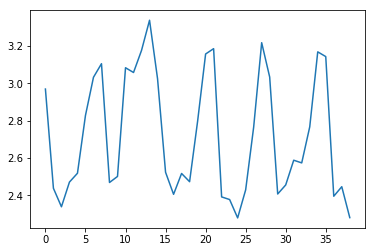

In [29]:
plt.plot(testpreds[129])

In [30]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [31]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.740536   
air_0164b9927d20bcc3_2017-04-23              1.283657   
air_0241aa3964b7f861_2017-04-23              2.323280   
air_0328696196e46f18_2017-04-23              2.016247   
air_034a3d5b40d5b1b1_2017-04-23              3.483405   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.700398  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.609818  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.209103  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.510089  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.570422

In [32]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [33]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [34]:
submission.to_csv("../submission/3003nb_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')